### Data Strategy

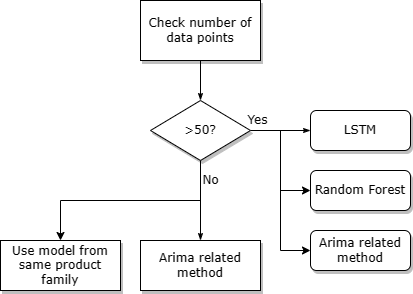

### Model Strategy


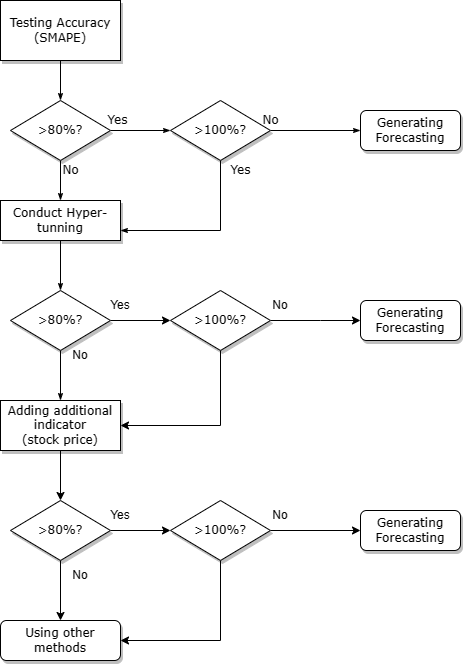


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
import tensorflow as tf
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import keras
import pickle 
import itertools
import os
import random as rn
from keras import backend as K
# SEED = 666
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# tf.random.set_seed(SEED)
# rn.seed(SEED)

In [2]:
# loss function of smape
def smape_loss(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    numerator = tf.reduce_sum(tf.abs(y_true - y_pred))
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / denominator

# Function to create lag window
def slicewindow(data, step):
    X, y = [], []
    for i in range(0, len(data) - step, 1):
        end = i + step
        oneX, oney = data[i:end, :], data[end, :]
        X.append(oneX)
        y.append(oney)
    return np.array(X), np.array(y)

# function to create training and testing datasets
def datasplit(dataset, step):
    datasetX, datasetY = slicewindow(dataset, step)
    train_size = int(len(datasetX) * 0.80)
    X_train, y_train = datasetX[0:train_size, :], datasetY[0:train_size, :]
    X_test, y_test = datasetX[train_size:len(datasetX), :], datasetY[train_size:len(datasetX), :]
    X_train = X_train.reshape(X_train.shape[0], step, -1)
    X_test = X_test.reshape(X_test.shape[0], step, -1)
    return X_train, X_test, y_train, y_test

# function of LSTM model
def seq2seqModel(X, step):
    K.clear_session()
    tf.reset_default_graph()
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(step, X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(X.shape[2]))
    model.compile(optimizer='adam', loss=smape_loss)
    return model

# function to create future demand
def predictfuture(dataset, step, model, period):
    for _ in range(period):
        datasetX = dataset[-step:]
        X_train = datasetX.reshape(1, step, datasetX.shape[1])
        next_prediction = model.predict(X_train)
        dataset = np.vstack([dataset, next_prediction])
    return dataset[-period:]

# Plot the trend
def plotting(result, period, hyper=False, stock=False):
    actual = pd.DataFrame(result[4].reset_index(drop=True))
    predict = pd.DataFrame(result[3])
    predict.index = list(range(len(actual) - len(predict), len(actual)))
    future = pd.DataFrame(result[2])
    future.index = list(range(len(actual), len(actual) + period))
    plt.figure(figsize=(12, 6))
    plt.plot(actual['demand'], label="Actual Demand")
    plt.plot(predict[0], label="Predicted Demand")
    plt.plot(future[0], label="Future Demand")
    plt.xlabel("Months")
    plt.ylabel("Demand")
    percent_string = '%'
    plt.title("Actual vs Predicted Demand: %s, test accuracy: %s%s" % (
        name, round(100.00 * float(result[0]), 2), percent_string))
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    if hyper:
        kurs = "LSTM_plot/hyper/%s.png" % name
        if stock:
            kurs = "LSTM_plot/stock/hyper/%s.png" % name
    else:
        kurs = "LSTM_plot/%s.png" % name
        if stock:
            kurs = "LSTM_plot/stock/%s.png" % name
    plt.savefig(kurs, format='png')

In [3]:
#Calculate the error indicator
def calculate_smape(df_forcalculate):
    # calculate the correlation between each feature and demand and choose the first 8 features
    corr_matrix = df_forcalculate.corr()
    demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
    index_list = demand_corr.index.tolist()
    df = df_forcalculate[index_list[0:8]]
    real_demand = df['demand']
    # Normalize the data
    scaler = StandardScaler()
    df_sc = scaler.fit_transform(df.reset_index(drop=True))
    dataset = np.array(df_sc)

    X_train, X_test, y_train, y_test = datasplit(dataset, step)
    model = seq2seqModel(X_train, step)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model.fit(X_train, y_train, epochs=50, verbose=0, validation_split=0.2, batch_size=64, callbacks=[es])
    y_pred = model.predict(X_test)
    predicted_demand = scaler.inverse_transform(y_pred)
    y_true = scaler.inverse_transform(y_test)
    smape = smape_loss(y_true[:, 0], predicted_demand[:, 0])

    return dataset, model, X_train, X_test, y_train, y_test, predicted_demand, smape, scaler, real_demand

In [6]:
#Function og hyperparameter tunning
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test, sc, accuracy):
    n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(n_neurons, n_batch_size, dropout))

    hist = []
    best_accracy = accuracy
    best_smape = 1 - best_accracy
    indicator = False
    for i in range(0, len(possible_combinations)):

        print(f'{i + 1}th combination: \n')
        print('--------------------------------------------------------------------')

        n_neurons, n_batch_size, dropout = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        # with tpu_strategy.scope():
        K.clear_session()
        tf.reset_default_graph()
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, activation='relu', return_sequences=True,
                           input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

#         if first_additional_layer:
#             regressor.add(LSTM(units=n_neurons, activation='relu', return_sequences=True,
#                                input_shape=(x_train.shape[1], x_train.shape[2])))
#             regressor.add(Dropout(dropout))

        # if second_additional_layer:
        #     regressor.add(LSTM(units=n_neurons))
        #     regressor.add(Dropout(dropout))
        #
        # if third_additional_layer:
        #     regressor.add(GRU(units=n_neurons))
        #     regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, activation='relu'))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=x_train.shape[2]))
        regressor.compile(optimizer='adam', loss=smape_loss)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'temp/best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=n_batch_size, callbacks=[es, mc],
                      verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        y_pred = regressor.predict(x_test)
        predicted_demand = scaler.inverse_transform(y_pred)
        y_true = sc.inverse_transform(y_test)
        smape = smape_loss(y_true[:, 0], predicted_demand[:, 0])
        if 0.00 < smape < 1.00:
            new_accuracy = 1.00 - smape
            if new_accuracy > best_accracy:
                indicator = True
                best_accracy = new_accuracy
                best_smape = smape
                best_regressor = regressor
                best_predicted_demand = predicted_demand
                hist.append(list(
                    (n_neurons, n_batch_size,
                     dropout,
                     best_accracy)))
                if best_accracy > 0.7999999:
                    break
            else:
                if indicator:
                    pass
                else:
                    best_regressor, best_predicted_demand = [], []
                hist.append(list((n_neurons, n_batch_size, dropout, 'not working')))
        else:
            if indicator:
                pass
            else:
                best_regressor, best_predicted_demand = [], []
            hist.append(list((n_neurons, n_batch_size, dropout, 'not working')))
    return best_accracy, best_smape, best_regressor, best_predicted_demand, hist

In [7]:
# Load the Excel file
df_origin = pd.read_csv('20230411_SummerTerm23_Data_Challenge_Infineon_Data.csv')
stockprice = pd.read_csv('stockprice.csv')
#delete discontinuing products
df_continue = df_origin[df_origin['reporting_time']=='2023-02-01T00:00:00.000Z']
df_continue_origin = df_origin[df_origin['product_name'].isin(df_continue['product_name'])]

# Check number of datapoints
product_counts = df_continue_origin['product_name'].value_counts()
i=0
for name in tqdm(df_continue_origin['product_name'].unique()):
    # if we have enough data points
    if product_counts[name] > 50:
        i=i+1
#result dictionaries
result = {}
result_temp = []
result_less80 = {}
result_other = {}
result_hype = {}
result_stock = {}
result_stock_hype = {}
result_stock_hype_other = {}
result_stock_other = {}
# Use previous 15 data to predict next demand
step = 15 
future_periods = 18
config = [[25, 50], [32, 64], [0.1, 0.2]]

100%|██████████| 1392/1392 [00:00<00:00, 232682.57it/s]


In [ ]:
for name in tqdm(df_continue_origin['product_name'].unique()):
    # if we have enough data points
    if product_counts[name] > 50:
        df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
        df_product = df_product.sort_values(by='reporting_time', ascending=True)
        dataset, model, X_train, X_test, y_train, y_test, predicted_demand, smape, scaler, real_demand = calculate_smape(
            df_product)
        if 0.00 < smape < 1.00:
            accuracy = 1.00 - smape
            if accuracy > 0.79999999:
                future = predictfuture(dataset, step, model, future_periods)
                future_demand = scaler.inverse_transform(future)[:, 0]
                result[name] = [accuracy, smape, future_demand, predicted_demand[:, 0], real_demand]
                model.save("LSTM_model/%s.keras" % name)
                plotting(result[name], future_periods, hyper=False)
            else:
                result_less80[name] = [accuracy, smape, X_train, X_test, y_train, y_test]
                # hyperparameter tunning
                new_accuracy, new_smape, new_model, new_predicted_demand, hist = LSTM_HyperParameter_Tuning(config,
                                                                                                            X_train,
                                                                                                            y_train,
                                                                                                            X_test,
                                                                                                            y_test,
                                                                                                            scaler,
                                                                                                            accuracy)
                if new_accuracy > 0.79999999:
                    future = predictfuture(dataset, step, new_model, future_periods)
                    future_demand = scaler.inverse_transform(future)[:, 0]
                    result_hype[name] = [new_accuracy, new_smape, future_demand, new_predicted_demand[:, 0],
                                         real_demand]
                    model.save("LSTM_model/hyper/%s.keras" % name)
                    plotting(result_hype[name], future_periods, hyper=True)
                else:
                    result_temp.append(name)
        else:
            result_other[name] = [accuracy, smape, X_train, X_test, y_train, y_test]

  0%|          | 0/1392 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 18ms/step


  0%|          | 2/1392 [00:06<1:17:19,  3.34s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 18: early stopping
1/1 [==============================] - 0s 288ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.98687, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.98687 to -2.05825, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.05825 to -2.13842, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.13842 to -2.23171, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.23171 to -2.34036, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.34036 to -2.46497, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.46497 to -2.61199, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -2.61199 to -2.79253, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -2.79253 to -3.02640, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 11: val_loss did not improve from -33.07972

Epoch 12: val_loss did not improve from -33.07972

Epoch 13: val_loss did not improve from -33.07972

Epoch 14: val_loss did not improve from -33.07972

Epoch 15: val_loss did not improve from -33.07972
Epoch 15: early stopping
1/1 [==============================] - 0s 231ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.20378, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.20378 to -2.33970, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.33970 to -2.50729, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.50729 to -2.72086, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.72086 to -2.99556, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.99556 to -3.36375, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -3.36375 to

  0%|          | 3/1392 [00:50<7:45:21, 20.10s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 28ms/step


  0%|          | 4/1392 [00:57<5:54:26, 15.32s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 254ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 5.33763, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 5.33763 to 4.72886, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 4.72886 to 4.21413, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 4.21413 to 3.77261, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 3.77261 to 3.44431, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 3.44431 to 3.21286, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 3.21286 to 2.97744, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.97744 to 2.77472, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.77472 to 2.60593, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.60593 to 2.46595, saving model to t


Epoch 41: val_loss improved from 2.34553 to 2.33921, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 2.33921 to 2.33344, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 2.33344 to 2.32815, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 2.32815 to 2.32331, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 2.32331 to 2.31887, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 2.31887 to 2.31480, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 2.31480 to 2.31107, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 2.31107 to 2.30764, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 2.30764 to 2.30449, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 2.30449 to 2.30158, saving model to temp\best_model.h5
1/1 [==============================] - 0s 469ms/step
3th combination: 

--------------------------------------

  0%|          | 5/1392 [01:28<7:57:38, 20.66s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 17: early stopping
1/1 [==============================] - 0s 245ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.54815, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.54815 to 1.51922, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.51922 to 1.49033, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.49033 to 1.46192, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.46192 to 1.43368, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.43368 to 1.40512, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.40512 to 1.37588, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.37588 to 1.34549, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.34549 to 1.31532, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.31532 to 1


Epoch 32: val_loss did not improve from 0.88277

Epoch 33: val_loss did not improve from 0.88277
Epoch 33: early stopping
1/1 [==============================] - 0s 247ms/step
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.58792, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.58792 to 1.54813, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.54813 to 1.51110, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.51110 to 1.47465, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.47465 to 1.43802, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.43802 to 1.39957, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.39957 to 1.35952, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.35952 to 1.31921, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.3


Epoch 12: val_loss improved from 0.95621 to 0.89900, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.89900 to 0.83922, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.83922 to 0.78872, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.78872 to 0.77277, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.77277 to 0.76627, saving model to temp\best_model.h5

Epoch 17: val_loss did not improve from 0.76627

Epoch 18: val_loss did not improve from 0.76627

Epoch 19: val_loss did not improve from 0.76627

Epoch 20: val_loss did not improve from 0.76627

Epoch 21: val_loss did not improve from 0.76627
Epoch 21: early stopping
1/1 [==============================] - 0s 290ms/step


  0%|          | 6/1392 [02:08<10:24:38, 27.04s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 23: early stopping
1/1 [==============================] - 0s 249ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.42968, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.42968 to 1.40379, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.40379 to 1.37845, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.37845 to 1.35342, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.35342 to 1.32818, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.32818 to 1.30288, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.30288 to 1.27717, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.27717 to 1.25111, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.25111 to 1.22416, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.22416 to 1


Epoch 40: val_loss improved from 0.71057 to 0.67731, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.67731 to 0.64203, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.64203 to 0.60891, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.60891 to 0.57781, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.57781 to 0.55449, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.55449 to 0.53947, saving model to temp\best_model.h5

Epoch 46: val_loss did not improve from 0.53947

Epoch 47: val_loss did not improve from 0.53947

Epoch 48: val_loss did not improve from 0.53947

Epoch 49: val_loss did not improve from 0.53947

Epoch 50: val_loss did not improve from 0.53947
Epoch 50: early stopping
1/1 [==============================] - 0s 289ms/step
3th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.38589, saving


Epoch 32: val_loss did not improve from 0.52642

Epoch 33: val_loss did not improve from 0.52642

Epoch 34: val_loss did not improve from 0.52642

Epoch 35: val_loss did not improve from 0.52642
Epoch 35: early stopping
1/1 [==============================] - 0s 251ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.29253, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.29253 to 1.24049, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.24049 to 1.19194, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.19194 to 1.14503, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.14503 to 1.09819, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.09819 to 1.05171, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.05171 to 1.00485, saving model to temp\best_model.h5

Epoch 8: val_loss improve


Epoch 21: val_loss improved from 0.66357 to 0.63909, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.63909 to 0.63108, saving model to temp\best_model.h5

Epoch 23: val_loss did not improve from 0.63108

Epoch 24: val_loss did not improve from 0.63108

Epoch 25: val_loss did not improve from 0.63108

Epoch 26: val_loss did not improve from 0.63108

Epoch 27: val_loss did not improve from 0.63108
Epoch 27: early stopping
1/1 [==============================] - 0s 247ms/step
8th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.40106, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.40106 to 1.34015, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.34015 to 1.28297, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.28297 to 1.22834, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.22834 to 1.17687, saving mod

  1%|          | 7/1392 [02:56<13:03:51, 33.96s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 25: early stopping
1/1 [==============================] - 0s 249ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 107.11085, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 107.11085 to 42.78570, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 42.78570 to 26.69202, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 26.69202 to 19.42017, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 19.42017 to 15.14583, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 15.14583 to 12.34525, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 12.34525 to 10.36828, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 10.36828 to 8.88800, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 8.88800 to 7.73848, saving model to temp\best_model.h5

Epoch 10: val_loss improved f

3th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -218.92293, saving model to temp\best_model.h5

Epoch 2: val_loss did not improve from -218.92293

Epoch 3: val_loss did not improve from -218.92293

Epoch 4: val_loss did not improve from -218.92293

Epoch 5: val_loss did not improve from -218.92293

Epoch 6: val_loss did not improve from -218.92293
Epoch 6: early stopping
1/1 [==============================] - 0s 247ms/step
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 136.00696, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 136.00696 to 77.07854, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 77.07854 to 54.69518, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 54.69518 to 42.46020, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 42.46020 to 34.


Epoch 16: val_loss improved from 1.08755 to 1.01524, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.01524 to 0.99721, saving model to temp\best_model.h5

Epoch 18: val_loss did not improve from 0.99721

Epoch 19: val_loss did not improve from 0.99721

Epoch 20: val_loss did not improve from 0.99721

Epoch 21: val_loss did not improve from 0.99721

Epoch 22: val_loss did not improve from 0.99721
Epoch 22: early stopping
1/1 [==============================] - 0s 307ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 16.20792, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 16.20792 to 11.13004, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 11.13004 to 8.49574, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 8.49574 to 6.87345, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 6.87345 to 5.77797, saving

  1%|          | 8/1392 [03:42<14:28:56, 37.67s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 13: early stopping
1/1 [==============================] - 0s 303ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -4.37517, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -4.37517 to -5.09349, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -5.09349 to -6.08456, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -6.08456 to -7.56425, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -7.56425 to -9.99240, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -9.99240 to -14.92877, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -14.92877 to -30.56058, saving model to temp\best_model.h5

Epoch 8: val_loss did not improve from -30.56058

Epoch 9: val_loss did not improve from -30.56058

Epoch 10: val_loss did not improve from -30.56058

Epoch 11: val_loss did not improve from -30.56058

Epo


Epoch 4: val_loss improved from -3.59063 to -4.15941, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -4.15941 to -4.99310, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -4.99310 to -6.36372, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -6.36372 to -9.08424, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -9.08424 to -17.22030, saving model to temp\best_model.h5

Epoch 9: val_loss did not improve from -17.22030

Epoch 10: val_loss did not improve from -17.22030

Epoch 11: val_loss did not improve from -17.22030

Epoch 12: val_loss did not improve from -17.22030

Epoch 13: val_loss did not improve from -17.22030
Epoch 13: early stopping
1/1 [==============================] - 0s 241ms/step
8th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.69032, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.69032 to

  1%|          | 9/1392 [04:16<14:06:18, 36.72s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 247ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.36721, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.36721 to 1.34004, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.34004 to 1.31356, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.31356 to 1.28785, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.28785 to 1.26306, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.26306 to 1.23866, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.23866 to 1.21476, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.21476 to 1.19184, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.19184 to 1.16939, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.16939 to 1.14963, saving model to t


Epoch 41: val_loss improved from 1.13102 to 1.13003, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.13003 to 1.12909, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.12909 to 1.12819, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.12819 to 1.12732, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.12732 to 1.12649, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.12649 to 1.12569, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.12569 to 1.12492, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.12492 to 1.12418, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.12418 to 1.12346, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.12346 to 1.12276, saving model to temp\best_model.h5
1/1 [==============================] - 0s 313ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.84283 to 0.83537, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.83537 to 0.82836, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.82836 to 0.82175, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.82175 to 0.81579, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.81579 to 0.81016, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.81016 to 0.80488, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.80488 to 0.79987, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.79987 to 0.79516, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.79516 to 0.79073, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.79073 to 0.78652, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.78652 to 0.78257, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.71749 to 0.71086, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.71086 to 0.70569, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.70569 to 0.70102, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.70102 to 0.69673, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.69673 to 0.69278, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.69278 to 0.68916, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.68916 to 0.68583, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.68583 to 0.68277, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.68277 to 0.67996, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.67996 to 0.67739, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.67739 to 0.67502, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.01104 to 0.98499, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.98499 to 0.95987, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.95987 to 0.93604, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.93604 to 0.91361, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.91361 to 0.89231, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.89231 to 0.87210, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.87210 to 0.85293, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.85293 to 0.83481, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.83481 to 0.81778, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.81778 to 0.80173, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.80173 to 0.78662, saving model to temp\best_model.h5

Epoch 22: val_loss i

  1%|          | 10/1392 [05:16<16:49:45, 43.84s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 19: early stopping
1/1 [==============================] - 0s 371ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.51553, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.51553 to 2.43590, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.43590 to 2.35254, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.35254 to 2.26449, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.26449 to 2.17937, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.17937 to 2.09633, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.09633 to 2.01050, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.01050 to 1.92158, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.92158 to 1.83257, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.83257 to 1


Epoch 31: val_loss improved from 1.31959 to 1.24901, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.24901 to 1.18509, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.18509 to 1.12600, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.12600 to 1.07218, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.07218 to 1.02329, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.02329 to 0.97914, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.97914 to 0.94346, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.94346 to 0.91447, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.91447 to 0.89421, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.89421 to 0.87702, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.87702 to 0.87096, saving model to temp\best_model.h5

Epoch 42: val_loss d


Epoch 9: val_loss improved from 1.39654 to 1.28072, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.28072 to 1.17129, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.17129 to 1.06387, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.06387 to 0.96506, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.96506 to 0.88495, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.88495 to 0.82744, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.82744 to 0.79733, saving model to temp\best_model.h5

Epoch 16: val_loss did not improve from 0.79733

Epoch 17: val_loss did not improve from 0.79733

Epoch 18: val_loss did not improve from 0.79733

Epoch 19: val_loss did not improve from 0.79733

Epoch 20: val_loss did not improve from 0.79733
Epoch 20: early stopping
1/1 [==============================] - 0s 254ms/step
7th combination: 

------------------------------------

  1%|          | 11/1392 [06:21<19:17:08, 50.27s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 316ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.62931, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.62931 to 1.60378, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.60378 to 1.57692, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.57692 to 1.54872, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.54872 to 1.52245, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.52245 to 1.50665, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.50665 to 1.48862, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.48862 to 1.47214, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.47214 to 1.45713, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.45713 to 1.44384, saving model to t


Epoch 41: val_loss improved from 1.14742 to 1.13956, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.13956 to 1.13229, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.13229 to 1.12581, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.12581 to 1.11984, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.11984 to 1.11436, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.11436 to 1.10937, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.10937 to 1.10474, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.10474 to 1.10046, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.10046 to 1.09664, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.09664 to 1.09310, saving model to temp\best_model.h5
1/1 [==============================] - 0s 250ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.45894 to 1.45643, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.45643 to 1.45413, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.45413 to 1.45203, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.45203 to 1.45016, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.45016 to 1.44845, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.44845 to 1.44689, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.44689 to 1.44545, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.44545 to 1.44414, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.44414 to 1.44293, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.44293 to 1.44183, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.44183 to 1.44081, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.23750 to 1.22045, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.22045 to 1.20509, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.20509 to 1.19164, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.19164 to 1.17905, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.17905 to 1.16734, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.16734 to 1.15646, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.15646 to 1.14639, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.14639 to 1.13704, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.13704 to 1.12835, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.12835 to 1.12028, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.12028 to 1.11278, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.54692 to 1.51423, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.51423 to 1.47977, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.47977 to 1.44712, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.44712 to 1.41687, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.41687 to 1.38870, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.38870 to 1.36224, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.36224 to 1.33759, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.33759 to 1.31455, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.31455 to 1.29306, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.29306 to 1.27303, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.27303 to 1.25436, saving model to temp\best_model.h5

Epoch 22: val_loss i

  1%|          | 12/1392 [07:18<20:03:36, 52.33s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 20ms/step


  1%|          | 13/1392 [07:24<14:38:54, 38.24s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 316ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 5.88084, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 5.88084 to 5.63249, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 5.63249 to 5.39452, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 5.39452 to 5.19663, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 5.19663 to 5.03163, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 5.03163 to 4.89075, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 4.89075 to 4.76697, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 4.76697 to 4.65870, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 4.65870 to 4.56348, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 4.56348 to 4.47861, saving model to t


Epoch 41: val_loss improved from 2.95934 to 2.95542, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 2.95542 to 2.95186, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 2.95186 to 2.94863, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 2.94863 to 2.94568, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 2.94568 to 2.94301, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 2.94301 to 2.94057, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 2.94057 to 2.93836, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 2.93836 to 2.93634, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 2.93634 to 2.93451, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 2.93451 to 2.93284, saving model to temp\best_model.h5
1/1 [==============================] - 0s 247ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 2.84692 to 2.80057, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 2.80057 to 2.75775, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 2.75775 to 2.71829, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 2.71829 to 2.68153, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 2.68153 to 2.64717, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 2.64717 to 2.61519, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 2.61519 to 2.58554, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 2.58554 to 2.55811, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 2.55811 to 2.53256, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 2.53256 to 2.50877, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 2.50877 to 2.48635, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 26: val_loss improved from 2.79639 to 2.77998, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 2.77998 to 2.76508, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 2.76508 to 2.75155, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 2.75155 to 2.73928, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 2.73928 to 2.72813, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 2.72813 to 2.71797, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 2.71797 to 2.70872, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 2.70872 to 2.70030, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 2.70030 to 2.69262, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 2.69262 to 2.68559, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 2.68559 to 2.67917, saving model to temp\best_model.h5

Epoch 37: val_loss i


Epoch 16: val_loss improved from 2.54578 to 2.48392, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 2.48392 to 2.42736, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 2.42736 to 2.37531, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 2.37531 to 2.32731, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 2.32731 to 2.28292, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 2.28292 to 2.24182, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 2.24182 to 2.20339, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 2.20339 to 2.16751, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 2.16751 to 2.13383, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 2.13383 to 2.10206, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 2.10206 to 2.07203, saving model to temp\best_model.h5

Epoch 27: val_loss i

  1%|          | 14/1392 [08:21<16:45:38, 43.79s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 20ms/step


  1%|          | 15/1392 [08:27<12:25:02, 32.46s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 31: early stopping
1/1 [==============================] - 0s 239ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.08744, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.08744 to 1.05596, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.05596 to 1.02495, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.02495 to 0.99379, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 0.99379 to 0.96303, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 0.96303 to 0.93234, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.93234 to 0.90067, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.90067 to 0.86813, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.86813 to 0.83526, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.83526 to 0


Epoch 30: val_loss improved from 1.34492 to 1.34428, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.34428 to 1.34369, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.34369 to 1.34314, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.34314 to 1.34263, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.34263 to 1.34215, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.34215 to 1.34170, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.34170 to 1.34127, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.34127 to 1.34088, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.34088 to 1.34050, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.34050 to 1.34015, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.34015 to 1.33982, saving model to temp\best_model.h5

Epoch 41: val_loss i


Epoch 12: val_loss improved from 1.03223 to 1.00767, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.00767 to 0.98270, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.98270 to 0.95600, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.95600 to 0.92778, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.92778 to 0.89815, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.89815 to 0.86885, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.86885 to 0.83849, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.83849 to 0.80609, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.80609 to 0.77284, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.77284 to 0.74031, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.74031 to 0.70903, saving model to temp\best_model.h5

Epoch 23: val_loss i


Epoch 42: val_loss improved from 0.87652 to 0.86943, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.86943 to 0.86258, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.86258 to 0.85596, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.85596 to 0.84949, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.84949 to 0.84331, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.84331 to 0.83765, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.83765 to 0.83224, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.83224 to 0.82722, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.82722 to 0.82247, saving model to temp\best_model.h5
1/1 [==============================] - 0s 263ms/step


  1%|          | 16/1392 [09:14<14:07:19, 36.95s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 1s 524ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.04512, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.04512 to 1.01386, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.01386 to 0.98559, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 0.98559 to 0.96589, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 0.96589 to 0.94772, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 0.94772 to 0.93018, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.93018 to 0.91602, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.91602 to 0.90353, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.90353 to 0.89231, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.89231 to 0.88208, saving model to t


Epoch 41: val_loss improved from 0.92300 to 0.92201, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.92201 to 0.92108, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.92108 to 0.92019, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.92019 to 0.91934, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.91934 to 0.91852, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.91852 to 0.91772, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.91772 to 0.91695, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.91695 to 0.91620, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.91620 to 0.91547, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.91547 to 0.91478, saving model to temp\best_model.h5
1/1 [==============================] - 1s 557ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.82481 to 0.81965, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.81965 to 0.81473, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.81473 to 0.81005, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.81005 to 0.80559, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.80559 to 0.80133, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.80133 to 0.79726, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.79726 to 0.79339, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.79339 to 0.78972, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.78972 to 0.78617, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.78617 to 0.78270, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.78270 to 0.77936, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.79216 to 0.77880, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.77880 to 0.76616, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.76616 to 0.75423, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.75423 to 0.74295, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.74295 to 0.73226, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.73226 to 0.72206, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.72206 to 0.71224, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.71224 to 0.70284, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.70284 to 0.69445, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.69445 to 0.68659, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.68659 to 0.67960, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.07508 to 1.06170, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.06170 to 1.04952, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.04952 to 1.03840, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.03840 to 1.02829, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.02829 to 1.01919, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.01919 to 1.01084, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.01084 to 1.00317, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.00317 to 0.99612, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.99612 to 0.98964, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.98964 to 0.98384, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.98384 to 0.97859, saving model to temp\best_model.h5

Epoch 22: val_loss i

  1%|          | 17/1392 [10:34<19:01:39, 49.82s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 245ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.14971, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.14971 to 1.12458, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.12458 to 1.10146, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.10146 to 1.07963, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.07963 to 1.06110, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.06110 to 1.04436, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.04436 to 1.03131, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.03131 to 1.02249, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.02249 to 1.01451, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.01451 to 1.00720, saving model to t


Epoch 41: val_loss improved from 1.07394 to 1.07382, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.07382 to 1.07372, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.07372 to 1.07362, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.07362 to 1.07353, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.07353 to 1.07344, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.07344 to 1.07337, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.07337 to 1.07330, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.07330 to 1.07323, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.07323 to 1.07317, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.07317 to 1.07311, saving model to temp\best_model.h5
1/1 [==============================] - 0s 244ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.89861 to 0.89655, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.89655 to 0.89462, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.89462 to 0.89280, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.89280 to 0.89108, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.89108 to 0.88952, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.88952 to 0.88805, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.88805 to 0.88666, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.88666 to 0.88534, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.88534 to 0.88409, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.88409 to 0.88290, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.88290 to 0.88176, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.89922 to 0.89605, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.89605 to 0.89312, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.89312 to 0.89043, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.89043 to 0.88795, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.88795 to 0.88566, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.88566 to 0.88354, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.88354 to 0.88159, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.88159 to 0.87978, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.87978 to 0.87811, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.87811 to 0.87657, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.87657 to 0.87514, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.01721 to 1.01076, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.01076 to 1.00492, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.00492 to 0.99957, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.99957 to 0.99470, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.99470 to 0.99025, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.99025 to 0.98620, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.98620 to 0.98254, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.98254 to 0.97917, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.97917 to 0.97607, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.97607 to 0.97320, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.97320 to 0.97055, saving model to temp\best_model.h5

Epoch 22: val_loss i

  1%|▏         | 18/1392 [11:31<19:47:25, 51.85s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 255ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.25012, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.25012 to 1.22169, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.22169 to 1.19506, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.19506 to 1.16934, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.16934 to 1.14590, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.14590 to 1.12804, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.12804 to 1.11369, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.11369 to 1.09767, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.09767 to 1.08255, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08255 to 1.06905, saving model to t


Epoch 41: val_loss improved from 1.07416 to 1.07320, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.07320 to 1.07230, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.07230 to 1.07147, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.07147 to 1.07070, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.07070 to 1.06998, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.06998 to 1.06930, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.06930 to 1.06867, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.06867 to 1.06809, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.06809 to 1.06754, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.06754 to 1.06703, saving model to temp\best_model.h5
1/1 [==============================] - 0s 248ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.86819 to 0.86140, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.86140 to 0.85500, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.85500 to 0.84899, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.84899 to 0.84350, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.84350 to 0.83855, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.83855 to 0.83391, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.83391 to 0.82954, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.82954 to 0.82544, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.82544 to 0.82154, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.82154 to 0.81789, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.81789 to 0.81445, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.81992 to 0.81344, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.81344 to 0.80753, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.80753 to 0.80213, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.80213 to 0.79719, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.79719 to 0.79269, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.79269 to 0.78866, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.78866 to 0.78501, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.78501 to 0.78168, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.78168 to 0.77864, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.77864 to 0.77600, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.77600 to 0.77360, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 0.95483 to 0.93381, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.93381 to 0.91462, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.91462 to 0.89667, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.89667 to 0.87990, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.87990 to 0.86433, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.86433 to 0.84989, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.84989 to 0.83689, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.83689 to 0.82493, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.82493 to 0.81380, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.81380 to 0.80343, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.80343 to 0.79378, saving model to temp\best_model.h5

Epoch 22: val_loss i

  1%|▏         | 19/1392 [12:27<20:19:32, 53.29s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 21: early stopping
1/1 [==============================] - 0s 236ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.26294, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.26294 to 1.23962, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.23962 to 1.21593, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.21593 to 1.19306, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.19306 to 1.16932, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.16932 to 1.14425, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.14425 to 1.11798, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.11798 to 1.09086, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.09086 to 1.06222, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.06222 to 1


Epoch 33: val_loss improved from 0.57425 to 0.55577, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.55577 to 0.53993, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.53993 to 0.52662, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.52662 to 0.51577, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.51577 to 0.50738, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.50738 to 0.50126, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.50126 to 0.49785, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.49785 to 0.49475, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.49475 to 0.49186, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.49186 to 0.48942, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.48942 to 0.48759, saving model to temp\best_model.h5

Epoch 44: val_loss i


Epoch 28: val_loss improved from 0.49312 to 0.48613, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.48613 to 0.47953, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.47953 to 0.47817, saving model to temp\best_model.h5

Epoch 31: val_loss did not improve from 0.47817

Epoch 32: val_loss did not improve from 0.47817

Epoch 33: val_loss did not improve from 0.47817

Epoch 34: val_loss did not improve from 0.47817

Epoch 35: val_loss did not improve from 0.47817
Epoch 35: early stopping
1/1 [==============================] - 0s 249ms/step
6th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.29365, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.29365 to 1.25562, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.25562 to 1.21750, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.21750 to 1.17971, saving mo

  1%|▏         | 20/1392 [13:13<19:26:44, 51.02s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 232ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.33973, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.33973 to 1.31676, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.31676 to 1.29509, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.29509 to 1.27503, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.27503 to 1.25801, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.25801 to 1.24104, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.24104 to 1.23073, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.23073 to 1.21842, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.21842 to 1.20732, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.20732 to 1.19739, saving model to t


Epoch 41: val_loss improved from 0.93369 to 0.93338, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.93338 to 0.93310, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.93310 to 0.93282, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.93282 to 0.93257, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.93257 to 0.93232, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.93232 to 0.93209, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.93209 to 0.93187, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.93187 to 0.93166, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.93166 to 0.93146, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.93146 to 0.93134, saving model to temp\best_model.h5
1/1 [==============================] - 0s 247ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.10478 to 1.10390, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.10390 to 1.10309, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.10309 to 1.10234, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.10234 to 1.10165, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.10165 to 1.10102, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.10102 to 1.10043, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.10043 to 1.09989, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.09989 to 1.09940, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.09940 to 1.09894, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.09894 to 1.09852, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.09852 to 1.09813, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.86357 to 0.85949, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.85949 to 0.85574, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.85574 to 0.85227, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.85227 to 0.84909, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.84909 to 0.84616, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.84616 to 0.84346, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.84346 to 0.84098, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.84098 to 0.83870, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.83870 to 0.83658, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.83658 to 0.83462, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.83462 to 0.83281, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.05939 to 1.05018, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.05018 to 1.04186, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.04186 to 1.03427, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.03427 to 1.02736, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.02736 to 1.02096, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.02096 to 1.01504, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.01504 to 1.00956, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.00956 to 1.00450, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.00450 to 0.99983, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.99983 to 0.99549, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.99549 to 0.99140, saving model to temp\best_model.h5

Epoch 22: val_loss i

  2%|▏         | 21/1392 [14:10<20:06:50, 52.82s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 23: early stopping
1/1 [==============================] - 0s 240ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.27659, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.27659 to 1.25775, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.25775 to 1.23811, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.23811 to 1.21737, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.21737 to 1.19590, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.19590 to 1.17359, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.17359 to 1.15083, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.15083 to 1.12790, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.12790 to 1.10355, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.10355 to 1


Epoch 40: val_loss improved from 0.83067 to 0.82911, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.82911 to 0.82768, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.82768 to 0.82636, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.82636 to 0.82516, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.82516 to 0.82406, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.82406 to 0.82305, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.82305 to 0.82212, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.82212 to 0.82126, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.82126 to 0.82048, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.82048 to 0.81976, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.81976 to 0.81910, saving model to temp\best_model.h5
1/1 [================


Epoch 30: val_loss improved from 0.73592 to 0.72221, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.72221 to 0.70947, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.70947 to 0.69754, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.69754 to 0.68662, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.68662 to 0.67689, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.67689 to 0.66788, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.66788 to 0.65962, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.65962 to 0.65220, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.65220 to 0.64538, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.64538 to 0.63926, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.63926 to 0.63365, saving model to temp\best_model.h5

Epoch 41: val_loss i


Epoch 20: val_loss improved from 0.87190 to 0.86130, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.86130 to 0.85154, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.85154 to 0.84253, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.84253 to 0.83421, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.83421 to 0.82651, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.82651 to 0.81942, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.81942 to 0.81286, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.81286 to 0.80681, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.80681 to 0.80123, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.80123 to 0.79609, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.79609 to 0.79136, saving model to temp\best_model.h5

Epoch 31: val_loss i


Epoch 10: val_loss improved from 1.01553 to 0.97828, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.97828 to 0.95186, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.95186 to 0.92744, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.92744 to 0.90169, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.90169 to 0.87789, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.87789 to 0.85553, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.85553 to 0.83444, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.83444 to 0.81455, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.81455 to 0.79584, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.79584 to 0.77831, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.77831 to 0.76272, saving model to temp\best_model.h5

Epoch 21: val_loss i

  2%|▏         | 22/1392 [15:06<20:26:36, 53.72s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 23ms/step


  2%|▏         | 23/1392 [15:12<15:01:57, 39.53s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 29: early stopping
1/1 [==============================] - 0s 244ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.05488, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.05488 to 1.99846, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.99846 to 1.95441, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.95441 to 1.92322, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.92322 to 1.89462, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.89462 to 1.86986, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.86986 to 1.84837, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.84837 to 1.82945, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.82945 to 1.81247, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.81247 to 1


Epoch 40: val_loss improved from 1.34439 to 1.34254, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.34254 to 1.34084, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.34084 to 1.33926, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.33926 to 1.33780, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.33780 to 1.33644, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.33644 to 1.33517, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.33517 to 1.33399, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.33399 to 1.33290, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.33290 to 1.33187, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.33187 to 1.33091, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.33091 to 1.33001, saving model to temp\best_model.h5
1/1 [================


Epoch 30: val_loss improved from 1.69354 to 1.68884, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.68884 to 1.68452, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.68452 to 1.68054, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.68054 to 1.67687, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.67687 to 1.67349, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.67349 to 1.67036, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.67036 to 1.66747, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.66747 to 1.66480, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.66480 to 1.66232, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.66232 to 1.66002, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.66002 to 1.65789, saving model to temp\best_model.h5

Epoch 41: val_loss i


Epoch 20: val_loss improved from 0.82509 to 0.80369, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.80369 to 0.78463, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.78463 to 0.76602, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.76602 to 0.74787, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.74787 to 0.73001, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.73001 to 0.71386, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.71386 to 0.69955, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.69955 to 0.68657, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.68657 to 0.67502, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.67502 to 0.66578, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.66578 to 0.66041, saving model to temp\best_model.h5

Epoch 31: val_loss i


Epoch 24: val_loss improved from 1.36235 to 1.33828, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.33828 to 1.31329, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.31329 to 1.28736, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.28736 to 1.26009, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.26009 to 1.23111, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.23111 to 1.20349, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.20349 to 1.17578, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.17578 to 1.14648, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.14648 to 1.11586, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.11586 to 1.08410, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.08410 to 1.05130, saving model to temp\best_model.h5

Epoch 35: val_loss i

  2%|▏         | 24/1392 [16:09<16:58:30, 44.67s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 235ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.08162, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.08162 to 1.06560, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.06560 to 1.04932, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.04932 to 1.03310, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.03310 to 1.01760, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.01760 to 1.00277, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.00277 to 0.98777, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.98777 to 0.97845, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.97845 to 0.96983, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.96983 to 0.96189, saving model to t


Epoch 41: val_loss improved from 0.57703 to 0.57484, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.57484 to 0.57277, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.57277 to 0.57084, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.57084 to 0.56902, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.56902 to 0.56731, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.56731 to 0.56570, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.56570 to 0.56417, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.56417 to 0.56273, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.56273 to 0.56137, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.56137 to 0.56007, saving model to temp\best_model.h5
1/1 [==============================] - 0s 246ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.92929 to 0.92690, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.92690 to 0.92467, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.92467 to 0.92262, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.92262 to 0.92076, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.92076 to 0.91910, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.91910 to 0.91759, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.91759 to 0.91630, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.91630 to 0.91511, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.91511 to 0.91401, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.91401 to 0.91300, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.91300 to 0.91206, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.83732 to 0.82757, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.82757 to 0.81846, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.81846 to 0.80997, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.80997 to 0.80205, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.80205 to 0.79469, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.79469 to 0.78786, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.78786 to 0.78152, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.78152 to 0.77563, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.77563 to 0.77017, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.77017 to 0.76512, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.76512 to 0.76051, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 0.98770 to 0.96473, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.96473 to 0.94401, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.94401 to 0.91957, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.91957 to 0.89490, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.89490 to 0.87061, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.87061 to 0.84740, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.84740 to 0.82468, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.82468 to 0.80361, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.80361 to 0.78380, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.78380 to 0.76571, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.76571 to 0.74872, saving model to temp\best_model.h5

Epoch 22: val_loss i

  2%|▏         | 25/1392 [17:08<18:39:02, 49.12s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 26: early stopping
1/1 [==============================] - 0s 234ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.04682, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.04682 to 1.93633, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.93633 to 1.84097, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.84097 to 1.75850, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.75850 to 1.68291, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.68291 to 1.61247, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.61247 to 1.54598, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.54598 to 1.48207, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.48207 to 1.42024, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.42024 to 1

1/1 [==============================] - 0s 248ms/step
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.18888, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.18888 to 2.10954, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.10954 to 2.03519, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.03519 to 1.96657, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.96657 to 1.90258, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.90258 to 1.84313, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.84313 to 1.78539, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.78539 to 1.72881, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.72881 to 1.67352, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.67352 to 1.62193, saving model to t


Epoch 17: val_loss did not improve from 0.71051

Epoch 18: val_loss did not improve from 0.71051

Epoch 19: val_loss did not improve from 0.71051

Epoch 20: val_loss did not improve from 0.71051
Epoch 20: early stopping
1/1 [==============================] - 0s 256ms/step
8th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.31770, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.31770 to 2.19397, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.19397 to 2.09119, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.09119 to 2.00507, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.00507 to 1.92450, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.92450 to 1.84577, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.84577 to 1.76852, saving model to temp\best_model.h5

Epoch 8: val_loss improve

  2%|▏         | 26/1392 [17:51<17:51:29, 47.06s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 247ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.39025, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.39025 to 1.36388, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.36388 to 1.33540, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.33540 to 1.30518, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.30518 to 1.27412, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.27412 to 1.24231, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.24231 to 1.20897, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.20897 to 1.17332, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.17332 to 1.13656, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.13656 to 1.09774, saving model to t


Epoch 13: val_loss improved from 1.04619 to 1.02706, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.02706 to 1.00618, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.00618 to 0.98633, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.98633 to 0.96731, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.96731 to 0.94903, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.94903 to 0.92752, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.92752 to 0.90610, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.90610 to 0.88507, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.88507 to 0.86478, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.86478 to 0.84535, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.84535 to 0.82744, saving model to temp\best_model.h5

Epoch 24: val_loss i


Epoch 3: val_loss improved from 1.32817 to 1.29479, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.29479 to 1.26308, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.26308 to 1.23297, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.23297 to 1.20425, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.20425 to 1.17549, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.17549 to 1.14732, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.14732 to 1.11930, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.11930 to 1.09329, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.09329 to 1.07032, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.07032 to 1.05209, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.05209 to 1.03318, saving model to temp\best_model.h5

Epoch 14: val_loss improved


Epoch 44: val_loss improved from 0.53444 to 0.52644, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.52644 to 0.51871, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.51871 to 0.51112, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.51112 to 0.50425, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.50425 to 0.49717, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.49717 to 0.49026, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.49026 to 0.48403, saving model to temp\best_model.h5
1/1 [==============================] - 0s 245ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.32669, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.32669 to 1.28758, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.28758 to 1.25475, saving mode


Epoch 34: val_loss improved from 0.79657 to 0.79253, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.79253 to 0.78878, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.78878 to 0.78528, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.78528 to 0.78203, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.78203 to 0.77901, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.77901 to 0.77626, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.77626 to 0.77377, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.77377 to 0.77146, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.77146 to 0.76930, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.76930 to 0.76728, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.76728 to 0.76538, saving model to temp\best_model.h5

Epoch 45: val_loss i

  2%|▏         | 27/1392 [18:52<19:25:39, 51.24s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 26: early stopping
1/1 [==============================] - 0s 280ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.98082, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.98082 to 1.92349, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.92349 to 1.86761, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.86761 to 1.81398, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.81398 to 1.76521, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.76521 to 1.71708, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.71708 to 1.66933, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.66933 to 1.62324, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.62324 to 1.57664, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.57664 to 1


Epoch 15: val_loss improved from 1.79622 to 1.77569, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.77569 to 1.75434, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.75434 to 1.73222, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.73222 to 1.71016, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.71016 to 1.68675, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.68675 to 1.66164, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.66164 to 1.63583, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.63583 to 1.60834, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.60834 to 1.57819, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.57819 to 1.54521, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.54521 to 1.51038, saving model to temp\best_model.h5

Epoch 26: val_loss i


Epoch 10: val_loss improved from 1.48886 to 1.42658, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.42658 to 1.36273, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.36273 to 1.29585, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.29585 to 1.22876, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.22876 to 1.15957, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.15957 to 1.08952, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.08952 to 1.01636, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.01636 to 0.94557, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.94557 to 0.88490, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.88490 to 0.83584, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.83584 to 0.81632, saving model to temp\best_model.h5

Epoch 21: val_loss d

  2%|▏         | 28/1392 [19:38<18:51:18, 49.76s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 24: early stopping
1/1 [==============================] - 0s 237ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.61375, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.61375 to 1.57070, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.57070 to 1.52828, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.52828 to 1.48827, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.48827 to 1.45020, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.45020 to 1.41389, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.41389 to 1.37999, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.37999 to 1.34728, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.34728 to 1.31510, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.31510 to 1


Epoch 26: val_loss did not improve from 0.76825

Epoch 27: val_loss did not improve from 0.76825

Epoch 28: val_loss did not improve from 0.76825

Epoch 29: val_loss did not improve from 0.76825

Epoch 30: val_loss did not improve from 0.76825
Epoch 30: early stopping
1/1 [==============================] - 0s 248ms/step
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.66147, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.66147 to 1.62572, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.62572 to 1.59306, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.59306 to 1.56322, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.56322 to 1.53594, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.53594 to 1.51086, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.51086 to 1.48733, saving model


Epoch 6: val_loss improved from 1.43351 to 1.40112, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.40112 to 1.36660, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.36660 to 1.32939, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.32939 to 1.29077, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.29077 to 1.24997, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.24997 to 1.20933, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.20933 to 1.17003, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.17003 to 1.12924, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.12924 to 1.08628, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.08628 to 1.03987, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.03987 to 0.99513, saving model to temp\best_model.h5

Epoch 17: val_loss impro

  2%|▏         | 29/1392 [20:24<18:24:10, 48.61s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 19ms/step


  2%|▏         | 30/1392 [20:30<13:35:29, 35.92s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 20ms/step


  2%|▏         | 31/1392 [20:37<10:15:37, 27.14s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 248ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.33350, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.33350 to 1.29889, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.29889 to 1.26661, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.26661 to 1.23595, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.23595 to 1.20609, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.20609 to 1.17641, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.17641 to 1.14794, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.14794 to 1.12069, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.12069 to 1.09370, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.09370 to 1.06707, saving model to t


Epoch 41: val_loss improved from 0.82969 to 0.82573, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.82573 to 0.82209, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.82209 to 0.81874, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.81874 to 0.81565, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.81565 to 0.81282, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.81282 to 0.81021, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.81021 to 0.80781, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.80781 to 0.80561, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.80561 to 0.80358, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.80358 to 0.80172, saving model to temp\best_model.h5
1/1 [==============================] - 0s 245ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.80783 to 0.79725, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.79725 to 0.78782, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.78782 to 0.77905, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.77905 to 0.77092, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.77092 to 0.76341, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.76341 to 0.75636, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.75636 to 0.74973, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.74973 to 0.74352, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.74352 to 0.73771, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.73771 to 0.73222, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.73222 to 0.72708, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.77055 to 0.76118, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.76118 to 0.75256, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.75256 to 0.74510, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.74510 to 0.73853, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.73853 to 0.73257, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.73257 to 0.72734, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.72734 to 0.72254, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.72254 to 0.71813, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.71813 to 0.71408, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.71408 to 0.71038, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.71038 to 0.70699, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 0.75844 to 0.72528, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.72528 to 0.69446, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.69446 to 0.66599, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.66599 to 0.63996, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.63996 to 0.61911, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.61911 to 0.60189, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.60189 to 0.58757, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.58757 to 0.57479, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.57479 to 0.56383, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.56383 to 0.55510, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.55510 to 0.54775, saving model to temp\best_model.h5

Epoch 22: val_loss i

  2%|▏         | 32/1392 [21:33<13:31:30, 35.80s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 48: early stopping
1/1 [==============================] - 0s 316ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.34818, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.34818 to 1.31210, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.31210 to 1.27777, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.27777 to 1.24411, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.24411 to 1.21118, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.21118 to 1.17837, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.17837 to 1.14552, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.14552 to 1.11302, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.11302 to 1.08073, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08073 to 1

1/1 [==============================] - 0s 250ms/step
3th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.29882, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.29882 to 1.26932, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.26932 to 1.24066, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.24066 to 1.21265, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.21265 to 1.18491, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.18491 to 1.15740, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.15740 to 1.13020, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.13020 to 1.10306, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.10306 to 1.07556, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.07556 to 1.04801, saving model to t


Epoch 4: val_loss improved from 1.32377 to 1.28673, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.28673 to 1.24835, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.24835 to 1.20885, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.20885 to 1.16794, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.16794 to 1.12707, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.12707 to 1.08583, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08583 to 1.04336, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.04336 to 0.99928, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.99928 to 0.95378, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.95378 to 0.90660, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.90660 to 0.85751, saving model to temp\best_model.h5

Epoch 15: val_loss improve

  2%|▏         | 33/1392 [22:20<14:48:42, 39.24s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 23ms/step


  2%|▏         | 34/1392 [22:27<11:05:10, 29.39s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 254ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.47150, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.47150 to 1.43669, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.43669 to 1.40326, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.40326 to 1.37049, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.37049 to 1.33863, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.33863 to 1.30662, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.30662 to 1.27499, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.27499 to 1.24260, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.24260 to 1.20959, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.20959 to 1.17696, saving model to t


Epoch 41: val_loss improved from 0.88345 to 0.88125, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.88125 to 0.87920, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.87920 to 0.87729, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.87729 to 0.87552, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.87552 to 0.87387, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.87387 to 0.87233, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.87233 to 0.87088, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.87088 to 0.86953, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.86953 to 0.86825, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.86825 to 0.86712, saving model to temp\best_model.h5
1/1 [==============================] - 0s 298ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.71297 to 0.70553, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.70553 to 0.69855, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.69855 to 0.69210, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.69210 to 0.68682, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.68682 to 0.68187, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.68187 to 0.67723, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.67723 to 0.67289, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.67289 to 0.66884, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.66884 to 0.66503, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.66503 to 0.66143, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.66143 to 0.65800, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.18564 to 1.17791, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.17791 to 1.17084, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.17084 to 1.16440, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.16440 to 1.15848, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.15848 to 1.15309, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.15309 to 1.14818, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.14818 to 1.14367, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.14367 to 1.13954, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.13954 to 1.13575, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.13575 to 1.13228, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.13228 to 1.12911, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.18444 to 1.14886, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.14886 to 1.11500, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.11500 to 1.08040, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.08040 to 1.05351, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.05351 to 1.02583, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.02583 to 0.99045, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.99045 to 0.95526, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.95526 to 0.92057, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.92057 to 0.88725, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.88725 to 0.85913, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.85913 to 0.83460, saving model to temp\best_model.h5

Epoch 22: val_loss i

  3%|▎         | 36/1392 [23:28<11:17:29, 29.98s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 254ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.83295, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.83295 to 1.79841, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.79841 to 1.76511, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.76511 to 1.73198, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.73198 to 1.69917, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.69917 to 1.66965, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.66965 to 1.63830, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.63830 to 1.61022, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.61022 to 1.58104, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.58104 to 1.55001, saving model to t


Epoch 41: val_loss improved from 1.02617 to 1.02109, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.02109 to 1.01637, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.01637 to 1.01199, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.01199 to 1.00792, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.00792 to 1.00413, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.00413 to 1.00058, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.00058 to 0.99729, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.99729 to 0.99421, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.99421 to 0.99134, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.99134 to 0.98863, saving model to temp\best_model.h5
1/1 [==============================] - 0s 321ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.29414 to 1.29194, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.29194 to 1.28992, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.28992 to 1.28808, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.28808 to 1.28640, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.28640 to 1.28486, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.28486 to 1.28345, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.28345 to 1.28216, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.28216 to 1.28098, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.28098 to 1.27991, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.27991 to 1.27892, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.27892 to 1.27802, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.37750 to 1.36636, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.36636 to 1.35583, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.35583 to 1.34584, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.34584 to 1.33626, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.33626 to 1.32710, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.32710 to 1.31829, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.31829 to 1.30975, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.30975 to 1.30150, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.30150 to 1.29342, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.29342 to 1.28544, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.28544 to 1.27755, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.51671 to 1.49656, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.49656 to 1.47769, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.47769 to 1.46005, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.46005 to 1.44350, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.44350 to 1.42796, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.42796 to 1.41339, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.41339 to 1.39982, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.39982 to 1.38713, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.38713 to 1.37525, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.37525 to 1.36411, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.36411 to 1.35370, saving model to temp\best_model.h5

Epoch 22: val_loss i

  3%|▎         | 38/1392 [24:26<11:07:33, 29.58s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 25: early stopping
1/1 [==============================] - 0s 250ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.16536, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.16536 to 1.13857, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.13857 to 1.11452, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.11452 to 1.09481, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.09481 to 1.07595, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.07595 to 1.05801, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.05801 to 1.04047, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.04047 to 1.02299, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.02299 to 1.00554, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.00554 to 0


Epoch 5: val_loss improved from 1.02361 to 1.01617, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.01617 to 1.00898, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.00898 to 1.00200, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.00200 to 0.99510, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.99510 to 0.98849, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.98849 to 0.98218, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.98218 to 0.97596, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.97596 to 0.96976, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.96976 to 0.96352, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.96352 to 0.95724, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.95724 to 0.95095, saving model to temp\best_model.h5

Epoch 16: val_loss improv


Epoch 46: val_loss improved from 0.60522 to 0.60204, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.60204 to 0.59984, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.59984 to 0.59802, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.59802 to 0.59634, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.59634 to 0.59493, saving model to temp\best_model.h5
1/1 [==============================] - 1s 622ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.02625, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.02625 to 0.98627, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 0.98627 to 0.94915, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 0.94915 to 0.91368, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 0.91368 to 0.87855, saving model 


Epoch 6: val_loss improved from 0.95507 to 0.92992, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.92992 to 0.90516, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.90516 to 0.87902, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.87902 to 0.85073, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.85073 to 0.82027, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.82027 to 0.78827, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.78827 to 0.75347, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.75347 to 0.71450, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.71450 to 0.67223, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.67223 to 0.62538, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.62538 to 0.57611, saving model to temp\best_model.h5

Epoch 17: val_loss impro

  3%|▎         | 39/1392 [25:15<12:43:35, 33.86s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 12: early stopping
1/1 [==============================] - 0s 249ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -4.08886, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -4.08886 to -4.45557, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -4.45557 to -4.93365, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -4.93365 to -5.58295, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -5.58295 to -6.52139, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -6.52139 to -7.97474, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -7.97474 to -10.49842, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -10.49842 to -16.10519, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -16.10519 to -39.53379, saving model to temp\best_model.h5

Epoch 10: val_loss did 


Epoch 3: val_loss improved from -4.51192 to -6.26721, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -6.26721 to -10.45330, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -10.45330 to -36.77413, saving model to temp\best_model.h5

Epoch 6: val_loss did not improve from -36.77413

Epoch 7: val_loss did not improve from -36.77413

Epoch 8: val_loss did not improve from -36.77413

Epoch 9: val_loss did not improve from -36.77413

Epoch 10: val_loss did not improve from -36.77413
Epoch 10: early stopping
1/1 [==============================] - 0s 239ms/step
8th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -5.01836, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -5.01836 to -6.66250, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -6.66250 to -10.24085, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -10.24085 t

  3%|▎         | 40/1392 [25:50<12:49:35, 34.15s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 316ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.62737, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.62737 to 1.59582, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.59582 to 1.56719, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.56719 to 1.54724, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.54724 to 1.52622, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.52622 to 1.50724, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.50724 to 1.49049, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.49049 to 1.47565, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.47565 to 1.46234, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.46234 to 1.45036, saving model to t


Epoch 41: val_loss improved from 1.41754 to 1.41709, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.41709 to 1.41669, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.41669 to 1.41631, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.41631 to 1.41597, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.41597 to 1.41566, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.41566 to 1.41537, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.41537 to 1.41511, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.41511 to 1.41488, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.41488 to 1.41466, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.41466 to 1.41446, saving model to temp\best_model.h5
1/1 [==============================] - 0s 316ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.02577 to 1.01936, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.01936 to 1.01313, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.01313 to 1.00702, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.00702 to 1.00102, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.00102 to 0.99580, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.99580 to 0.99076, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.99076 to 0.98583, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.98583 to 0.98099, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.98099 to 0.97623, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.97623 to 0.97156, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.97156 to 0.96691, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.47527 to 1.46850, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.46850 to 1.46207, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.46207 to 1.45588, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.45588 to 1.45002, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.45002 to 1.44465, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.44465 to 1.43955, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.43955 to 1.43469, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.43469 to 1.43013, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.43013 to 1.42591, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.42591 to 1.42183, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.42183 to 1.41794, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.29206 to 1.27866, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.27866 to 1.26615, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.26615 to 1.25441, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.25441 to 1.24330, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.24330 to 1.23279, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.23279 to 1.22282, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.22282 to 1.21337, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.21337 to 1.20441, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.20441 to 1.19589, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.19589 to 1.18770, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.18770 to 1.17980, saving model to temp\best_model.h5

Epoch 22: val_loss i

  3%|▎         | 41/1392 [26:49<15:09:41, 40.40s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 244ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.25542, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.25542 to 1.23650, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.23650 to 1.21907, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.21907 to 1.20213, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.20213 to 1.18548, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.18548 to 1.16954, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.16954 to 1.15579, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.15579 to 1.14599, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.14599 to 1.13429, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.13429 to 1.12230, saving model to t


Epoch 41: val_loss improved from 0.98283 to 0.97750, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.97750 to 0.97194, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.97194 to 0.96619, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.96619 to 0.96023, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.96023 to 0.95401, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.95401 to 0.94747, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.94747 to 0.94066, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.94066 to 0.93352, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.93352 to 0.92603, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.92603 to 0.91817, saving model to temp\best_model.h5
1/1 [==============================] - 0s 245ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.17147 to 1.16972, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.16972 to 1.16810, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.16810 to 1.16659, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.16659 to 1.16519, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.16519 to 1.16389, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.16389 to 1.16269, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.16269 to 1.16157, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.16157 to 1.16054, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.16054 to 1.15958, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.15958 to 1.15869, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.15869 to 1.15785, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.90019 to 0.89317, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.89317 to 0.88651, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.88651 to 0.88009, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.88009 to 0.87387, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.87387 to 0.86767, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.86767 to 0.86154, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.86154 to 0.85566, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.85566 to 0.85013, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.85013 to 0.84485, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.84485 to 0.83952, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.83952 to 0.83402, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 0.99241 to 0.97765, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.97765 to 0.96407, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.96407 to 0.95152, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.95152 to 0.93993, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.93993 to 0.92917, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.92917 to 0.91923, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.91923 to 0.91006, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.91006 to 0.90175, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.90175 to 0.89437, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.89437 to 0.88758, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.88758 to 0.88128, saving model to temp\best_model.h5

Epoch 22: val_loss i

  3%|▎         | 43/1392 [27:53<13:52:13, 37.01s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 242ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 6.35742, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 6.35742 to 5.97387, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 5.97387 to 5.70359, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 5.70359 to 5.49943, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 5.49943 to 5.33670, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 5.33670 to 5.20222, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 5.20222 to 5.08917, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 5.08917 to 4.99268, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 4.99268 to 4.90910, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 4.90910 to 4.83613, saving model to t


Epoch 41: val_loss improved from 2.02207 to 1.97596, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.97596 to 1.93124, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.93124 to 1.88758, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.88758 to 1.84491, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.84491 to 1.80306, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.80306 to 1.76264, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.76264 to 1.72470, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.72470 to 1.68771, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.68771 to 1.65192, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.65192 to 1.61715, saving model to temp\best_model.h5
1/1 [==============================] - 0s 248ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 4.42592 to 4.40515, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 4.40515 to 4.38566, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 4.38566 to 4.36712, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 4.36712 to 4.34857, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 4.34857 to 4.32966, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 4.32966 to 4.31102, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 4.31102 to 4.29208, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 4.29208 to 4.27305, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 4.27305 to 4.25446, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 4.25446 to 4.23579, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 4.23579 to 4.21694, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 5.78604 to 5.69862, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 5.69862 to 5.61980, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 5.61980 to 5.54872, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 5.54872 to 5.48452, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 5.48452 to 5.42593, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 5.42593 to 5.37190, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 5.37190 to 5.32202, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 5.32202 to 5.27567, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 5.27567 to 5.23280, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 5.23280 to 5.19306, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 5.19306 to 5.15619, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 5.61358 to 5.36588, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 5.36588 to 5.15526, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 5.15526 to 4.97179, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 4.97179 to 4.81028, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 4.81028 to 4.66682, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 4.66682 to 4.53860, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 4.53860 to 4.42399, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 4.42399 to 4.32136, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 4.32136 to 4.22878, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 4.22878 to 4.14482, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 4.14482 to 4.06839, saving model to temp\best_model.h5

Epoch 22: val_loss i

  3%|▎         | 45/1392 [28:51<12:41:22, 33.91s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 238ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.16383, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.16383 to 1.14750, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.14750 to 1.13172, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.13172 to 1.11669, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.11669 to 1.10255, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.10255 to 1.08885, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.08885 to 1.07521, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.07521 to 1.06150, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.06150 to 1.04773, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.04773 to 1.03369, saving model to t


Epoch 41: val_loss improved from 0.82694 to 0.82567, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.82567 to 0.82450, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.82450 to 0.82341, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.82341 to 0.82241, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.82241 to 0.82147, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.82147 to 0.82060, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.82060 to 0.81978, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.81978 to 0.81903, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.81903 to 0.81832, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.81832 to 0.81766, saving model to temp\best_model.h5
1/1 [==============================] - 0s 247ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.69384 to 0.68670, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.68670 to 0.68022, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.68022 to 0.67415, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.67415 to 0.66849, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.66849 to 0.66318, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.66318 to 0.65843, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.65843 to 0.65404, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.65404 to 0.64993, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.64993 to 0.64612, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.64612 to 0.64255, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.64255 to 0.63923, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.81464 to 0.80695, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.80695 to 0.79975, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.79975 to 0.79301, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.79301 to 0.78672, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.78672 to 0.78085, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.78085 to 0.77536, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.77536 to 0.77027, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.77027 to 0.76554, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.76554 to 0.76115, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.76115 to 0.75709, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.75709 to 0.75333, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 0.86580 to 0.84935, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.84935 to 0.83366, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.83366 to 0.81893, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.81893 to 0.80491, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.80491 to 0.79159, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.79159 to 0.77891, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.77891 to 0.76684, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.76684 to 0.75541, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.75541 to 0.74464, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.74464 to 0.73453, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.73453 to 0.72505, saving model to temp\best_model.h5

Epoch 22: val_loss i

  3%|▎         | 48/1392 [29:49<10:13:08, 27.37s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 26: early stopping
1/1 [==============================] - 0s 318ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.19876, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.19876 to 1.16639, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.16639 to 1.13661, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.13661 to 1.10795, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.10795 to 1.07965, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.07965 to 1.05102, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.05102 to 1.02156, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.02156 to 0.99315, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.99315 to 0.96500, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.96500 to 0


Epoch 9: val_loss improved from 1.21558 to 1.18910, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.18910 to 1.16287, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.16287 to 1.13577, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.13577 to 1.10739, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.10739 to 1.07833, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.07833 to 1.04874, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.04874 to 1.01846, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.01846 to 0.98738, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.98738 to 0.95503, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.95503 to 0.92063, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.92063 to 0.88478, saving model to temp\best_model.h5

Epoch 20: val_loss im


Epoch 11: val_loss improved from 0.99030 to 0.94984, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.94984 to 0.91223, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.91223 to 0.87054, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.87054 to 0.82698, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.82698 to 0.78985, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.78985 to 0.75112, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.75112 to 0.72030, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.72030 to 0.71003, saving model to temp\best_model.h5

Epoch 19: val_loss did not improve from 0.71003

Epoch 20: val_loss did not improve from 0.71003

Epoch 21: val_loss did not improve from 0.71003

Epoch 22: val_loss did not improve from 0.71003

Epoch 23: val_loss did not improve from 0.71003
Epoch 23: early stopping
1/1 [=============

  4%|▎         | 49/1392 [30:31<11:11:41, 30.01s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 11: early stopping
1/1 [==============================] - 0s 237ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -5.13914, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -5.13914 to -5.36917, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -5.36917 to -5.62822, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -5.62822 to -5.92717, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -5.92717 to -6.26894, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -6.26894 to -6.66072, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -6.66072 to -7.13042, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -7.13042 to -7.71044, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -7.71044 to -8.48410, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 4: val_loss improved from -8.40205 to -9.40309, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -9.40309 to -10.66940, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -10.66940 to -12.31597, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -12.31597 to -14.60778, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -14.60778 to -17.77270, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -17.77270 to -23.03440, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -23.03440 to -32.69941, saving model to temp\best_model.h5

Epoch 11: val_loss improved from -32.69941 to -56.68336, saving model to temp\best_model.h5

Epoch 12: val_loss improved from -56.68336 to -101.37950, saving model to temp\best_model.h5

Epoch 13: val_loss improved from -101.37950 to -878.85773, saving model to temp\best_model.h5

Epoch 14: val_loss did not improve from -878.85773

Epoch 15: val_loss did 

  4%|▎         | 50/1392 [31:08<11:44:21, 31.49s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 316ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.93705, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.93705 to 1.89782, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.89782 to 1.85892, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.85892 to 1.82016, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.82016 to 1.78090, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.78090 to 1.74216, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.74216 to 1.70454, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.70454 to 1.66690, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.66690 to 1.62891, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.62891 to 1.59381, saving model to t


Epoch 41: val_loss improved from 1.10707 to 1.10093, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.10093 to 1.09526, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.09526 to 1.09003, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.09003 to 1.08520, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.08520 to 1.08074, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.08074 to 1.07661, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.07661 to 1.07279, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.07279 to 1.06926, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.06926 to 1.06596, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.06596 to 1.06291, saving model to temp\best_model.h5
1/1 [==============================] - 0s 246ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.48552 to 1.48065, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.48065 to 1.47616, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.47616 to 1.47201, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.47201 to 1.46818, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.46818 to 1.46463, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.46463 to 1.46133, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.46133 to 1.45826, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.45826 to 1.45540, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.45540 to 1.45274, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.45274 to 1.45025, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.45025 to 1.44793, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.22999 to 1.21158, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.21158 to 1.19453, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.19453 to 1.17873, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.17873 to 1.16413, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.16413 to 1.15062, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.15062 to 1.13809, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.13809 to 1.12649, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.12649 to 1.11573, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.11573 to 1.10575, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.10575 to 1.09648, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.09648 to 1.08786, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.53709 to 1.51013, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.51013 to 1.48587, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.48587 to 1.46400, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.46400 to 1.44418, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.44418 to 1.42608, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.42608 to 1.40965, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.40965 to 1.39468, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.39468 to 1.38105, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.38105 to 1.36859, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.36859 to 1.35717, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.35717 to 1.34676, saving model to temp\best_model.h5

Epoch 22: val_loss i

  4%|▍         | 54/1392 [32:07<8:23:07, 22.56s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 19: early stopping
1/1 [==============================] - 0s 246ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.97811, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.97811 to 2.79515, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.79515 to 2.63635, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.63635 to 2.49487, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.49487 to 2.36507, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.36507 to 2.24467, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.24467 to 2.13413, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.13413 to 2.02995, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.02995 to 1.93246, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.93246 to 1


Epoch 20: val_loss improved from 1.93136 to 1.85438, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.85438 to 1.77748, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.77748 to 1.70055, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.70055 to 1.62294, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.62294 to 1.54360, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.54360 to 1.46661, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.46661 to 1.39546, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.39546 to 1.32652, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.32652 to 1.26245, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.26245 to 1.20365, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.20365 to 1.14550, saving model to temp\best_model.h5

Epoch 31: val_loss i

Epoch 24: early stopping
1/1 [==============================] - 0s 258ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 3.08075, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 3.08075 to 2.74937, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.74937 to 2.47524, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.47524 to 2.25111, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.25111 to 2.05913, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.05913 to 1.88622, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.88622 to 1.72502, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.72502 to 1.57425, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.57425 to 1.44977, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.44977 to 1

  4%|▍         | 55/1392 [32:53<9:44:20, 26.22s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 42: early stopping
1/1 [==============================] - 0s 237ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 6.61504, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 6.61504 to 6.33994, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 6.33994 to 6.07203, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 6.07203 to 5.80743, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 5.80743 to 5.54477, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 5.54477 to 5.28152, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 5.28152 to 5.02256, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 5.02256 to 4.76626, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 4.76626 to 4.51438, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 4.51438 to 4


Epoch 40: val_loss improved from 1.02602 to 1.01492, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.01492 to 1.00563, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.00563 to 0.99778, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.99778 to 0.99495, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.99495 to 0.99362, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.99362 to 0.99263, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.99263 to 0.99177, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.99177 to 0.99105, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.99105 to 0.99044, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.99044 to 0.98993, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.98993 to 0.98963, saving model to temp\best_model.h5
1/1 [================


Epoch 37: val_loss improved from 1.39198 to 1.35315, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.35315 to 1.31753, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.31753 to 1.28509, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.28509 to 1.25841, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.25841 to 1.23534, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.23534 to 1.21439, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.21439 to 1.19705, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.19705 to 1.18136, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.18136 to 1.16734, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.16734 to 1.15581, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.15581 to 1.14951, saving model to temp\best_model.h5

Epoch 48: val_loss i


Epoch 8: val_loss improved from 3.94321 to 3.58395, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 3.58395 to 3.25351, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 3.25351 to 2.94697, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 2.94697 to 2.66251, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 2.66251 to 2.39786, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 2.39786 to 2.15205, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 2.15205 to 1.92202, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.92202 to 1.70809, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.70809 to 1.51235, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.51235 to 1.33860, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.33860 to 1.20837, saving model to temp\best_model.h5

Epoch 19: val_loss imp

  4%|▍         | 56/1392 [33:46<11:34:43, 31.20s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 35: early stopping
1/1 [==============================] - 0s 244ms/step


  5%|▍         | 65/1392 [33:50<3:30:34,  9.52s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 28: early stopping
1/1 [==============================] - 0s 329ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.16569, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.16569 to -1.20522, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.20522 to -1.24509, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.24509 to -1.28606, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.28606 to -1.32860, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -1.32860 to -1.37350, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.37350 to -1.42125, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -1.42125 to -1.47240, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -1.47240 to -1.52776, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 6: val_loss improved from -1.37740 to -1.43020, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.43020 to -1.48756, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -1.48756 to -1.55059, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -1.55059 to -1.62014, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -1.62014 to -1.69765, saving model to temp\best_model.h5

Epoch 11: val_loss improved from -1.69765 to -1.78686, saving model to temp\best_model.h5

Epoch 12: val_loss improved from -1.78686 to -1.89015, saving model to temp\best_model.h5

Epoch 13: val_loss improved from -1.89015 to -2.01337, saving model to temp\best_model.h5

Epoch 14: val_loss improved from -2.01337 to -2.16215, saving model to temp\best_model.h5

Epoch 15: val_loss improved from -2.16215 to -2.34337, saving model to temp\best_model.h5

Epoch 16: val_loss improved from -2.34337 to -2.56355, saving model to temp\best_model.h5

Ep


Epoch 21: val_loss improved from -4.22675 to -5.17012, saving model to temp\best_model.h5

Epoch 22: val_loss improved from -5.17012 to -6.68962, saving model to temp\best_model.h5

Epoch 23: val_loss improved from -6.68962 to -9.48353, saving model to temp\best_model.h5

Epoch 24: val_loss improved from -9.48353 to -16.26851, saving model to temp\best_model.h5

Epoch 25: val_loss improved from -16.26851 to -56.91672, saving model to temp\best_model.h5

Epoch 26: val_loss did not improve from -56.91672

Epoch 27: val_loss did not improve from -56.91672

Epoch 28: val_loss did not improve from -56.91672

Epoch 29: val_loss did not improve from -56.91672

Epoch 30: val_loss did not improve from -56.91672
Epoch 30: early stopping
1/1 [==============================] - 0s 318ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.15829, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.

  7%|▋         | 99/1392 [34:35<1:05:23,  3.03s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 49: early stopping
1/1 [==============================] - 0s 305ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.28548, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.28548 to -1.32947, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.32947 to -1.36803, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.36803 to -1.40317, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.40317 to -1.43593, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -1.43593 to -1.46644, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.46644 to -1.49492, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -1.49492 to -1.52163, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -1.52163 to -1.54687, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 38: val_loss improved from -1.16850 to -1.16939, saving model to temp\best_model.h5

Epoch 39: val_loss improved from -1.16939 to -1.17025, saving model to temp\best_model.h5

Epoch 40: val_loss improved from -1.17025 to -1.17106, saving model to temp\best_model.h5

Epoch 41: val_loss improved from -1.17106 to -1.17184, saving model to temp\best_model.h5

Epoch 42: val_loss improved from -1.17184 to -1.17260, saving model to temp\best_model.h5

Epoch 43: val_loss improved from -1.17260 to -1.17332, saving model to temp\best_model.h5

Epoch 44: val_loss improved from -1.17332 to -1.17402, saving model to temp\best_model.h5

Epoch 45: val_loss improved from -1.17402 to -1.17469, saving model to temp\best_model.h5

Epoch 46: val_loss improved from -1.17469 to -1.17535, saving model to temp\best_model.h5

Epoch 47: val_loss improved from -1.17535 to -1.17600, saving model to temp\best_model.h5

Epoch 48: val_loss improved from -1.17600 to -1.17662, saving model to temp\best_model.h5


Epoch 26: val_loss improved from -1.30789 to -1.30915, saving model to temp\best_model.h5

Epoch 27: val_loss improved from -1.30915 to -1.31029, saving model to temp\best_model.h5

Epoch 28: val_loss improved from -1.31029 to -1.31133, saving model to temp\best_model.h5

Epoch 29: val_loss improved from -1.31133 to -1.31228, saving model to temp\best_model.h5

Epoch 30: val_loss improved from -1.31228 to -1.31314, saving model to temp\best_model.h5

Epoch 31: val_loss improved from -1.31314 to -1.31393, saving model to temp\best_model.h5

Epoch 32: val_loss improved from -1.31393 to -1.31465, saving model to temp\best_model.h5

Epoch 33: val_loss improved from -1.31465 to -1.31531, saving model to temp\best_model.h5

Epoch 34: val_loss improved from -1.31531 to -1.31592, saving model to temp\best_model.h5

Epoch 35: val_loss improved from -1.31592 to -1.31647, saving model to temp\best_model.h5

Epoch 36: val_loss improved from -1.31647 to -1.31698, saving model to temp\best_model.h5


Epoch 20: val_loss improved from -1.46408 to -1.47434, saving model to temp\best_model.h5

Epoch 21: val_loss improved from -1.47434 to -1.48426, saving model to temp\best_model.h5

Epoch 22: val_loss improved from -1.48426 to -1.49390, saving model to temp\best_model.h5

Epoch 23: val_loss improved from -1.49390 to -1.50323, saving model to temp\best_model.h5

Epoch 24: val_loss improved from -1.50323 to -1.51238, saving model to temp\best_model.h5

Epoch 25: val_loss improved from -1.51238 to -1.52143, saving model to temp\best_model.h5

Epoch 26: val_loss improved from -1.52143 to -1.53052, saving model to temp\best_model.h5

Epoch 27: val_loss improved from -1.53052 to -1.53967, saving model to temp\best_model.h5

Epoch 28: val_loss improved from -1.53967 to -1.54894, saving model to temp\best_model.h5

Epoch 29: val_loss improved from -1.54894 to -1.55838, saving model to temp\best_model.h5

Epoch 30: val_loss improved from -1.55838 to -1.56802, saving model to temp\best_model.h5


Epoch 8: val_loss improved from -1.11698 to -1.12892, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -1.12892 to -1.14007, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -1.14007 to -1.15035, saving model to temp\best_model.h5

Epoch 11: val_loss improved from -1.15035 to -1.15989, saving model to temp\best_model.h5

Epoch 12: val_loss improved from -1.15989 to -1.16890, saving model to temp\best_model.h5

Epoch 13: val_loss improved from -1.16890 to -1.17741, saving model to temp\best_model.h5

Epoch 14: val_loss improved from -1.17741 to -1.18574, saving model to temp\best_model.h5

Epoch 15: val_loss improved from -1.18574 to -1.19409, saving model to temp\best_model.h5

Epoch 16: val_loss improved from -1.19409 to -1.20205, saving model to temp\best_model.h5

Epoch 17: val_loss improved from -1.20205 to -1.20957, saving model to temp\best_model.h5

Epoch 18: val_loss improved from -1.20957 to -1.21661, saving model to temp\best_model.h5



  7%|▋         | 100/1392 [35:33<1:43:29,  4.81s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 14: early stopping
1/1 [==============================] - 0s 249ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.57764, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.57764 to -2.64842, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.64842 to -2.72355, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.72355 to -2.80527, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.80527 to -2.89575, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.89575 to -2.99358, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.99358 to -3.10258, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -3.10258 to -3.22679, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -3.22679 to -3.36804, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 2: val_loss improved from -2.93841 to -3.09254, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -3.09254 to -3.26885, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -3.26885 to -3.47326, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -3.47326 to -3.71838, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -3.71838 to -4.02513, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -4.02513 to -4.41198, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -4.41198 to -4.91910, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -4.91910 to -5.61703, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -5.61703 to -6.61477, saving model to temp\best_model.h5

Epoch 11: val_loss improved from -6.61477 to -8.18313, saving model to temp\best_model.h5

Epoch 12: val_loss improved from -8.18313 to -10.93045, saving model to temp\best_model.h5

Epoch

  7%|▋         | 101/1392 [36:12<2:15:43,  6.31s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 34: early stopping
1/1 [==============================] - 0s 289ms/step


  7%|▋         | 102/1392 [36:17<2:13:38,  6.22s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 323ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.03945, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.03945 to 1.01339, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.01339 to 0.99128, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 0.99128 to 0.97036, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 0.97036 to 0.94994, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 0.94994 to 0.92955, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.92955 to 0.90969, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.90969 to 0.89033, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.89033 to 0.87136, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.87136 to 0.85266, saving model to t


Epoch 45: val_loss improved from 0.75047 to 0.74894, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.74894 to 0.74745, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.74745 to 0.74602, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.74602 to 0.74462, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.74462 to 0.74327, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.74327 to 0.74195, saving model to temp\best_model.h5
1/1 [==============================] - 0s 334ms/step
3th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.15166, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.15166 to 1.14028, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.14028 to 1.12771, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.12771 to 1.11659, saving model


Epoch 35: val_loss improved from 1.11921 to 1.11863, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.11863 to 1.11809, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.11809 to 1.11759, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.11759 to 1.11712, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.11712 to 1.11670, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.11670 to 1.11631, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.11631 to 1.11594, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.11594 to 1.11560, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.11560 to 1.11529, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.11529 to 1.11500, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.11500 to 1.11472, saving model to temp\best_model.h5

Epoch 46: val_loss i


Epoch 25: val_loss improved from 0.90541 to 0.90156, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.90156 to 0.89778, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.89778 to 0.89399, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.89399 to 0.89020, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.89020 to 0.88641, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.88641 to 0.88258, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.88258 to 0.87870, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.87870 to 0.87476, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.87476 to 0.87072, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.87072 to 0.86656, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.86656 to 0.86225, saving model to temp\best_model.h5

Epoch 36: val_loss i


Epoch 15: val_loss improved from 0.87664 to 0.86262, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.86262 to 0.84933, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.84933 to 0.83679, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.83679 to 0.82543, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.82543 to 0.81482, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.81482 to 0.80467, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.80467 to 0.79497, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.79497 to 0.78569, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.78569 to 0.77679, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.77679 to 0.76821, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.76821 to 0.75990, saving model to temp\best_model.h5

Epoch 26: val_loss i

  7%|▋         | 103/1392 [37:16<3:41:55, 10.33s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 10: early stopping
1/1 [==============================] - 0s 237ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -6.17015, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -6.17015 to -6.73215, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -6.73215 to -7.44187, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -7.44187 to -8.35658, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -8.35658 to -9.62331, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -9.62331 to -11.50621, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -11.50621 to -14.49270, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -14.49270 to -20.01200, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -20.01200 to -33.96530, saving model to temp\best_model.h5

Epoch 10: val_loss im


Epoch 2: val_loss improved from -4.90583 to -5.41677, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -5.41677 to -5.96296, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -5.96296 to -6.57072, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -6.57072 to -7.30148, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -7.30148 to -8.26111, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -8.26111 to -9.53878, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -9.53878 to -11.34272, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -11.34272 to -14.28252, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -14.28252 to -20.13184, saving model to temp\best_model.h5

Epoch 11: val_loss improved from -20.13184 to -37.98464, saving model to temp\best_model.h5

Epoch 12: val_loss did not improve from -37.98464

Epoch 13: val_loss did not improve from

  7%|▋         | 104/1392 [37:50<4:33:35, 12.75s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 6: early stopping
1/1 [==============================] - 1s 548ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -6.01553, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -6.01553 to -6.46027, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -6.46027 to -6.91353, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -6.91353 to -7.47946, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -7.47946 to -8.06171, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -8.06171 to -8.65673, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -8.65673 to -9.24542, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -9.24542 to -9.82115, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -9.82115 to -10.38640, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 16: val_loss improved from -10.96356 to -11.64268, saving model to temp\best_model.h5

Epoch 17: val_loss improved from -11.64268 to -12.39131, saving model to temp\best_model.h5

Epoch 18: val_loss improved from -12.39131 to -13.20903, saving model to temp\best_model.h5

Epoch 19: val_loss improved from -13.20903 to -14.12053, saving model to temp\best_model.h5

Epoch 20: val_loss improved from -14.12053 to -15.13829, saving model to temp\best_model.h5

Epoch 21: val_loss improved from -15.13829 to -16.31567, saving model to temp\best_model.h5

Epoch 22: val_loss improved from -16.31567 to -17.69681, saving model to temp\best_model.h5

Epoch 23: val_loss improved from -17.69681 to -19.31904, saving model to temp\best_model.h5

Epoch 24: val_loss improved from -19.31904 to -21.23872, saving model to temp\best_model.h5

Epoch 25: val_loss improved from -21.23872 to -23.56350, saving model to temp\best_model.h5

Epoch 26: val_loss improved from -23.56350 to -26.43183, saving model

  8%|▊         | 106/1392 [38:38<5:24:33, 15.14s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 17: early stopping
1/1 [==============================] - 1s 501ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.33044, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.33044 to -2.42496, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.42496 to -2.50978, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.50978 to -2.58557, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.58557 to -2.66247, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.66247 to -2.73610, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.73610 to -2.80987, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -2.80987 to -2.88684, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -2.88684 to -2.96887, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 11: val_loss improved from -5.29747 to -6.08966, saving model to temp\best_model.h5

Epoch 12: val_loss improved from -6.08966 to -7.17498, saving model to temp\best_model.h5

Epoch 13: val_loss improved from -7.17498 to -8.73688, saving model to temp\best_model.h5

Epoch 14: val_loss improved from -8.73688 to -11.21715, saving model to temp\best_model.h5

Epoch 15: val_loss improved from -11.21715 to -15.73709, saving model to temp\best_model.h5

Epoch 16: val_loss improved from -15.73709 to -26.75080, saving model to temp\best_model.h5

Epoch 17: val_loss improved from -26.75080 to -93.74007, saving model to temp\best_model.h5

Epoch 18: val_loss did not improve from -93.74007

Epoch 19: val_loss did not improve from -93.74007

Epoch 20: val_loss did not improve from -93.74007

Epoch 21: val_loss did not improve from -93.74007

Epoch 22: val_loss did not improve from -93.74007
Epoch 22: early stopping
1/1 [==============================] - 0s 486ms/step
4th combination: 

----


Epoch 2: val_loss improved from -2.75991 to -3.02204, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -3.02204 to -3.32065, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -3.32065 to -3.68696, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -3.68696 to -4.15586, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -4.15586 to -4.80272, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -4.80272 to -5.75828, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -5.75828 to -7.28102, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -7.28102 to -10.14717, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -10.14717 to -17.73835, saving model to temp\best_model.h5

Epoch 11: val_loss improved from -17.73835 to -100.10136, saving model to temp\best_model.h5

Epoch 12: val_loss did not improve from -100.10136

Epoch 13: val_loss did not improve from

  8%|▊         | 107/1392 [39:21<6:47:17, 19.02s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 10: early stopping
1/1 [==============================] - 0s 316ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 13.60469, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 13.60469 to 9.79268, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 9.79268 to 7.62248, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 7.62248 to 6.20882, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 6.20882 to 5.20067, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 5.20067 to 4.44769, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 4.44769 to 3.86284, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 3.86284 to 3.39884, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 3.39884 to 3.02235, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 3.02235 to


Epoch 15: val_loss improved from -59.25305 to -163.56099, saving model to temp\best_model.h5

Epoch 16: val_loss did not improve from -163.56099

Epoch 17: val_loss did not improve from -163.56099

Epoch 18: val_loss did not improve from -163.56099

Epoch 19: val_loss did not improve from -163.56099

Epoch 20: val_loss did not improve from -163.56099
Epoch 20: early stopping
1/1 [==============================] - 0s 285ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -9.78177, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -9.78177 to -12.86670, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -12.86670 to -18.50452, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -18.50452 to -32.84014, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -32.84014 to -147.41385, saving model to temp\best_model.h5

Epoch 6: val_loss did not 

  8%|▊         | 108/1392 [39:58<7:51:46, 22.05s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 260ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.34199, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.34199 to -2.40139, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.40139 to -2.46396, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.46396 to -2.52776, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.52776 to -2.59301, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.59301 to -2.65999, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.65999 to -2.73016, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -2.73016 to -2.80529, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -2.80529 to -2.88503, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -2.88503 to -2.97149


Epoch 40: val_loss did not improve from -312.45386
Epoch 40: early stopping
1/1 [==============================] - 0s 348ms/step
3th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.36391, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.36391 to -2.51799, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.51799 to -2.68311, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.68311 to -2.85304, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.85304 to -3.03407, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -3.03407 to -3.22473, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -3.22473 to -3.43195, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -3.43195 to -3.65657, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -3.65657 to -3.91752, saving model


Epoch 5: val_loss improved from -3.94613 to -4.44399, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -4.44399 to -5.11525, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -5.11525 to -5.92303, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -5.92303 to -6.88582, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -6.88582 to -8.18500, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -8.18500 to -10.00862, saving model to temp\best_model.h5

Epoch 11: val_loss improved from -10.00862 to -12.71390, saving model to temp\best_model.h5

Epoch 12: val_loss improved from -12.71390 to -17.10897, saving model to temp\best_model.h5

Epoch 13: val_loss improved from -17.10897 to -25.45268, saving model to temp\best_model.h5

Epoch 14: val_loss improved from -25.45268 to -47.28398, saving model to temp\best_model.h5

Epoch 15: val_loss improved from -47.28398 to -246.27074, saving model to temp\best_m

  8%|▊         | 109/1392 [40:47<9:37:09, 26.99s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 15: early stopping
1/1 [==============================] - 0s 332ms/step


  8%|▊         | 110/1392 [40:53<8:04:59, 22.70s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 1s 673ms/step


  8%|▊         | 112/1392 [40:59<5:21:34, 15.07s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 13: early stopping
1/1 [==============================] - 0s 234ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.89075, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.89075 to -2.99873, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.99873 to -3.10386, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -3.10386 to -3.21199, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -3.21199 to -3.33548, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -3.33548 to -3.47515, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -3.47515 to -3.62803, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -3.62803 to -3.80071, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -3.80071 to -3.99648, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 7: val_loss improved from -11.75498 to -27.11176, saving model to temp\best_model.h5

Epoch 8: val_loss did not improve from -27.11176

Epoch 9: val_loss did not improve from -27.11176

Epoch 10: val_loss did not improve from -27.11176

Epoch 11: val_loss did not improve from -27.11176

Epoch 12: val_loss did not improve from -27.11176
Epoch 12: early stopping
1/1 [==============================] - 0s 249ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -4.39445, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -4.39445 to -5.07986, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -5.07986 to -5.99807, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -5.99807 to -7.40560, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -7.40560 to -9.89818, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -9.89818 to

  8%|▊         | 113/1392 [41:33<6:51:28, 19.30s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 24: early stopping
1/1 [==============================] - 0s 307ms/step


  8%|▊         | 114/1392 [41:38<5:39:18, 15.93s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 12: early stopping
1/1 [==============================] - 0s 238ms/step


  8%|▊         | 115/1392 [41:42<4:33:39, 12.86s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 7: early stopping
1/1 [==============================] - 0s 244ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -9.37418, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -9.37418 to -12.69002, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -12.69002 to -19.86293, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -19.86293 to -40.97129, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -40.97129 to -354.62283, saving model to temp\best_model.h5

Epoch 6: val_loss did not improve from -354.62283

Epoch 7: val_loss did not improve from -354.62283

Epoch 8: val_loss did not improve from -354.62283

Epoch 9: val_loss did not improve from -354.62283

Epoch 10: val_loss did not improve from -354.62283
Epoch 10: early stopping
1/1 [==============================] - 0s 247ms/step
2th combination: 

-----------------------------

  8%|▊         | 117/1392 [42:03<4:14:41, 11.99s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 307ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.82025, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.82025 to 1.78632, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.78632 to 1.75456, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.75456 to 1.72415, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.72415 to 1.69519, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.69519 to 1.66767, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.66767 to 1.64025, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.64025 to 1.61945, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.61945 to 1.59635, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.59635 to 1.58213, saving model to t


Epoch 41: val_loss improved from 0.89581 to 0.89376, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.89376 to 0.89179, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.89179 to 0.88988, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.88988 to 0.88803, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.88803 to 0.88625, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.88625 to 0.88455, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.88455 to 0.88292, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.88292 to 0.88136, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.88136 to 0.87985, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.87985 to 0.87834, saving model to temp\best_model.h5
1/1 [==============================] - 0s 250ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.03485 to 1.02869, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.02869 to 1.02298, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.02298 to 1.01769, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.01769 to 1.01279, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.01279 to 1.00824, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.00824 to 1.00399, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.00399 to 1.00003, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.00003 to 0.99633, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.99633 to 0.99288, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.99288 to 0.98964, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.98964 to 0.98658, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.32188 to 1.31592, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.31592 to 1.31045, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.31045 to 1.30542, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.30542 to 1.30080, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.30080 to 1.29656, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.29656 to 1.29268, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.29268 to 1.28912, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.28912 to 1.28588, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.28588 to 1.28291, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.28291 to 1.28019, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.28019 to 1.27771, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.36680 to 1.34904, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.34904 to 1.33281, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.33281 to 1.31798, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.31798 to 1.30443, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.30443 to 1.29199, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.29199 to 1.28063, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.28063 to 1.27019, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.27019 to 1.26057, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.26057 to 1.25174, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.25174 to 1.24359, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.24359 to 1.23608, saving model to temp\best_model.h5

Epoch 22: val_loss i

  8%|▊         | 118/1392 [43:02<8:03:30, 22.77s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 246ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.36021, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.36021 to 1.34138, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.34138 to 1.32637, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.32637 to 1.31331, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.31331 to 1.30150, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.30150 to 1.29083, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.29083 to 1.28141, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.28141 to 1.27299, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.27299 to 1.26533, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.26533 to 1.25832, saving model to t


Epoch 15: val_loss improved from 1.14943 to 1.13547, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.13547 to 1.12198, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.12198 to 1.10904, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.10904 to 1.09656, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.09656 to 1.08448, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.08448 to 1.07284, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.07284 to 1.06156, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.06156 to 1.05103, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.05103 to 1.04124, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.04124 to 1.03182, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.03182 to 1.02259, saving model to temp\best_model.h5

Epoch 26: val_loss i


Epoch 5: val_loss improved from 1.07918 to 1.01835, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.01835 to 0.95992, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.95992 to 0.90396, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.90396 to 0.85035, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.85035 to 0.79829, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.79829 to 0.74777, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.74777 to 0.69891, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.69891 to 0.65698, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.65698 to 0.62231, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.62231 to 0.58932, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.58932 to 0.56137, saving model to temp\best_model.h5

Epoch 16: val_loss improv


Epoch 24: val_loss improved from 1.18520 to 1.18252, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.18252 to 1.18004, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.18004 to 1.17774, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.17774 to 1.17561, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.17561 to 1.17366, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.17366 to 1.17184, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.17184 to 1.17017, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.17017 to 1.16863, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.16863 to 1.16718, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.16718 to 1.16584, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.16584 to 1.16459, saving model to temp\best_model.h5

Epoch 35: val_loss i

  9%|▊         | 119/1392 [43:56<10:42:01, 30.26s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 25ms/step


  9%|▊         | 120/1392 [44:02<8:29:08, 24.02s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 20: early stopping
1/1 [==============================] - 0s 248ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.85618, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.85618 to 1.77608, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.77608 to 1.70379, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.70379 to 1.64032, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.64032 to 1.58392, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.58392 to 1.53323, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.53323 to 1.48697, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.48697 to 1.44446, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.44446 to 1.40425, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.40425 to 1


Epoch 25: val_loss improved from 0.73384 to 0.70137, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.70137 to 0.67673, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.67673 to 0.65487, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.65487 to 0.63394, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.63394 to 0.61834, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.61834 to 0.60259, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.60259 to 0.58639, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.58639 to 0.57535, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.57535 to 0.57029, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.57029 to 0.56608, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.56608 to 0.56111, saving model to temp\best_model.h5

Epoch 36: val_loss i


Epoch 6: val_loss improved from 1.14141 to 1.05528, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.05528 to 0.96826, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.96826 to 0.88162, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.88162 to 0.79581, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.79581 to 0.70859, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.70859 to 0.62645, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.62645 to 0.58182, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.58182 to 0.56772, saving model to temp\best_model.h5

Epoch 14: val_loss did not improve from 0.56772

Epoch 15: val_loss did not improve from 0.56772

Epoch 16: val_loss did not improve from 0.56772

Epoch 17: val_loss did not improve from 0.56772

Epoch 18: val_loss did not improve from 0.56772
Epoch 18: early stopping
1/1 [=================

  9%|▊         | 121/1392 [44:46<10:23:11, 29.42s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 316ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.35252, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.35252 to 1.32999, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.32999 to 1.31178, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.31178 to 1.29406, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.29406 to 1.27813, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.27813 to 1.26382, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.26382 to 1.25081, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.25081 to 1.23902, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.23902 to 1.22816, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.22816 to 1.21819, saving model to t


Epoch 41: val_loss improved from 1.27355 to 1.27243, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.27243 to 1.27140, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.27140 to 1.27045, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.27045 to 1.26956, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.26956 to 1.26874, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.26874 to 1.26797, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.26797 to 1.26725, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.26725 to 1.26656, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.26656 to 1.26592, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.26592 to 1.26531, saving model to temp\best_model.h5
1/1 [==============================] - 0s 249ms/step
3th combination: 

--------------------------------------

  9%|▉         | 122/1392 [45:12<10:01:03, 28.40s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 238ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.09752, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.09752 to 1.08434, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.08434 to 1.07085, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.07085 to 1.05750, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.05750 to 1.04366, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.04366 to 1.02958, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.02958 to 1.01567, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.01567 to 1.00354, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.00354 to 0.99410, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.99410 to 0.98231, saving model to t


Epoch 41: val_loss improved from 0.77896 to 0.77725, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.77725 to 0.77566, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.77566 to 0.77417, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.77417 to 0.77277, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.77277 to 0.77146, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.77146 to 0.77022, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.77022 to 0.76905, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.76905 to 0.76800, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.76800 to 0.76700, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.76700 to 0.76606, saving model to temp\best_model.h5
1/1 [==============================] - 0s 249ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.85854 to 0.85675, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.85675 to 0.85509, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.85509 to 0.85355, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.85355 to 0.85213, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.85213 to 0.85081, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.85081 to 0.84958, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.84958 to 0.84844, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.84844 to 0.84738, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.84738 to 0.84639, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.84639 to 0.84546, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.84546 to 0.84460, saving model to temp\best_model.h5

Epoch 42: val_loss i

  9%|▉         | 123/1392 [45:51<11:07:30, 31.56s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 254ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.06038, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.06038 to 1.04018, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.04018 to 1.02124, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.02124 to 1.00635, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.00635 to 0.99376, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 0.99376 to 0.98120, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.98120 to 0.96861, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.96861 to 0.95709, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.95709 to 0.94659, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.94659 to 0.93694, saving model to t


Epoch 41: val_loss improved from 0.94697 to 0.94651, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.94651 to 0.94609, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.94609 to 0.94570, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.94570 to 0.94534, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.94534 to 0.94500, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.94500 to 0.94469, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.94469 to 0.94440, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.94440 to 0.94413, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.94413 to 0.94387, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.94387 to 0.94364, saving model to temp\best_model.h5
1/1 [==============================] - 0s 328ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.86164 to 0.85876, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.85876 to 0.85608, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.85608 to 0.85356, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.85356 to 0.85119, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.85119 to 0.84898, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.84898 to 0.84689, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.84689 to 0.84491, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.84491 to 0.84302, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.84302 to 0.84125, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.84125 to 0.83957, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.83957 to 0.83802, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.83790 to 0.83401, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.83401 to 0.83042, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.83042 to 0.82712, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.82712 to 0.82408, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.82408 to 0.82130, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.82130 to 0.81881, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.81881 to 0.81650, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.81650 to 0.81438, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.81438 to 0.81242, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.81242 to 0.81062, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.81062 to 0.80896, saving model to temp\best_model.h5

Epoch 32: val_loss i

  9%|▉         | 124/1392 [46:38<12:40:06, 35.97s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 323ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.82808, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.82808 to 1.79497, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.79497 to 1.76315, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.76315 to 1.73107, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.73107 to 1.69864, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.69864 to 1.66576, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.66576 to 1.63293, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.63293 to 1.59956, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.59956 to 1.56475, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.56475 to 1.52983, saving model to t


Epoch 41: val_loss improved from 0.86399 to 0.85952, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.85952 to 0.85541, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.85541 to 0.85163, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.85163 to 0.84816, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.84816 to 0.84496, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.84496 to 0.84202, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.84202 to 0.83932, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.83932 to 0.83684, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.83684 to 0.83455, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.83455 to 0.83245, saving model to temp\best_model.h5
1/1 [==============================] - 0s 307ms/step
3th combination: 

--------------------------------------


Epoch 3: val_loss improved from 1.85652 to 1.78730, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.78730 to 1.72403, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.72403 to 1.66487, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.66487 to 1.60895, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.60895 to 1.55355, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.55355 to 1.49691, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.49691 to 1.44063, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.44063 to 1.38350, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.38350 to 1.32685, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.32685 to 1.26998, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.26998 to 1.21718, saving model to temp\best_model.h5

Epoch 14: val_loss improved


Epoch 5: val_loss improved from 1.58078 to 1.52633, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.52633 to 1.47740, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.47740 to 1.43158, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.43158 to 1.39949, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.39949 to 1.35721, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.35721 to 1.31901, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.31901 to 1.28402, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.28402 to 1.25133, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.25133 to 1.22065, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.22065 to 1.19189, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.19189 to 1.16504, saving model to temp\best_model.h5

Epoch 16: val_loss improv


Epoch 46: val_loss improved from 0.98177 to 0.98017, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.98017 to 0.97868, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.97868 to 0.97731, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.97731 to 0.97603, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.97603 to 0.97484, saving model to temp\best_model.h5
1/1 [==============================] - 0s 260ms/step


  9%|▉         | 127/1392 [47:35<9:22:38, 26.69s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 20: early stopping
1/1 [==============================] - 0s 255ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.79902, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.79902 to 1.70509, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.70509 to 1.61484, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.61484 to 1.53090, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.53090 to 1.45222, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.45222 to 1.37749, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.37749 to 1.30293, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.30293 to 1.23090, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.23090 to 1.16269, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.16269 to 1


Epoch 17: val_loss improved from 0.95933 to 0.90426, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.90426 to 0.86161, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.86161 to 0.85202, saving model to temp\best_model.h5

Epoch 20: val_loss did not improve from 0.85202

Epoch 21: val_loss did not improve from 0.85202

Epoch 22: val_loss did not improve from 0.85202

Epoch 23: val_loss did not improve from 0.85202

Epoch 24: val_loss did not improve from 0.85202
Epoch 24: early stopping
1/1 [==============================] - 0s 243ms/step
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.97883, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.97883 to 1.91834, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.91834 to 1.85774, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.85774 to 1.79743, saving mo


Epoch 7: val_loss improved from 1.47220 to 1.37994, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.37994 to 1.28508, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.28508 to 1.18601, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.18601 to 1.08392, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.08392 to 0.98076, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.98076 to 0.88925, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.88925 to 0.81368, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.81368 to 0.80127, saving model to temp\best_model.h5

Epoch 15: val_loss did not improve from 0.80127

Epoch 16: val_loss did not improve from 0.80127

Epoch 17: val_loss did not improve from 0.80127

Epoch 18: val_loss did not improve from 0.80127

Epoch 19: val_loss did not improve from 0.80127
Epoch 19: early stopping
1/1 [================

  9%|▉         | 128/1392 [48:18<10:31:10, 29.96s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 249ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.13300, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.13300 to 1.11160, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.11160 to 1.08929, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.08929 to 1.06680, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.06680 to 1.04438, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.04438 to 1.02141, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.02141 to 0.99882, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.99882 to 0.97779, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.97779 to 0.95725, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.95725 to 0.93600, saving model to t


Epoch 41: val_loss improved from 0.58675 to 0.58362, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.58362 to 0.58068, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.58068 to 0.57790, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.57790 to 0.57529, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.57529 to 0.57284, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.57284 to 0.57059, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.57059 to 0.56861, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.56861 to 0.56675, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.56675 to 0.56498, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.56498 to 0.56329, saving model to temp\best_model.h5
1/1 [==============================] - 0s 426ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.70110 to 0.69935, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.69935 to 0.69813, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.69813 to 0.69705, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.69705 to 0.69608, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.69608 to 0.69605, saving model to temp\best_model.h5

Epoch 36: val_loss did not improve from 0.69605

Epoch 37: val_loss did not improve from 0.69605

Epoch 38: val_loss did not improve from 0.69605

Epoch 39: val_loss did not improve from 0.69605

Epoch 40: val_loss did not improve from 0.69605
Epoch 40: early stopping
1/1 [==============================] - 0s 328ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.22047, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.22047 to 1.19000, saving 


Epoch 33: val_loss improved from 0.44885 to 0.44032, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.44032 to 0.43233, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.43233 to 0.42522, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.42522 to 0.41900, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.41900 to 0.41320, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.41320 to 0.40780, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.40780 to 0.40276, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.40276 to 0.39807, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.39807 to 0.39369, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.39369 to 0.38960, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.38960 to 0.38579, saving model to temp\best_model.h5

Epoch 44: val_loss i


Epoch 23: val_loss improved from 0.81427 to 0.80066, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.80066 to 0.78770, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.78770 to 0.77592, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.77592 to 0.76470, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.76470 to 0.75448, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.75448 to 0.74493, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.74493 to 0.73589, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.73589 to 0.72736, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.72736 to 0.72000, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.72000 to 0.71346, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.71346 to 0.70734, saving model to temp\best_model.h5

Epoch 34: val_loss i

  9%|▉         | 129/1392 [49:17<12:51:12, 36.64s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 332ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.41075, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.41075 to 1.38721, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.38721 to 1.36454, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.36454 to 1.34302, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.34302 to 1.32408, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.32408 to 1.30678, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.30678 to 1.28952, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.28952 to 1.27411, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.27411 to 1.25976, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.25976 to 1.24692, saving model to t


Epoch 41: val_loss improved from 0.99846 to 0.99777, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.99777 to 0.99713, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.99713 to 0.99654, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.99654 to 0.99599, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.99599 to 0.99548, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.99548 to 0.99500, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.99500 to 0.99456, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.99456 to 0.99415, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.99415 to 0.99376, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.99376 to 0.99340, saving model to temp\best_model.h5
1/1 [==============================] - 0s 257ms/step
3th combination: 

--------------------------------------

  9%|▉         | 130/1392 [49:44<11:59:31, 34.21s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 235ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.09431, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.09431 to 1.08017, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.08017 to 1.06891, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.06891 to 1.05953, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.05953 to 1.05153, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.05153 to 1.04450, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.04450 to 1.03825, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.03825 to 1.03260, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.03260 to 1.02747, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.02747 to 1.02285, saving model to t


Epoch 41: val_loss improved from 1.00526 to 1.00440, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.00440 to 1.00357, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.00357 to 1.00279, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.00279 to 1.00204, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.00204 to 1.00133, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.00133 to 1.00065, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.00065 to 1.00000, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.00000 to 0.99937, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.99937 to 0.99874, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.99874 to 0.99815, saving model to temp\best_model.h5
1/1 [==============================] - 0s 250ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.71935 to 0.71386, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.71386 to 0.70853, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.70853 to 0.70332, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.70332 to 0.69821, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.69821 to 0.69321, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.69321 to 0.68830, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.68830 to 0.68352, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.68352 to 0.67879, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.67879 to 0.67416, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.67416 to 0.66953, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.66953 to 0.66491, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.66624 to 0.65810, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.65810 to 0.65049, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.65049 to 0.64336, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.64336 to 0.63668, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.63668 to 0.63078, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.63078 to 0.62539, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.62539 to 0.62051, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.62051 to 0.61610, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.61610 to 0.61203, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.61203 to 0.60819, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.60819 to 0.60456, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.00559 to 0.99454, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.99454 to 0.98456, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.98456 to 0.97558, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.97558 to 0.96728, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.96728 to 0.95971, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.95971 to 0.95294, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.95294 to 0.94671, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.94671 to 0.94096, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.94096 to 0.93566, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.93566 to 0.93076, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.93076 to 0.92637, saving model to temp\best_model.h5

Epoch 22: val_loss i

  9%|▉         | 131/1392 [50:42<14:12:40, 40.57s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 29: early stopping
1/1 [==============================] - 0s 253ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.17266, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.17266 to 1.15695, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.15695 to 1.14217, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.14217 to 1.12745, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.12745 to 1.11292, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.11292 to 1.09845, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.09845 to 1.08393, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.08393 to 1.06944, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.06944 to 1.05529, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.05529 to 1


Epoch 45: val_loss improved from 0.76594 to 0.75282, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.75282 to 0.73981, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.73981 to 0.72680, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.72680 to 0.71395, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.71395 to 0.70129, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.70129 to 0.68930, saving model to temp\best_model.h5
1/1 [==============================] - 0s 330ms/step
3th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.21159, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.21159 to 1.20566, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.20566 to 1.20043, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.20043 to 1.19577, saving model


Epoch 35: val_loss improved from 1.12381 to 1.12294, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.12294 to 1.12209, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.12209 to 1.12127, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.12127 to 1.12047, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.12047 to 1.11969, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.11969 to 1.11892, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.11892 to 1.11817, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.11817 to 1.11741, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.11741 to 1.11666, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.11666 to 1.11591, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.11591 to 1.11516, saving model to temp\best_model.h5

Epoch 46: val_loss i


Epoch 22: val_loss improved from 0.54134 to 0.52423, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.52423 to 0.50976, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.50976 to 0.49748, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.49748 to 0.48453, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.48453 to 0.47088, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.47088 to 0.46118, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.46118 to 0.45570, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.45570 to 0.45198, saving model to temp\best_model.h5

Epoch 30: val_loss did not improve from 0.45198

Epoch 31: val_loss did not improve from 0.45198

Epoch 32: val_loss did not improve from 0.45198

Epoch 33: val_loss did not improve from 0.45198

Epoch 34: val_loss did not improve from 0.45198
Epoch 34: early stopping
1/1 [=============

 10%|▉         | 133/1392 [51:34<11:59:19, 34.28s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 248ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.18572, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.18572 to 2.15032, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.15032 to 2.11759, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.11759 to 2.08621, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.08621 to 2.05596, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.05596 to 2.02566, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.02566 to 1.99532, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.99532 to 1.96465, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.96465 to 1.93393, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.93393 to 1.90416, saving model to t


Epoch 41: val_loss improved from 1.24115 to 1.23310, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.23310 to 1.22572, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.22572 to 1.21896, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.21896 to 1.21278, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.21278 to 1.20712, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.20712 to 1.20195, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.20195 to 1.19723, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.19723 to 1.19291, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.19291 to 1.18898, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.18898 to 1.18539, saving model to temp\best_model.h5
1/1 [==============================] - 0s 247ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.32077 to 1.30488, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.30488 to 1.29014, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.29014 to 1.27650, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.27650 to 1.26386, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.26386 to 1.25217, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.25217 to 1.24137, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.24137 to 1.23141, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.23141 to 1.22222, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.22222 to 1.21376, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.21376 to 1.20596, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.20596 to 1.19877, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.47126 to 1.42970, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.42970 to 1.38988, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.38988 to 1.35222, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.35222 to 1.31801, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.31801 to 1.28632, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.28632 to 1.25754, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.25754 to 1.23040, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.23040 to 1.20488, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.20488 to 1.18088, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.18088 to 1.15833, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.15833 to 1.13718, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.63378 to 1.59182, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.59182 to 1.55914, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.55914 to 1.52847, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.52847 to 1.49998, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.49998 to 1.47366, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.47366 to 1.44992, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.44992 to 1.42791, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.42791 to 1.40750, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.40750 to 1.38863, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.38863 to 1.37123, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.37123 to 1.35518, saving model to temp\best_model.h5

Epoch 22: val_loss i

 10%|▉         | 134/1392 [52:32<13:56:35, 39.90s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 254ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.12237, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.12237 to 1.09536, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.09536 to 1.06807, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.06807 to 1.04002, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.04002 to 1.02126, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.02126 to 0.99660, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.99660 to 0.97394, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.97394 to 0.95317, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.95317 to 0.93410, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.93410 to 0.91657, saving model to t


Epoch 41: val_loss improved from 0.93412 to 0.93266, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.93266 to 0.93132, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.93132 to 0.93009, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.93009 to 0.92896, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.92896 to 0.92793, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.92793 to 0.92698, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.92698 to 0.92611, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.92611 to 0.92531, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.92531 to 0.92458, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.92458 to 0.92391, saving model to temp\best_model.h5
1/1 [==============================] - 1s 938ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.77739 to 0.76972, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.76972 to 0.76251, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.76251 to 0.75606, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.75606 to 0.75019, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.75019 to 0.74469, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.74469 to 0.74001, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.74001 to 0.73567, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.73567 to 0.73163, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.73163 to 0.72786, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.72786 to 0.72434, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.72434 to 0.72107, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 26: val_loss improved from 0.77114 to 0.76300, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.76300 to 0.75570, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.75570 to 0.74893, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.74893 to 0.74278, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.74278 to 0.73715, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.73715 to 0.73179, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.73179 to 0.72663, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.72663 to 0.72165, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.72165 to 0.71672, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.71672 to 0.71178, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.71178 to 0.70664, saving model to temp\best_model.h5

Epoch 37: val_loss i


Epoch 17: val_loss improved from 0.65110 to 0.63476, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.63476 to 0.62005, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.62005 to 0.60653, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.60653 to 0.59418, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.59418 to 0.58293, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.58293 to 0.57244, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.57244 to 0.56266, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.56266 to 0.55356, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.55356 to 0.54510, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.54510 to 0.53722, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.53722 to 0.52991, saving model to temp\best_model.h5

Epoch 28: val_loss i

 10%|▉         | 135/1392 [53:31<15:36:22, 44.70s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 26: early stopping
1/1 [==============================] - 0s 238ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.57474, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.57474 to 1.50438, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.50438 to 1.43826, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.43826 to 1.37515, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.37515 to 1.31491, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.31491 to 1.25692, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.25692 to 1.20018, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.20018 to 1.14409, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.14409 to 1.08728, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08728 to 1


Epoch 21: val_loss improved from 1.52558 to 1.49532, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.49532 to 1.46451, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.46451 to 1.43316, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.43316 to 1.40190, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.40190 to 1.37119, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.37119 to 1.33951, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.33951 to 1.30749, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.30749 to 1.27589, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.27589 to 1.24484, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.24484 to 1.21493, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.21493 to 1.18791, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 12: val_loss improved from 0.74135 to 0.67888, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.67888 to 0.64376, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.64376 to 0.63173, saving model to temp\best_model.h5

Epoch 15: val_loss did not improve from 0.63173

Epoch 16: val_loss did not improve from 0.63173

Epoch 17: val_loss did not improve from 0.63173

Epoch 18: val_loss did not improve from 0.63173

Epoch 19: val_loss did not improve from 0.63173
Epoch 19: early stopping
1/1 [==============================] - 0s 254ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.65830, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.65830 to 1.55552, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.55552 to 1.45788, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.45788 to 1.36546, saving mo

 10%|▉         | 136/1392 [54:17<15:39:35, 44.89s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 270ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.14207, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.14207 to 1.13404, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.13404 to 1.12613, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.12613 to 1.11834, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.11834 to 1.11037, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.11037 to 1.10242, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.10242 to 1.09431, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.09431 to 1.08660, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.08660 to 1.07893, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.07893 to 1.07119, saving model to t


Epoch 41: val_loss improved from 0.67627 to 0.67569, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.67569 to 0.67516, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.67516 to 0.67468, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.67468 to 0.67424, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.67424 to 0.67384, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.67384 to 0.67347, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.67347 to 0.67314, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.67314 to 0.67284, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.67284 to 0.67256, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.67256 to 0.67231, saving model to temp\best_model.h5
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 137/1392 [54:37<13:17:09, 38.11s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 22: early stopping
1/1 [==============================] - 0s 329ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.05210, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.05210 to 1.00932, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.00932 to 0.96689, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 0.96689 to 0.92524, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 0.92524 to 0.88472, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 0.88472 to 0.84468, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.84468 to 0.80528, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.80528 to 0.77087, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.77087 to 0.74010, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.74010 to 0


Epoch 13: val_loss improved from 0.90786 to 0.88406, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.88406 to 0.85990, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.85990 to 0.83501, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.83501 to 0.80923, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.80923 to 0.78666, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.78666 to 0.76371, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.76371 to 0.73992, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.73992 to 0.71480, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.71480 to 0.68835, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.68835 to 0.66020, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.66020 to 0.63120, saving model to temp\best_model.h5

Epoch 24: val_loss i


Epoch 6: val_loss improved from 1.08093 to 1.02193, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.02193 to 0.96178, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.96178 to 0.89915, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.89915 to 0.83410, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.83410 to 0.77324, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.77324 to 0.73026, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.73026 to 0.68879, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.68879 to 0.64308, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.64308 to 0.59867, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.59867 to 0.55548, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.55548 to 0.52814, saving model to temp\best_model.h5

Epoch 17: val_loss impro

 10%|▉         | 138/1392 [55:20<13:48:29, 39.64s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 243ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.55835, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.55835 to 1.52449, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.52449 to 1.48998, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.48998 to 1.45478, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.45478 to 1.42013, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.42013 to 1.38554, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.38554 to 1.35090, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.35090 to 1.31562, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.31562 to 1.27897, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.27897 to 1.24095, saving model to t

1/1 [==============================] - 0s 244ms/step
3th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.53057, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.53057 to 1.50276, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.50276 to 1.47469, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.47469 to 1.44590, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.44590 to 1.41612, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.41612 to 1.38546, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.38546 to 1.35355, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.35355 to 1.32201, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.32201 to 1.28943, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.28943 to 1.25561, saving model to t


Epoch 41: val_loss improved from 0.77325 to 0.77007, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.77007 to 0.76729, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.76729 to 0.76502, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.76502 to 0.76295, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.76295 to 0.76105, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.76105 to 0.75945, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.75945 to 0.75813, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.75813 to 0.75692, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.75692 to 0.75582, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.75582 to 0.75482, saving model to temp\best_model.h5
1/1 [==============================] - 0s 248ms/step
5th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.88939 to 0.88637, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.88637 to 0.88409, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.88409 to 0.88263, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.88263 to 0.88126, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.88126 to 0.87998, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.87998 to 0.87878, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.87878 to 0.87764, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.87764 to 0.87660, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.87660 to 0.87562, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.87562 to 0.87472, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.87472 to 0.87394, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 23: val_loss improved from 0.94837 to 0.93176, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.93176 to 0.91691, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.91691 to 0.90310, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.90310 to 0.89027, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.89027 to 0.87839, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.87839 to 0.86738, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.86738 to 0.85720, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.85720 to 0.84837, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.84837 to 0.84106, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.84106 to 0.83488, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.83488 to 0.82920, saving model to temp\best_model.h5

Epoch 34: val_loss i

 10%|▉         | 139/1392 [56:19<15:41:32, 45.09s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 254ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.09991, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.09991 to 1.06873, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.06873 to 1.03785, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.03785 to 1.00643, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.00643 to 0.97354, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 0.97354 to 0.94004, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.94004 to 0.90714, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.90714 to 0.87320, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.87320 to 0.84246, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.84246 to 0.81147, saving model to t

 10%|█         | 140/1392 [56:33<12:29:07, 35.90s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 11: early stopping
1/1 [==============================] - 0s 259ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -4.47092, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -4.47092 to -4.97342, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -4.97342 to -5.60348, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -5.60348 to -6.41594, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -6.41594 to -7.50164, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -7.50164 to -9.02522, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -9.02522 to -11.15568, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -11.15568 to -14.90050, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -14.90050 to -21.25770, saving model to temp\best_model.h5

Epoch 10: val_loss impr


Epoch 7: val_loss improved from -17.01979 to -31.40154, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -31.40154 to -114.52218, saving model to temp\best_model.h5

Epoch 9: val_loss did not improve from -114.52218

Epoch 10: val_loss did not improve from -114.52218

Epoch 11: val_loss did not improve from -114.52218

Epoch 12: val_loss did not improve from -114.52218

Epoch 13: val_loss did not improve from -114.52218
Epoch 13: early stopping
1/1 [==============================] - 0s 261ms/step


 10%|█         | 141/1392 [57:10<12:35:08, 36.22s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 256ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.30206, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.30206 to 1.26883, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.26883 to 1.23811, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.23811 to 1.20939, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.20939 to 1.18179, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.18179 to 1.15470, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.15470 to 1.12870, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.12870 to 1.10500, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.10500 to 1.08100, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08100 to 1.06325, saving model to t


Epoch 41: val_loss improved from 0.91740 to 0.91678, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.91678 to 0.91618, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.91618 to 0.91561, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.91561 to 0.91506, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.91506 to 0.91453, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.91453 to 0.91402, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.91402 to 0.91353, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.91353 to 0.91305, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.91305 to 0.91259, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.91259 to 0.91214, saving model to temp\best_model.h5
1/1 [==============================] - 0s 249ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.05824 to 1.05766, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.05766 to 1.05712, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.05712 to 1.05662, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.05662 to 1.05617, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.05617 to 1.05574, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.05574 to 1.05536, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.05536 to 1.05500, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.05500 to 1.05466, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.05466 to 1.05435, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.05435 to 1.05406, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.05406 to 1.05380, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.93939 to 0.93358, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.93358 to 0.92818, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.92818 to 0.92316, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.92316 to 0.91855, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.91855 to 0.91430, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.91430 to 0.91036, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.91036 to 0.90671, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.90671 to 0.90334, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.90334 to 0.90021, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.90021 to 0.89732, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.89732 to 0.89465, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 0.97568 to 0.96344, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.96344 to 0.95218, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.95218 to 0.94182, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.94182 to 0.93226, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.93226 to 0.92343, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.92343 to 0.91527, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.91527 to 0.90783, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.90783 to 0.90101, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.90101 to 0.89470, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.89470 to 0.88884, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.88884 to 0.88342, saving model to temp\best_model.h5

Epoch 22: val_loss i

 10%|█         | 142/1392 [58:14<15:30:56, 44.69s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 447ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.68566, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.68566 to 1.66483, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.66483 to 1.64531, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.64531 to 1.62771, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.62771 to 1.61043, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.61043 to 1.59328, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.59328 to 1.57649, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.57649 to 1.55992, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.55992 to 1.54291, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.54291 to 1.52614, saving model to t


Epoch 9: val_loss improved from 1.63485 to 1.61636, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.61636 to 1.59770, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.59770 to 1.57859, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.57859 to 1.55934, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.55934 to 1.53973, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.53973 to 1.51977, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.51977 to 1.49967, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.49967 to 1.47899, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.47899 to 1.45794, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.45794 to 1.43605, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.43605 to 1.41765, saving model to temp\best_model.h5

Epoch 20: val_loss im


Epoch 50: val_loss improved from 0.76955 to 0.76751, saving model to temp\best_model.h5
1/1 [==============================] - 0s 248ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.73178, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.73178 to 1.66499, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.66499 to 1.60485, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.60485 to 1.54840, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.54840 to 1.49367, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.49367 to 1.44038, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.44038 to 1.38824, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.38824 to 1.33566, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.33566 to 1.28621, saving model to t


Epoch 40: val_loss improved from 0.79296 to 0.79098, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.79098 to 0.78902, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.78902 to 0.78705, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.78705 to 0.78504, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.78504 to 0.78296, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.78296 to 0.78080, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.78080 to 0.77878, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.77878 to 0.77666, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.77666 to 0.77461, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.77461 to 0.77239, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.77239 to 0.77054, saving model to temp\best_model.h5
1/1 [================


Epoch 40: val_loss improved from 0.80110 to 0.79766, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.79766 to 0.79447, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.79447 to 0.79144, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.79144 to 0.78849, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.78849 to 0.78557, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.78557 to 0.78269, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.78269 to 0.77976, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.77976 to 0.77677, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.77677 to 0.77375, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.77375 to 0.77058, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.77058 to 0.76698, saving model to temp\best_model.h5
1/1 [================

 10%|█         | 143/1392 [59:15<17:07:29, 49.36s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 36: early stopping
1/1 [==============================] - 0s 273ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 5.00891, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 5.00891 to 4.81409, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 4.81409 to 4.65873, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 4.65873 to 4.52744, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 4.52744 to 4.41701, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 4.41701 to 4.32201, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 4.32201 to 4.24017, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 4.24017 to 4.16675, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 4.16675 to 4.09903, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 4.09903 to 4


Epoch 40: val_loss improved from 3.91096 to 3.90002, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 3.90002 to 3.88947, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 3.88947 to 3.87923, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 3.87923 to 3.86934, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 3.86934 to 3.85971, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 3.85971 to 3.85049, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 3.85049 to 3.84145, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 3.84145 to 3.83265, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 3.83265 to 3.82407, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 3.82407 to 3.81570, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 3.81570 to 3.80744, saving model to temp\best_model.h5
1/1 [================


Epoch 30: val_loss improved from 1.94545 to 1.91219, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.91219 to 1.87972, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.87972 to 1.84771, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.84771 to 1.81589, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.81589 to 1.78392, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.78392 to 1.75234, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.75234 to 1.72098, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.72098 to 1.68970, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.68970 to 1.65846, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.65846 to 1.62720, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.62720 to 1.59600, saving model to temp\best_model.h5

Epoch 41: val_loss i


Epoch 18: val_loss improved from 1.29690 to 1.19104, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.19104 to 1.11254, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.11254 to 1.05121, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.05121 to 1.00545, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.00545 to 0.96614, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.96614 to 0.93432, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.93432 to 0.91885, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.91885 to 0.90698, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.90698 to 0.90509, saving model to temp\best_model.h5

Epoch 27: val_loss did not improve from 0.90509

Epoch 28: val_loss did not improve from 0.90509

Epoch 29: val_loss did not improve from 0.90509

Epoch 30: val_loss did not improve from 0.90509

Ep

 10%|█         | 144/1392 [1:00:18<18:31:16, 53.43s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 19: early stopping
1/1 [==============================] - 0s 259ms/step


 10%|█         | 145/1392 [1:00:22<13:25:41, 38.77s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 22: early stopping
1/1 [==============================] - 0s 246ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.30157, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.30157 to 2.09014, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.09014 to 1.89083, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.89083 to 1.72930, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.72930 to 1.59504, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.59504 to 1.47649, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.47649 to 1.36650, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.36650 to 1.26146, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.26146 to 1.17368, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.17368 to 1


Epoch 41: val_loss improved from 1.00745 to 0.99783, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.99783 to 0.98747, saving model to temp\best_model.h5

Epoch 43: val_loss did not improve from 0.98747

Epoch 44: val_loss did not improve from 0.98747

Epoch 45: val_loss did not improve from 0.98747

Epoch 46: val_loss improved from 0.98747 to 0.97963, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.97963 to 0.97807, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.97807 to 0.97713, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.97713 to 0.97593, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.97593 to 0.97452, saving model to temp\best_model.h5
1/1 [==============================] - 0s 283ms/step
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.90411, saving model to temp\best_model.h5

Epoc


Epoch 6: val_loss improved from 1.46279 to 1.36131, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.36131 to 1.26376, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.26376 to 1.17467, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.17467 to 1.08885, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08885 to 1.00257, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.00257 to 0.91978, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.91978 to 0.84140, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.84140 to 0.78090, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.78090 to 0.75527, saving model to temp\best_model.h5

Epoch 15: val_loss did not improve from 0.75527

Epoch 16: val_loss did not improve from 0.75527

Epoch 17: val_loss did not improve from 0.75527

Epoch 18: val_loss did not improve from 0.75527

Epoch 

 11%|█         | 147/1392 [1:01:10<11:03:58, 32.00s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 20: early stopping
1/1 [==============================] - 0s 365ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -0.98234, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -0.98234 to -1.01265, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.01265 to -1.04176, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.04176 to -1.07004, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.07004 to -1.09762, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -1.09762 to -1.12505, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.12505 to -1.15337, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -1.15337 to -1.18226, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -1.18226 to -1.21158, saving model to temp\best_model.h5

Epoch 10: val_loss improved 

Epoch 26: early stopping
1/1 [==============================] - 0s 247ms/step
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.07140, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.07140 to -1.11278, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.11278 to -1.15590, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.15590 to -1.20047, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.20047 to -1.24758, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -1.24758 to -1.30029, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.30029 to -1.35984, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -1.35984 to -1.43272, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -1.43272 to -1.51648, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 11: val_loss improved from -2.41396 to -2.90368, saving model to temp\best_model.h5

Epoch 12: val_loss improved from -2.90368 to -3.75852, saving model to temp\best_model.h5

Epoch 13: val_loss improved from -3.75852 to -5.61082, saving model to temp\best_model.h5

Epoch 14: val_loss improved from -5.61082 to -12.55047, saving model to temp\best_model.h5

Epoch 15: val_loss did not improve from -12.55047

Epoch 16: val_loss did not improve from -12.55047

Epoch 17: val_loss did not improve from -12.55047

Epoch 18: val_loss did not improve from -12.55047

Epoch 19: val_loss did not improve from -12.55047
Epoch 19: early stopping
1/1 [==============================] - 0s 363ms/step
8th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.20515, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.20515 to -1.26587, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.265

 11%|█         | 148/1392 [1:02:00<12:36:33, 36.49s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 11: early stopping
1/1 [==============================] - 0s 238ms/step


 11%|█         | 149/1392 [1:02:04<9:36:01, 27.80s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 18: early stopping
1/1 [==============================] - 0s 263ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.88163, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.88163 to -3.12098, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -3.12098 to -3.39728, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -3.39728 to -3.72566, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -3.72566 to -4.14147, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -4.14147 to -4.68324, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -4.68324 to -5.41447, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -5.41447 to -6.45619, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -6.45619 to -8.07093, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 18: val_loss did not improve from -23.71895

Epoch 19: val_loss did not improve from -23.71895
Epoch 19: early stopping
1/1 [==============================] - 0s 238ms/step
6th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.51561, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.51561 to -2.74926, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.74926 to -3.02884, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -3.02884 to -3.37954, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -3.37954 to -3.86409, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -3.86409 to -4.61153, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -4.61153 to -5.90089, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -5.90089 to -8.52230, saving model to temp\best_model.h5

Epoch 9: val_los

 11%|█         | 150/1392 [1:02:46<10:57:28, 31.76s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 19: early stopping
1/1 [==============================] - 0s 270ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.11561, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.11561 to -2.17854, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.17854 to -2.24300, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.24300 to -2.30945, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.30945 to -2.37965, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.37965 to -2.45228, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.45228 to -2.53006, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -2.53006 to -2.61823, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -2.61823 to -2.71871, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 17: val_loss did not improve from -113.79794

Epoch 18: val_loss did not improve from -113.79794

Epoch 19: val_loss did not improve from -113.79794

Epoch 20: val_loss did not improve from -113.79794

Epoch 21: val_loss did not improve from -113.79794
Epoch 21: early stopping
1/1 [==============================] - 0s 254ms/step
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.07040, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.07040 to -2.13523, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.13523 to -2.19894, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.19894 to -2.26242, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.26242 to -2.32654, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.32654 to -2.39443, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.394


Epoch 17: val_loss did not improve from -41.25840

Epoch 18: val_loss did not improve from -41.25840

Epoch 19: val_loss did not improve from -41.25840
Epoch 19: early stopping
1/1 [==============================] - 0s 254ms/step
8th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.18367, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.18367 to -2.32361, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.32361 to -2.48177, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.48177 to -2.66391, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.66391 to -2.87921, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.87921 to -3.13389, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -3.13389 to -3.44987, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -3.44987 to -3.86491, s

 11%|█         | 151/1392 [1:03:29<11:59:03, 34.77s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 247ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 5.33542, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 5.33542 to 4.97103, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 4.97103 to 4.62893, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 4.62893 to 4.30843, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 4.30843 to 4.01266, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 4.01266 to 3.74523, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 3.74523 to 3.49730, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 3.49730 to 3.27862, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 3.27862 to 3.09346, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 3.09346 to 2.92440, saving model to t


Epoch 41: val_loss improved from 3.12380 to 3.11702, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 3.11702 to 3.11082, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 3.11082 to 3.10516, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 3.10516 to 3.09999, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 3.09999 to 3.09526, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 3.09526 to 3.09093, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 3.09093 to 3.08698, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 3.08698 to 3.08336, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 3.08336 to 3.08005, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 3.08005 to 3.07701, saving model to temp\best_model.h5
1/1 [==============================] - 0s 285ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 3.92118 to 3.90277, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 3.90277 to 3.88588, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 3.88588 to 3.87031, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 3.87031 to 3.85606, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 3.85606 to 3.84296, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 3.84296 to 3.83099, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 3.83099 to 3.81994, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 3.81994 to 3.80981, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 3.80981 to 3.80056, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 3.80056 to 3.79208, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 3.79208 to 3.78430, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.31245 to 1.25118, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.25118 to 1.19842, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.19842 to 1.15412, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.15412 to 1.11463, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.11463 to 1.07905, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.07905 to 1.04881, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.04881 to 1.02276, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.02276 to 0.99920, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.99920 to 0.97925, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.97925 to 0.96251, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.96251 to 0.94780, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 2.34648 to 2.14549, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 2.14549 to 2.01658, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 2.01658 to 1.88963, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.88963 to 1.76290, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.76290 to 1.64705, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.64705 to 1.54376, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.54376 to 1.45131, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.45131 to 1.36889, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.36889 to 1.29622, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.29622 to 1.23353, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.23353 to 1.17747, saving model to temp\best_model.h5

Epoch 22: val_loss i

 11%|█         | 153/1392 [1:04:31<11:25:40, 33.20s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 478ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.28175, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.28175 to 2.24469, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.24469 to 2.20667, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.20667 to 2.16618, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.16618 to 2.12415, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.12415 to 2.08096, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.08096 to 2.03724, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.03724 to 1.99320, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.99320 to 1.94724, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.94724 to 1.89843, saving model to t


Epoch 41: val_loss improved from 1.00221 to 0.99945, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.99945 to 0.99692, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.99692 to 0.99472, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.99472 to 0.99294, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.99294 to 0.99132, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.99132 to 0.98984, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.98984 to 0.98850, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.98850 to 0.98727, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.98727 to 0.98616, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.98616 to 0.98515, saving model to temp\best_model.h5
1/1 [==============================] - 0s 251ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.36596 to 1.34433, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.34433 to 1.32449, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.32449 to 1.30592, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.30592 to 1.28863, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.28863 to 1.27263, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.27263 to 1.25782, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.25782 to 1.24413, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.24413 to 1.23151, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.23151 to 1.21989, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.21989 to 1.20917, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.20917 to 1.19927, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.87312 to 0.85457, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.85457 to 0.84301, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.84301 to 0.84229, saving model to temp\best_model.h5

Epoch 24: val_loss did not improve from 0.84229

Epoch 25: val_loss did not improve from 0.84229

Epoch 26: val_loss did not improve from 0.84229

Epoch 27: val_loss did not improve from 0.84229

Epoch 28: val_loss did not improve from 0.84229
Epoch 28: early stopping
1/1 [==============================] - 0s 490ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.42313, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.42313 to 2.34664, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.34664 to 2.27555, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.27555 to 2.20865, saving mo


Epoch 35: val_loss improved from 0.91712 to 0.91317, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.91317 to 0.90956, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.90956 to 0.90628, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.90628 to 0.90329, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.90329 to 0.90057, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.90057 to 0.89808, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.89808 to 0.89602, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.89602 to 0.89419, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.89419 to 0.89252, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.89252 to 0.89100, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.89100 to 0.88961, saving model to temp\best_model.h5

Epoch 46: val_loss i

 11%|█         | 154/1392 [1:05:52<15:24:24, 44.80s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 157/1392 [1:06:02<8:07:38, 23.69s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 260ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.18923, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.18923 to 1.17173, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.17173 to 1.15302, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.15302 to 1.13402, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.13402 to 1.11519, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.11519 to 1.09588, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.09588 to 1.07582, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.07582 to 1.05437, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.05437 to 1.03184, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.03184 to 1.00803, saving model to t

1/1 [==============================] - 0s 53ms/step


 11%|█▏        | 159/1392 [1:06:32<7:08:33, 20.85s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 27: early stopping
1/1 [==============================] - 0s 437ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 3.46991, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 3.46991 to 3.32118, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 3.32118 to 3.18213, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 3.18213 to 3.05191, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 3.05191 to 2.93119, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.93119 to 2.81965, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.81965 to 2.71133, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.71133 to 2.60595, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.60595 to 2.50624, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.50624 to 2


Epoch 40: val_loss improved from 1.22867 to 1.19174, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.19174 to 1.15805, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.15805 to 1.12863, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.12863 to 1.10216, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.10216 to 1.07725, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.07725 to 1.05373, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.05373 to 1.03195, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.03195 to 1.01201, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.01201 to 0.99424, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.99424 to 0.98026, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.98026 to 0.96749, saving model to temp\best_model.h5
1/1 [================


Epoch 36: val_loss improved from 1.42456 to 1.38299, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.38299 to 1.34299, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.34299 to 1.30677, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.30677 to 1.27115, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.27115 to 1.23610, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.23610 to 1.20197, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.20197 to 1.16852, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.16852 to 1.13611, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.13611 to 1.10475, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.10475 to 1.07568, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.07568 to 1.04808, saving model to temp\best_model.h5

Epoch 47: val_loss i


Epoch 1: val_loss improved from inf to 3.95548, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 3.95548 to 3.65924, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 3.65924 to 3.41084, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 3.41084 to 3.19108, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 3.19108 to 2.99064, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.99064 to 2.81126, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.81126 to 2.64398, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.64398 to 2.48513, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.48513 to 2.33226, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.33226 to 2.18272, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 2.18272 to 2.03348, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 

 12%|█▏        | 161/1392 [1:07:44<8:44:34, 25.57s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 17: early stopping
1/1 [==============================] - 0s 262ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.91605, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.91605 to -1.97287, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.97287 to -2.03412, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.03412 to -2.10159, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.10159 to -2.17801, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.17801 to -2.26558, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.26558 to -2.36710, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -2.36710 to -2.48543, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -2.48543 to -2.62563, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 25: val_loss improved from -2.22462 to -2.28811, saving model to temp\best_model.h5

Epoch 26: val_loss improved from -2.28811 to -2.35570, saving model to temp\best_model.h5

Epoch 27: val_loss improved from -2.35570 to -2.42875, saving model to temp\best_model.h5

Epoch 28: val_loss improved from -2.42875 to -2.50682, saving model to temp\best_model.h5

Epoch 29: val_loss improved from -2.50682 to -2.59060, saving model to temp\best_model.h5

Epoch 30: val_loss improved from -2.59060 to -2.67949, saving model to temp\best_model.h5

Epoch 31: val_loss improved from -2.67949 to -2.77336, saving model to temp\best_model.h5

Epoch 32: val_loss improved from -2.77336 to -2.87246, saving model to temp\best_model.h5

Epoch 33: val_loss improved from -2.87246 to -2.97737, saving model to temp\best_model.h5

Epoch 34: val_loss improved from -2.97737 to -3.08821, saving model to temp\best_model.h5

Epoch 35: val_loss improved from -3.08821 to -3.20440, saving model to temp\best_model.h5


Epoch 23: val_loss improved from -4.92486 to -6.02161, saving model to temp\best_model.h5

Epoch 24: val_loss improved from -6.02161 to -7.81100, saving model to temp\best_model.h5

Epoch 25: val_loss improved from -7.81100 to -11.19255, saving model to temp\best_model.h5

Epoch 26: val_loss improved from -11.19255 to -19.60392, saving model to temp\best_model.h5

Epoch 27: val_loss improved from -19.60392 to -70.28898, saving model to temp\best_model.h5

Epoch 28: val_loss did not improve from -70.28898

Epoch 29: val_loss did not improve from -70.28898

Epoch 30: val_loss did not improve from -70.28898

Epoch 31: val_loss did not improve from -70.28898

Epoch 32: val_loss did not improve from -70.28898
Epoch 32: early stopping
1/1 [==============================] - 0s 395ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.68903, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -

 12%|█▏        | 164/1392 [1:08:28<7:14:31, 21.23s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 323ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.28813, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.28813 to 1.27415, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.27415 to 1.26029, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.26029 to 1.24621, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.24621 to 1.23214, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.23214 to 1.21802, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.21802 to 1.20366, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.20366 to 1.18931, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.18931 to 1.17475, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.17475 to 1.15993, saving model to t


Epoch 41: val_loss improved from 1.07612 to 1.07473, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.07473 to 1.07345, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.07345 to 1.07228, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.07228 to 1.07121, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.07121 to 1.07024, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.07024 to 1.06935, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.06935 to 1.06854, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.06854 to 1.06780, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.06780 to 1.06712, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.06712 to 1.06650, saving model to temp\best_model.h5
1/1 [==============================] - 0s 250ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.93879 to 0.93555, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.93555 to 0.93257, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.93257 to 0.92983, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.92983 to 0.92733, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.92733 to 0.92503, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.92503 to 0.92292, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.92292 to 0.92100, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.92100 to 0.91924, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.91924 to 0.91763, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.91763 to 0.91616, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.91616 to 0.91482, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.62920 to 0.61100, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.61100 to 0.59425, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.59425 to 0.57841, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.57841 to 0.56390, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.56390 to 0.55205, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.55205 to 0.54095, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.54095 to 0.53111, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.53111 to 0.52221, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.52221 to 0.51392, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.51392 to 0.50690, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.50690 to 0.50039, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 21: val_loss improved from 0.89530 to 0.88529, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.88529 to 0.87598, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.87598 to 0.86729, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.86729 to 0.85920, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.85920 to 0.85167, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.85167 to 0.84470, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.84470 to 0.83826, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.83826 to 0.83230, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.83230 to 0.82681, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.82681 to 0.82174, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.82174 to 0.81706, saving model to temp\best_model.h5

Epoch 32: val_loss i

 12%|█▏        | 165/1392 [1:09:27<9:20:23, 27.40s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 252ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.19241, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.19241 to 1.18256, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.18256 to 1.17344, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.17344 to 1.16465, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.16465 to 1.15568, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.15568 to 1.14708, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.14708 to 1.13839, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.13839 to 1.12956, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.12956 to 1.12083, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.12083 to 1.11219, saving model to t

 12%|█▏        | 167/1392 [1:09:41<7:07:33, 20.94s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 29: early stopping
1/1 [==============================] - 0s 250ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.09782, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.09782 to 1.08310, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.08310 to 1.06789, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.06789 to 1.05215, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.05215 to 1.03570, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.03570 to 1.01813, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.01813 to 0.99902, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.99902 to 0.97945, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.97945 to 0.95850, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.95850 to 0


Epoch 22: val_loss improved from 0.59410 to 0.56574, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.56574 to 0.53613, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.53613 to 0.50911, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.50911 to 0.48576, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.48576 to 0.46983, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.46983 to 0.46408, saving model to temp\best_model.h5

Epoch 28: val_loss did not improve from 0.46408

Epoch 29: val_loss did not improve from 0.46408

Epoch 30: val_loss did not improve from 0.46408

Epoch 31: val_loss did not improve from 0.46408

Epoch 32: val_loss did not improve from 0.46408
Epoch 32: early stopping
1/1 [==============================] - 0s 257ms/step
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.92160, saving


Epoch 10: val_loss improved from 1.03765 to 0.99961, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.99961 to 0.96262, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.96262 to 0.92597, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.92597 to 0.89155, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.89155 to 0.86096, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.86096 to 0.83141, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.83141 to 0.79995, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.79995 to 0.76735, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.76735 to 0.73185, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.73185 to 0.69316, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.69316 to 0.65468, saving model to temp\best_model.h5

Epoch 21: val_loss i

 12%|█▏        | 168/1392 [1:10:33<9:01:06, 26.52s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 45: early stopping
1/1 [==============================] - 0s 250ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.12047, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.12047 to 1.10641, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.10641 to 1.09115, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.09115 to 1.07424, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.07424 to 1.05634, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.05634 to 1.03794, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.03794 to 1.01880, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.01880 to 0.99886, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.99886 to 0.97812, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.97812 to 0


Epoch 25: val_loss improved from 0.68698 to 0.67897, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.67897 to 0.67020, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.67020 to 0.66094, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.66094 to 0.65116, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.65116 to 0.64101, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.64101 to 0.63095, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.63095 to 0.62222, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.62222 to 0.61619, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.61619 to 0.60982, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.60982 to 0.60358, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.60358 to 0.59815, saving model to temp\best_model.h5

Epoch 36: val_loss i


Epoch 8: val_loss improved from 1.09728 to 1.07321, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.07321 to 1.04857, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.04857 to 1.02318, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.02318 to 0.99675, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.99675 to 0.96938, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.96938 to 0.94089, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.94089 to 0.91252, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.91252 to 0.88398, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.88398 to 0.85384, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.85384 to 0.82211, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.82211 to 0.78955, saving model to temp\best_model.h5

Epoch 19: val_loss imp


Epoch 15: val_loss improved from 0.53887 to 0.50828, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.50828 to 0.47882, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.47882 to 0.45067, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.45067 to 0.43287, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.43287 to 0.42707, saving model to temp\best_model.h5

Epoch 20: val_loss did not improve from 0.42707

Epoch 21: val_loss did not improve from 0.42707

Epoch 22: val_loss did not improve from 0.42707

Epoch 23: val_loss did not improve from 0.42707

Epoch 24: val_loss did not improve from 0.42707
Epoch 24: early stopping
1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 169/1392 [1:11:22<10:39:19, 31.37s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 258ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.86524, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.86524 to -1.94087, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.94087 to -2.02178, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.02178 to -2.10716, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.10716 to -2.19899, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.19899 to -2.29479, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.29479 to -2.39739, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -2.39739 to -2.50613, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -2.50613 to -2.61707, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -2.61707 to -2.73762


Epoch 39: val_loss improved from -4.71906 to -4.75397, saving model to temp\best_model.h5

Epoch 40: val_loss improved from -4.75397 to -4.78767, saving model to temp\best_model.h5

Epoch 41: val_loss improved from -4.78767 to -4.81979, saving model to temp\best_model.h5

Epoch 42: val_loss improved from -4.81979 to -4.85076, saving model to temp\best_model.h5

Epoch 43: val_loss improved from -4.85076 to -4.88052, saving model to temp\best_model.h5

Epoch 44: val_loss improved from -4.88052 to -4.90908, saving model to temp\best_model.h5

Epoch 45: val_loss improved from -4.90908 to -4.93660, saving model to temp\best_model.h5

Epoch 46: val_loss improved from -4.93660 to -4.96311, saving model to temp\best_model.h5

Epoch 47: val_loss improved from -4.96311 to -4.98872, saving model to temp\best_model.h5

Epoch 48: val_loss improved from -4.98872 to -5.01333, saving model to temp\best_model.h5

Epoch 49: val_loss improved from -5.01333 to -5.03704, saving model to temp\best_model.h5


Epoch 26: val_loss improved from -2.63945 to -2.66184, saving model to temp\best_model.h5

Epoch 27: val_loss improved from -2.66184 to -2.68302, saving model to temp\best_model.h5

Epoch 28: val_loss improved from -2.68302 to -2.70310, saving model to temp\best_model.h5

Epoch 29: val_loss improved from -2.70310 to -2.72216, saving model to temp\best_model.h5

Epoch 30: val_loss improved from -2.72216 to -2.74010, saving model to temp\best_model.h5

Epoch 31: val_loss improved from -2.74010 to -2.75697, saving model to temp\best_model.h5

Epoch 32: val_loss improved from -2.75697 to -2.77268, saving model to temp\best_model.h5

Epoch 33: val_loss improved from -2.77268 to -2.78733, saving model to temp\best_model.h5

Epoch 34: val_loss improved from -2.78733 to -2.80097, saving model to temp\best_model.h5

Epoch 35: val_loss improved from -2.80097 to -2.81365, saving model to temp\best_model.h5

Epoch 36: val_loss improved from -2.81365 to -2.82538, saving model to temp\best_model.h5


Epoch 30: val_loss improved from -4.55213 to -4.61128, saving model to temp\best_model.h5

Epoch 31: val_loss improved from -4.61128 to -4.66770, saving model to temp\best_model.h5

Epoch 32: val_loss improved from -4.66770 to -4.72126, saving model to temp\best_model.h5

Epoch 33: val_loss improved from -4.72126 to -4.77213, saving model to temp\best_model.h5

Epoch 34: val_loss improved from -4.77213 to -4.82049, saving model to temp\best_model.h5

Epoch 35: val_loss improved from -4.82049 to -4.86652, saving model to temp\best_model.h5

Epoch 36: val_loss improved from -4.86652 to -4.91015, saving model to temp\best_model.h5

Epoch 37: val_loss improved from -4.91015 to -4.95155, saving model to temp\best_model.h5

Epoch 38: val_loss improved from -4.95155 to -4.99076, saving model to temp\best_model.h5

Epoch 39: val_loss improved from -4.99076 to -5.02794, saving model to temp\best_model.h5

Epoch 40: val_loss improved from -5.02794 to -5.06342, saving model to temp\best_model.h5


Epoch 18: val_loss improved from -16.32549 to -21.63019, saving model to temp\best_model.h5

Epoch 19: val_loss improved from -21.63019 to -31.09801, saving model to temp\best_model.h5

Epoch 20: val_loss improved from -31.09801 to -52.81502, saving model to temp\best_model.h5

Epoch 21: val_loss improved from -52.81502 to -153.71672, saving model to temp\best_model.h5

Epoch 22: val_loss did not improve from -153.71672

Epoch 23: val_loss did not improve from -153.71672

Epoch 24: val_loss did not improve from -153.71672

Epoch 25: val_loss did not improve from -153.71672

Epoch 26: val_loss did not improve from -153.71672
Epoch 26: early stopping
1/1 [==============================] - 0s 346ms/step


 12%|█▏        | 171/1392 [1:12:19<10:15:05, 30.23s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 26: early stopping
1/1 [==============================] - 0s 246ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.00449, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.00449 to 0.98612, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 0.98612 to 0.96722, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 0.96722 to 0.94769, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 0.94769 to 0.92886, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 0.92886 to 0.90987, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.90987 to 0.89070, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.89070 to 0.87185, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.87185 to 0.85321, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.85321 to 0


Epoch 25: val_loss improved from 0.68321 to 0.66187, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.66187 to 0.64185, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.64185 to 0.62356, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.62356 to 0.60643, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.60643 to 0.59338, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.59338 to 0.58401, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.58401 to 0.58010, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.58010 to 0.57841, saving model to temp\best_model.h5

Epoch 33: val_loss did not improve from 0.57841

Epoch 34: val_loss did not improve from 0.57841

Epoch 35: val_loss did not improve from 0.57841

Epoch 36: val_loss did not improve from 0.57841

Epoch 37: val_loss did not improve from 0.57841
Epoch 37: early stopping
1/1 [=============


Epoch 10: val_loss improved from 0.80114 to 0.75854, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.75854 to 0.71508, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.71508 to 0.66700, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.66700 to 0.61607, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.61607 to 0.56922, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.56922 to 0.52770, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.52770 to 0.51366, saving model to temp\best_model.h5

Epoch 17: val_loss did not improve from 0.51366

Epoch 18: val_loss did not improve from 0.51366

Epoch 19: val_loss did not improve from 0.51366

Epoch 20: val_loss did not improve from 0.51366

Epoch 21: val_loss did not improve from 0.51366
Epoch 21: early stopping
1/1 [==============================] - 0s 251ms/step
8th combination: 

-----------------------------------

 12%|█▏        | 172/1392 [1:13:04<11:19:30, 33.42s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 33: early stopping
1/1 [==============================] - 0s 255ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 3.01756, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 3.01756 to 2.93580, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.93580 to 2.85478, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.85478 to 2.77420, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.77420 to 2.69197, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.69197 to 2.60865, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.60865 to 2.52354, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.52354 to 2.43798, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.43798 to 2.35157, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.35157 to 2


Epoch 8: val_loss improved from 2.64430 to 2.57901, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.57901 to 2.51049, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.51049 to 2.43940, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 2.43940 to 2.36710, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 2.36710 to 2.28681, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 2.28681 to 2.20003, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 2.20003 to 2.11323, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 2.11323 to 2.02776, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 2.02776 to 1.93965, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.93965 to 1.85338, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.85338 to 1.76650, saving model to temp\best_model.h5

Epoch 19: val_loss imp


Epoch 1: val_loss improved from inf to 3.22063, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 3.22063 to 3.09940, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 3.09940 to 2.98663, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.98663 to 2.87738, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.87738 to 2.76855, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.76855 to 2.65611, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.65611 to 2.53464, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.53464 to 2.41271, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.41271 to 2.29066, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.29066 to 2.16332, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 2.16332 to 2.02708, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 


Epoch 2: val_loss improved from 2.92636 to 2.80167, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.80167 to 2.68710, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.68710 to 2.57844, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.57844 to 2.46721, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.46721 to 2.35613, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.35613 to 2.24470, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.24470 to 2.13067, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.13067 to 2.01376, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.01376 to 1.89216, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.89216 to 1.76575, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.76575 to 1.63384, saving model to temp\best_model.h5

Epoch 13: val_loss improved 

 12%|█▏        | 173/1392 [1:13:57<12:47:40, 37.79s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 238ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 5.23823, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 5.23823 to 4.94540, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 4.94540 to 4.68565, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 4.68565 to 4.45752, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 4.45752 to 4.24911, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 4.24911 to 4.06093, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 4.06093 to 3.89246, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 3.89246 to 3.75291, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 3.75291 to 3.62586, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 3.62586 to 3.52056, saving model to t


Epoch 41: val_loss improved from 3.31801 to 3.31092, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 3.31092 to 3.30438, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 3.30438 to 3.29829, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 3.29829 to 3.29268, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 3.29268 to 3.28747, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 3.28747 to 3.28266, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 3.28266 to 3.27817, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 3.27817 to 3.27401, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 3.27401 to 3.27012, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 3.27012 to 3.26649, saving model to temp\best_model.h5
1/1 [==============================] - 0s 250ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 2.91669 to 2.90027, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 2.90027 to 2.88535, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 2.88535 to 2.87177, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 2.87177 to 2.85941, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 2.85941 to 2.84818, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 2.84818 to 2.83795, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 2.83795 to 2.82864, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 2.82864 to 2.82016, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 2.82016 to 2.81244, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 2.81244 to 2.80542, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 2.80542 to 2.79902, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 2.69976 to 2.63643, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 2.63643 to 2.57838, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 2.57838 to 2.52518, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 2.52518 to 2.47633, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 2.47633 to 2.43154, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 2.43154 to 2.39033, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 2.39033 to 2.35233, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 2.35233 to 2.31725, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 2.31725 to 2.28486, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 2.28486 to 2.25493, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 2.25493 to 2.22723, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 3.61045 to 3.47595, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 3.47595 to 3.35498, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 3.35498 to 3.24564, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 3.24564 to 3.14619, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 3.14619 to 3.05541, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 3.05541 to 2.97253, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 2.97253 to 2.89791, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 2.89791 to 2.83006, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 2.83006 to 2.76747, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 2.76747 to 2.71003, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 2.71003 to 2.65702, saving model to temp\best_model.h5

Epoch 22: val_loss i

 12%|█▎        | 174/1392 [1:14:57<14:41:29, 43.42s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 18: early stopping
1/1 [==============================] - 0s 251ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.39489, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.39489 to 1.36322, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.36322 to 1.33178, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.33178 to 1.29956, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.29956 to 1.26667, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.26667 to 1.23488, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.23488 to 1.20348, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.20348 to 1.17039, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.17039 to 1.13585, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.13585 to 1

C:\Users\user\AppData\Local\Temp\ipykernel_19520\3919410702.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))
 13%|█▎        | 175/1392 [1:15:15<12:26:20, 36.80s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 242ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.20399, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.20399 to 1.19611, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.19611 to 1.18833, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.18833 to 1.18073, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.18073 to 1.17309, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.17309 to 1.16531, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.16531 to 1.15751, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.15751 to 1.14943, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.14943 to 1.14107, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.14107 to 1.13234, saving model to t


Epoch 41: val_loss improved from 0.92520 to 0.92321, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.92321 to 0.92138, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.92138 to 0.91968, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.91968 to 0.91812, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.91812 to 0.91667, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.91667 to 0.91533, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.91533 to 0.91409, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.91409 to 0.91295, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.91295 to 0.91189, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.91189 to 0.91092, saving model to temp\best_model.h5
1/1 [==============================] - 1s 782ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.88743 to 0.88342, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.88342 to 0.87988, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.87988 to 0.87661, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.87661 to 0.87360, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.87360 to 0.87083, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.87083 to 0.86828, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.86828 to 0.86592, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.86592 to 0.86375, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.86375 to 0.86176, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.86176 to 0.85992, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.85992 to 0.85823, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.92270 to 0.91760, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.91760 to 0.91283, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.91283 to 0.90844, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.90844 to 0.90434, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.90434 to 0.90048, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.90048 to 0.89686, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.89686 to 0.89345, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.89345 to 0.89024, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.89024 to 0.88720, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.88720 to 0.88435, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.88435 to 0.88165, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.04228 to 1.01875, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.01875 to 0.99574, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.99574 to 0.97285, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.97285 to 0.95553, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.95553 to 0.93789, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.93789 to 0.92034, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.92034 to 0.90317, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.90317 to 0.88628, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.88628 to 0.86972, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.86972 to 0.85354, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.85354 to 0.83780, saving model to temp\best_model.h5

Epoch 22: val_loss i

 13%|█▎        | 181/1392 [1:16:16<6:09:24, 18.30s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 49: early stopping
1/1 [==============================] - 0s 256ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.34832, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.34832 to 1.33109, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.33109 to 1.31429, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.31429 to 1.29768, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.29768 to 1.28180, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.28180 to 1.26650, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.26650 to 1.25164, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.25164 to 1.23746, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.23746 to 1.22357, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.22357 to 1


Epoch 40: val_loss improved from 0.86590 to 0.86330, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.86330 to 0.86089, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.86089 to 0.85867, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.85867 to 0.85662, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.85662 to 0.85472, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.85472 to 0.85296, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.85296 to 0.85134, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.85134 to 0.84984, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.84984 to 0.84845, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.84845 to 0.84717, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.84717 to 0.84597, saving model to temp\best_model.h5
1/1 [================


Epoch 30: val_loss improved from 1.05418 to 1.05334, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.05334 to 1.05257, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.05257 to 1.05186, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.05186 to 1.05120, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.05120 to 1.05059, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.05059 to 1.05003, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.05003 to 1.04951, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.04951 to 1.04903, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.04903 to 1.04859, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.04859 to 1.04818, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.04818 to 1.04780, saving model to temp\best_model.h5

Epoch 41: val_loss i


Epoch 20: val_loss improved from 1.02290 to 1.01293, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.01293 to 1.00335, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.00335 to 0.99412, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.99412 to 0.98519, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.98519 to 0.97656, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.97656 to 0.96830, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.96830 to 0.96043, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.96043 to 0.95293, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.95293 to 0.94574, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.94574 to 0.93891, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.93891 to 0.93241, saving model to temp\best_model.h5

Epoch 31: val_loss i


Epoch 10: val_loss improved from 0.95524 to 0.94257, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.94257 to 0.93074, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.93074 to 0.91962, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.91962 to 0.90918, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.90918 to 0.89937, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.89937 to 0.89018, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.89018 to 0.88156, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.88156 to 0.87351, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.87351 to 0.86602, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.86602 to 0.85903, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.85903 to 0.85251, saving model to temp\best_model.h5

Epoch 21: val_loss i

 13%|█▎        | 182/1392 [1:17:21<8:23:03, 24.94s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 43: early stopping
1/1 [==============================] - 0s 263ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.45328, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.45328 to 1.44026, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.44026 to 1.42822, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.42822 to 1.41707, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.41707 to 1.40611, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.40611 to 1.39533, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.39533 to 1.38441, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.38441 to 1.37354, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.37354 to 1.36255, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.36255 to 1


Epoch 40: val_loss improved from 0.82395 to 0.82045, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.82045 to 0.81740, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.81740 to 0.81450, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.81450 to 0.81177, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.81177 to 0.80919, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.80919 to 0.80694, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.80694 to 0.80481, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.80481 to 0.80275, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.80275 to 0.80080, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.80080 to 0.79894, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.79894 to 0.79731, saving model to temp\best_model.h5
1/1 [================


Epoch 30: val_loss improved from 1.27893 to 1.27638, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.27638 to 1.27403, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.27403 to 1.27186, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.27186 to 1.26986, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.26986 to 1.26802, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.26802 to 1.26632, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.26632 to 1.26475, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.26475 to 1.26332, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.26332 to 1.26200, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.26200 to 1.26079, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.26079 to 1.25968, saving model to temp\best_model.h5

Epoch 41: val_loss i


Epoch 27: val_loss improved from 0.88981 to 0.87559, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.87559 to 0.86290, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.86290 to 0.85090, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.85090 to 0.84013, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.84013 to 0.83008, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.83008 to 0.82057, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.82057 to 0.81158, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.81158 to 0.80311, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.80311 to 0.79512, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.79512 to 0.78759, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.78759 to 0.78046, saving model to temp\best_model.h5

Epoch 38: val_loss i


Epoch 17: val_loss improved from 1.14584 to 1.12511, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.12511 to 1.10489, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.10489 to 1.08533, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.08533 to 1.06761, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.06761 to 1.05081, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.05081 to 1.03475, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.03475 to 1.01981, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.01981 to 1.00571, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.00571 to 0.99238, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.99238 to 0.97980, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.97980 to 0.96796, saving model to temp\best_model.h5

Epoch 28: val_loss i

 13%|█▎        | 183/1392 [1:18:23<10:26:37, 31.10s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 337ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.85676, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.85676 to 1.81271, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.81271 to 1.77229, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.77229 to 1.73455, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.73455 to 1.70078, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.70078 to 1.67071, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.67071 to 1.64294, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.64294 to 1.61715, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.61715 to 1.59256, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.59256 to 1.56779, saving model to t


Epoch 41: val_loss improved from 1.21396 to 1.21176, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.21176 to 1.20976, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.20976 to 1.20793, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.20793 to 1.20626, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.20626 to 1.20475, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.20475 to 1.20337, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.20337 to 1.20211, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.20211 to 1.20097, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.20097 to 1.19993, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.19993 to 1.19898, saving model to temp\best_model.h5
1/1 [==============================] - 0s 415ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.86059 to 0.84965, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.84965 to 0.83955, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.83955 to 0.83032, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.83032 to 0.82228, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.82228 to 0.81522, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.81522 to 0.80898, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.80898 to 0.80324, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.80324 to 0.79796, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.79796 to 0.79357, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.79357 to 0.78956, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.78956 to 0.78588, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.88085 to 0.85227, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.85227 to 0.82559, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.82559 to 0.80171, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.80171 to 0.77929, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.77929 to 0.75904, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.75904 to 0.74251, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.74251 to 0.72911, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.72911 to 0.71692, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.71692 to 0.70554, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.70554 to 0.69496, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.69496 to 0.68510, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 36: val_loss improved from 0.58173 to 0.57958, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.57958 to 0.57761, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.57761 to 0.57581, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.57581 to 0.57462, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.57462 to 0.57399, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.57399 to 0.57342, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.57342 to 0.57289, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.57289 to 0.57241, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.57241 to 0.57196, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.57196 to 0.57156, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.57156 to 0.57118, saving model to temp\best_model.h5

Epoch 47: val_loss i

 13%|█▎        | 184/1392 [1:19:43<13:37:15, 40.59s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 247ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.13660, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.13660 to 1.13168, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.13168 to 1.12616, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.12616 to 1.11998, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.11998 to 1.11337, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.11337 to 1.10624, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.10624 to 1.09866, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.09866 to 1.09064, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.09064 to 1.08217, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08217 to 1.07304, saving model to t


Epoch 41: val_loss improved from 0.50660 to 0.50656, saving model to temp\best_model.h5

Epoch 42: val_loss did not improve from 0.50656

Epoch 43: val_loss did not improve from 0.50656

Epoch 44: val_loss did not improve from 0.50656

Epoch 45: val_loss did not improve from 0.50656

Epoch 46: val_loss did not improve from 0.50656
Epoch 46: early stopping
1/1 [==============================] - 0s 313ms/step
3th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.11506, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.11506 to 1.10804, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.10804 to 1.10102, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.10102 to 1.09365, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.09365 to 1.08571, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.08571 to 1.07737, saving mode


Epoch 37: val_loss improved from 0.86819 to 0.86467, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.86467 to 0.86139, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.86139 to 0.85834, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.85834 to 0.85553, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.85553 to 0.85307, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.85307 to 0.85077, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.85077 to 0.84860, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.84860 to 0.84656, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.84656 to 0.84461, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.84461 to 0.84273, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.84273 to 0.84086, saving model to temp\best_model.h5

Epoch 48: val_loss i


Epoch 27: val_loss improved from 0.87281 to 0.86860, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.86860 to 0.86486, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.86486 to 0.86144, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.86144 to 0.85828, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.85828 to 0.85537, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.85537 to 0.85267, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.85267 to 0.85018, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.85018 to 0.84789, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.84789 to 0.84576, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.84576 to 0.84380, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.84380 to 0.84199, saving model to temp\best_model.h5

Epoch 38: val_loss i


Epoch 17: val_loss improved from 0.83987 to 0.81595, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.81595 to 0.79287, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.79287 to 0.77024, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.77024 to 0.74969, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.74969 to 0.72991, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.72991 to 0.71096, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.71096 to 0.69313, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.69313 to 0.67709, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.67709 to 0.66423, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.66423 to 0.65292, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.65292 to 0.64209, saving model to temp\best_model.h5

Epoch 28: val_loss i

 13%|█▎        | 185/1392 [1:20:41<14:53:01, 44.39s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 250ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.16427, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.16427 to 1.15333, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.15333 to 1.14240, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.14240 to 1.13145, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.13145 to 1.12015, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.12015 to 1.10921, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.10921 to 1.09769, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.09769 to 1.08820, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.08820 to 1.08111, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08111 to 1.07436, saving model to t


Epoch 41: val_loss improved from 0.86078 to 0.85340, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.85340 to 0.84627, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.84627 to 0.83942, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.83942 to 0.83290, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.83290 to 0.82669, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.82669 to 0.82080, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.82080 to 0.81521, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.81521 to 0.80991, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.80991 to 0.80486, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.80486 to 0.80005, saving model to temp\best_model.h5
1/1 [==============================] - 0s 252ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.06359 to 1.06018, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.06018 to 1.05701, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.05701 to 1.05407, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.05407 to 1.05136, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.05136 to 1.04887, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.04887 to 1.04659, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.04659 to 1.04449, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.04449 to 1.04255, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.04255 to 1.04077, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.04077 to 1.03912, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.03912 to 1.03759, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.04022 to 1.03663, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.03663 to 1.03330, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.03330 to 1.03024, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.03024 to 1.02741, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.02741 to 1.02481, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.02481 to 1.02241, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.02241 to 1.02020, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.02020 to 1.01818, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.01818 to 1.01631, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.01631 to 1.01460, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.01460 to 1.01303, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 15: val_loss improved from 1.06867 to 1.05668, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.05668 to 1.04514, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.04514 to 1.03459, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.03459 to 1.02470, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.02470 to 1.01527, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.01527 to 1.00630, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.00630 to 0.99779, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.99779 to 0.98970, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.98970 to 0.98204, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.98204 to 0.97477, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.97477 to 0.96792, saving model to temp\best_model.h5

Epoch 26: val_loss i

 13%|█▎        | 186/1392 [1:21:42<16:09:41, 48.24s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 240ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.28410, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.28410 to 1.26913, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.26913 to 1.25503, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.25503 to 1.24143, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.24143 to 1.22835, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.22835 to 1.21592, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.21592 to 1.20392, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.20392 to 1.19256, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.19256 to 1.18175, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.18175 to 1.17209, saving model to t


Epoch 41: val_loss improved from 0.80353 to 0.80151, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.80151 to 0.79966, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.79966 to 0.79796, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.79796 to 0.79640, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.79640 to 0.79499, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.79499 to 0.79387, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.79387 to 0.79284, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.79284 to 0.79190, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.79190 to 0.79104, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.79104 to 0.79026, saving model to temp\best_model.h5
1/1 [==============================] - 0s 284ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.91163 to 0.90776, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.90776 to 0.90417, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.90417 to 0.90086, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.90086 to 0.89781, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.89781 to 0.89503, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.89503 to 0.89261, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.89261 to 0.89039, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.89039 to 0.88835, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.88835 to 0.88648, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.88648 to 0.88476, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.88476 to 0.88319, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 26: val_loss improved from 0.71878 to 0.70700, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.70700 to 0.69552, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.69552 to 0.68427, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.68427 to 0.67315, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.67315 to 0.66215, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.66215 to 0.65155, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.65155 to 0.64139, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.64139 to 0.63123, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.63123 to 0.62099, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.62099 to 0.61079, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.61079 to 0.60048, saving model to temp\best_model.h5

Epoch 37: val_loss i


Epoch 18: val_loss improved from 1.02463 to 1.01727, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.01727 to 1.01034, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.01034 to 1.00380, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.00380 to 0.99764, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.99764 to 0.99185, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.99185 to 0.98643, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.98643 to 0.98162, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.98162 to 0.97723, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.97723 to 0.97313, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.97313 to 0.96929, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.96929 to 0.96571, saving model to temp\best_model.h5

Epoch 29: val_loss i

 13%|█▎        | 187/1392 [1:22:41<17:07:30, 51.16s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 238ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.18258, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.18258 to 1.16664, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.16664 to 1.15042, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.15042 to 1.13383, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.13383 to 1.11686, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.11686 to 1.10007, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.10007 to 1.08380, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.08380 to 1.06787, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.06787 to 1.05259, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.05259 to 1.03744, saving model to t


Epoch 41: val_loss improved from 0.73768 to 0.73553, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.73553 to 0.73359, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.73359 to 0.73183, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.73183 to 0.73020, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.73020 to 0.72869, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.72869 to 0.72729, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.72729 to 0.72600, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.72600 to 0.72479, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.72479 to 0.72368, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.72368 to 0.72264, saving model to temp\best_model.h5
1/1 [==============================] - 0s 253ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.07993 to 1.07912, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.07912 to 1.07838, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.07838 to 1.07770, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.07770 to 1.07708, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.07708 to 1.07652, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.07652 to 1.07601, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.07601 to 1.07554, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.07554 to 1.07512, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.07512 to 1.07473, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.07473 to 1.07434, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.07434 to 1.07399, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.81594 to 0.79926, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.79926 to 0.78353, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.78353 to 0.77074, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.77074 to 0.76051, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.76051 to 0.75102, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.75102 to 0.74206, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.74206 to 0.73364, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.73364 to 0.72596, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.72596 to 0.71917, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.71917 to 0.71280, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.71280 to 0.70681, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.12671 to 1.11038, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.11038 to 1.09302, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.09302 to 1.07434, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.07434 to 1.05755, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.05755 to 1.04026, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.04026 to 1.02677, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.02677 to 1.01256, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.01256 to 0.99975, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.99975 to 0.98745, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.98745 to 0.97564, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.97564 to 0.96430, saving model to temp\best_model.h5

Epoch 22: val_loss i

 14%|█▎        | 188/1392 [1:23:45<18:15:04, 54.57s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 247ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.13809, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.13809 to 1.12537, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.12537 to 1.11277, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.11277 to 1.09991, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.09991 to 1.08698, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.08698 to 1.07366, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.07366 to 1.06054, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.06054 to 1.04716, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.04716 to 1.03540, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.03540 to 1.02400, saving model to t


Epoch 41: val_loss improved from 1.02838 to 1.02752, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.02752 to 1.02671, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.02671 to 1.02597, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.02597 to 1.02526, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.02526 to 1.02460, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.02460 to 1.02397, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.02397 to 1.02338, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.02338 to 1.02282, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.02282 to 1.02230, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.02230 to 1.02179, saving model to temp\best_model.h5
1/1 [==============================] - 0s 255ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.91011 to 0.90670, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.90670 to 0.90354, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.90354 to 0.90061, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.90061 to 0.89789, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.89789 to 0.89536, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.89536 to 0.89301, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.89301 to 0.89083, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.89083 to 0.88881, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.88881 to 0.88692, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.88692 to 0.88517, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.88517 to 0.88352, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.98870 to 0.98196, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.98196 to 0.97559, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.97559 to 0.96958, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.96958 to 0.96391, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.96391 to 0.95875, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.95875 to 0.95394, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.95394 to 0.94943, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.94943 to 0.94522, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.94522 to 0.94140, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.94140 to 0.93798, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.93798 to 0.93480, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.01155 to 0.99736, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.99736 to 0.98303, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.98303 to 0.96924, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.96924 to 0.95595, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.95595 to 0.94307, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.94307 to 0.93065, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.93065 to 0.91882, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.91882 to 0.90759, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.90759 to 0.89698, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.89698 to 0.88757, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.88757 to 0.87873, saving model to temp\best_model.h5

Epoch 22: val_loss i

 14%|█▎        | 189/1392 [1:24:46<18:48:43, 56.30s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 332ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.14503, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.14503 to 1.13177, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.13177 to 1.11773, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.11773 to 1.10314, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.10314 to 1.08848, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.08848 to 1.07349, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.07349 to 1.06119, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.06119 to 1.05136, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.05136 to 1.03943, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.03943 to 1.02792, saving model to t


Epoch 41: val_loss improved from 0.97355 to 0.97167, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.97167 to 0.96992, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.96992 to 0.96828, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.96828 to 0.96674, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.96674 to 0.96530, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.96530 to 0.96394, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.96394 to 0.96265, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.96265 to 0.96143, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.96143 to 0.96029, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.96029 to 0.95920, saving model to temp\best_model.h5
1/1 [==============================] - 0s 309ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.85490 to 0.84793, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.84793 to 0.84139, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.84139 to 0.83528, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.83528 to 0.82977, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.82977 to 0.82476, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.82476 to 0.82021, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.82021 to 0.81614, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.81614 to 0.81244, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.81244 to 0.80894, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.80894 to 0.80564, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.80564 to 0.80251, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.87206 to 0.86477, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.86477 to 0.85800, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.85800 to 0.85172, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.85172 to 0.84597, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.84597 to 0.84076, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.84076 to 0.83592, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.83592 to 0.83141, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.83141 to 0.82723, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.82723 to 0.82335, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.82335 to 0.81975, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.81975 to 0.81640, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.10558 to 1.08630, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.08630 to 1.06626, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.06626 to 1.04651, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.04651 to 1.02950, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.02950 to 1.01510, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.01510 to 1.00125, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.00125 to 0.98811, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.98811 to 0.97558, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.97558 to 0.96367, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.96367 to 0.95241, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.95241 to 0.94179, saving model to temp\best_model.h5

Epoch 22: val_loss i

 14%|█▎        | 190/1392 [1:25:47<19:13:13, 57.57s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 313ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.29731, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.29731 to 1.28529, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.28529 to 1.27397, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.27397 to 1.26395, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.26395 to 1.25478, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.25478 to 1.24610, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.24610 to 1.23850, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.23850 to 1.23167, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.23167 to 1.22529, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.22529 to 1.21899, saving model to t


Epoch 41: val_loss improved from 0.61940 to 0.61439, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.61439 to 0.60973, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.60973 to 0.60541, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.60541 to 0.60140, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.60140 to 0.59767, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.59767 to 0.59422, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.59422 to 0.59102, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.59102 to 0.58804, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.58804 to 0.58527, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.58527 to 0.58298, saving model to temp\best_model.h5
1/1 [==============================] - 0s 252ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.95739 to 0.94819, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.94819 to 0.93946, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.93946 to 0.93117, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.93117 to 0.92330, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.92330 to 0.91585, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.91585 to 0.90879, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.90879 to 0.90211, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.90211 to 0.89579, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.89579 to 0.88983, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.88983 to 0.88421, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.88421 to 0.87889, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.86193 to 0.85335, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.85335 to 0.84532, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.84532 to 0.83780, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.83780 to 0.83079, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.83079 to 0.82421, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.82421 to 0.81803, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.81803 to 0.81226, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.81226 to 0.80686, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.80686 to 0.80183, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.80183 to 0.79714, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.79714 to 0.79277, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.06540 to 1.04909, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.04909 to 1.03169, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.03169 to 1.01457, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.01457 to 0.99799, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.99799 to 0.98212, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.98212 to 0.96691, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.96691 to 0.95241, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.95241 to 0.93860, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.93860 to 0.92557, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.92557 to 0.91355, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.91355 to 0.90220, saving model to temp\best_model.h5

Epoch 22: val_loss i

 14%|█▎        | 191/1392 [1:26:47<19:25:59, 58.25s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 252ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.23220, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.23220 to 1.22140, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.22140 to 1.21062, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.21062 to 1.19983, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.19983 to 1.18948, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.18948 to 1.17955, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.17955 to 1.16990, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.16990 to 1.16002, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.16002 to 1.15014, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.15014 to 1.14005, saving model to t


Epoch 41: val_loss improved from 1.06854 to 1.06713, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.06713 to 1.06583, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.06583 to 1.06466, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.06466 to 1.06359, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.06359 to 1.06261, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.06261 to 1.06172, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.06172 to 1.06089, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.06089 to 1.06014, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.06014 to 1.05946, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.05946 to 1.05883, saving model to temp\best_model.h5
1/1 [==============================] - 0s 252ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.60311 to 0.58577, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.58577 to 0.56953, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.56953 to 0.55501, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.55501 to 0.54180, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.54180 to 0.52919, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.52919 to 0.51754, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.51754 to 0.50829, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.50829 to 0.49984, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.49984 to 0.49288, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.49288 to 0.48839, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.48839 to 0.48426, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 22: val_loss improved from 0.69845 to 0.67988, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.67988 to 0.66187, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.66187 to 0.64472, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.64472 to 0.62933, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.62933 to 0.61473, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.61473 to 0.60278, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.60278 to 0.59249, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.59249 to 0.58589, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.58589 to 0.58025, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.58025 to 0.57594, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.57594 to 0.57242, saving model to temp\best_model.h5

Epoch 33: val_loss i


Epoch 12: val_loss improved from 0.91463 to 0.89978, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.89978 to 0.88597, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.88597 to 0.87321, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.87321 to 0.86137, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.86137 to 0.85051, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.85051 to 0.84075, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.84075 to 0.83164, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.83164 to 0.82310, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.82310 to 0.81533, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.81533 to 0.80811, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.80811 to 0.80140, saving model to temp\best_model.h5

Epoch 23: val_loss i

 14%|█▍        | 192/1392 [1:27:48<19:43:33, 59.18s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 253ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.54397, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.54397 to 1.51195, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.51195 to 1.48207, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.48207 to 1.45469, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.45469 to 1.42955, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.42955 to 1.40688, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.40688 to 1.38708, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.38708 to 1.36887, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.36887 to 1.35240, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.35240 to 1.33766, saving model to t


Epoch 41: val_loss improved from 1.10580 to 1.10429, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.10429 to 1.10289, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.10289 to 1.10158, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.10158 to 1.10036, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.10036 to 1.09922, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.09922 to 1.09815, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.09815 to 1.09716, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.09716 to 1.09623, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.09623 to 1.09536, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.09536 to 1.09453, saving model to temp\best_model.h5
1/1 [==============================] - 0s 251ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.19966 to 1.19398, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.19398 to 1.18866, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.18866 to 1.18367, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.18367 to 1.17897, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.17897 to 1.17454, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.17454 to 1.17038, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.17038 to 1.16647, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.16647 to 1.16278, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.16278 to 1.15932, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.15932 to 1.15604, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.15604 to 1.15296, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.92604 to 0.91842, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.91842 to 0.91134, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.91134 to 0.90488, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.90488 to 0.89902, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.89902 to 0.89360, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.89360 to 0.88858, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.88858 to 0.88391, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.88391 to 0.87957, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.87957 to 0.87554, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.87554 to 0.87179, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.87179 to 0.86831, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.25725 to 1.24517, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.24517 to 1.23414, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.23414 to 1.22404, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.22404 to 1.21500, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.21500 to 1.20681, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.20681 to 1.19929, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.19929 to 1.19236, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.19236 to 1.18599, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.18599 to 1.18022, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.18022 to 1.17493, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.17493 to 1.17007, saving model to temp\best_model.h5

Epoch 22: val_loss i

 14%|█▍        | 193/1392 [1:28:48<19:42:40, 59.18s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 270ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.62840, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.62840 to 1.60626, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.60626 to 1.58353, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.58353 to 1.56022, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.56022 to 1.53629, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.53629 to 1.51225, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.51225 to 1.48782, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.48782 to 1.46400, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.46400 to 1.44039, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.44039 to 1.41634, saving model to t


Epoch 41: val_loss improved from 1.30234 to 1.30102, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.30102 to 1.29981, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.29981 to 1.29871, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.29871 to 1.29771, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.29771 to 1.29680, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.29680 to 1.29596, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.29596 to 1.29520, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.29520 to 1.29450, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.29450 to 1.29387, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.29387 to 1.29329, saving model to temp\best_model.h5
1/1 [==============================] - 0s 363ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.36211 to 1.35599, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.35599 to 1.35038, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.35038 to 1.34523, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.34523 to 1.34051, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.34051 to 1.33618, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.33618 to 1.33221, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.33221 to 1.32857, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.32857 to 1.32524, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.32524 to 1.32219, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.32219 to 1.31939, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.31939 to 1.31684, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.97197 to 0.95799, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.95799 to 0.94514, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.94514 to 0.93328, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.93328 to 0.92235, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.92235 to 0.91229, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.91229 to 0.90303, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.90303 to 0.89470, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.89470 to 0.88719, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.88719 to 0.88058, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.88058 to 0.87466, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.87466 to 0.86919, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.59063 to 1.56750, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.56750 to 1.54221, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.54221 to 1.51388, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.51388 to 1.48176, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.48176 to 1.44652, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.44652 to 1.40907, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.40907 to 1.36873, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.36873 to 1.32717, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.32717 to 1.29016, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.29016 to 1.25389, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.25389 to 1.21863, saving model to temp\best_model.h5

Epoch 22: val_loss i

 14%|█▍        | 194/1392 [1:29:48<19:49:33, 59.58s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 35: early stopping
1/1 [==============================] - 0s 281ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.51515, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.51515 to 1.46716, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.46716 to 1.43647, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.43647 to 1.41257, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.41257 to 1.39311, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.39311 to 1.37693, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.37693 to 1.36324, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.36324 to 1.35161, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.35161 to 1.34161, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.34161 to 1

 14%|█▍        | 195/1392 [1:30:01<15:14:04, 45.82s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 16: early stopping
1/1 [==============================] - 0s 249ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -3.52150, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -3.52150 to -3.74600, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -3.74600 to -3.99295, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -3.99295 to -4.26883, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -4.26883 to -4.57940, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -4.57940 to -4.93266, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -4.93266 to -5.34372, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -5.34372 to -5.83189, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -5.83189 to -6.42113, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 21: val_loss did not improve from -224.48483

Epoch 22: val_loss did not improve from -224.48483

Epoch 23: val_loss did not improve from -224.48483

Epoch 24: val_loss did not improve from -224.48483
Epoch 24: early stopping
1/1 [==============================] - 1s 805ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -3.97686, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -3.97686 to -4.37675, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -4.37675 to -4.83622, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -4.83622 to -5.38021, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -5.38021 to -6.03995, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -6.03995 to -6.91642, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -6.91642 to -8.17919, saving model to temp\best_model.h5



 14%|█▍        | 196/1392 [1:30:42<14:41:14, 44.21s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 254ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.99024, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.99024 to 1.93842, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.93842 to 1.89589, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.89589 to 1.85964, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.85964 to 1.82723, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.82723 to 1.79817, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.79817 to 1.77166, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.77166 to 1.74755, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.74755 to 1.72561, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.72561 to 1.70485, saving model to t


Epoch 19: val_loss improved from 1.70469 to 1.69503, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.69503 to 1.68591, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.68591 to 1.67729, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.67729 to 1.66914, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.66914 to 1.66139, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.66139 to 1.65400, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.65400 to 1.64692, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.64692 to 1.64013, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.64013 to 1.63364, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.63364 to 1.62737, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.62737 to 1.62130, saving model to temp\best_model.h5

Epoch 30: val_loss i


Epoch 9: val_loss improved from 1.59297 to 1.56530, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.56530 to 1.53914, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.53914 to 1.51326, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.51326 to 1.48744, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.48744 to 1.46149, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.46149 to 1.43415, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.43415 to 1.40611, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.40611 to 1.37738, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.37738 to 1.34774, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.34774 to 1.31687, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.31687 to 1.28526, saving model to temp\best_model.h5

Epoch 20: val_loss im


Epoch 13: val_loss improved from 1.29838 to 1.24655, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.24655 to 1.19572, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.19572 to 1.14627, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.14627 to 1.09956, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.09956 to 1.05359, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.05359 to 1.00835, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.00835 to 0.96432, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.96432 to 0.92147, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.92147 to 0.88187, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.88187 to 0.84718, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.84718 to 0.81410, saving model to temp\best_model.h5

Epoch 24: val_loss i

 14%|█▍        | 198/1392 [1:31:39<12:17:40, 37.07s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 29: early stopping
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 199/1392 [1:31:45<9:41:32, 29.25s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 23: early stopping
1/1 [==============================] - 0s 263ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.33948, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.33948 to 1.30110, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.30110 to 1.26488, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.26488 to 1.23051, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.23051 to 1.19783, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.19783 to 1.16613, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.16613 to 1.13477, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.13477 to 1.10340, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.10340 to 1.07161, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.07161 to 1


Epoch 20: val_loss improved from 0.88743 to 0.87119, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.87119 to 0.85679, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.85679 to 0.84329, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.84329 to 0.83078, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.83078 to 0.82082, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.82082 to 0.81360, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.81360 to 0.80630, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.80630 to 0.80002, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.80002 to 0.79428, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.79428 to 0.79104, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.79104 to 0.78784, saving model to temp\best_model.h5

Epoch 31: val_loss i


Epoch 21: val_loss improved from 0.76079 to 0.72820, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.72820 to 0.69529, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.69529 to 0.66254, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.66254 to 0.64010, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.64010 to 0.62792, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.62792 to 0.61975, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.61975 to 0.61786, saving model to temp\best_model.h5

Epoch 28: val_loss did not improve from 0.61786

Epoch 29: val_loss did not improve from 0.61786

Epoch 30: val_loss did not improve from 0.61786

Epoch 31: val_loss did not improve from 0.61786

Epoch 32: val_loss did not improve from 0.61786
Epoch 32: early stopping
1/1 [==============================] - 0s 260ms/step
7th combination: 

-----------------------------------

 14%|█▍        | 200/1392 [1:32:32<11:17:40, 34.11s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 202/1392 [1:32:39<6:56:49, 21.02s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 248ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.81944, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.81944 to 1.80228, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.80228 to 1.78685, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.78685 to 1.77263, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.77263 to 1.75931, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.75931 to 1.74766, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.74766 to 1.73670, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.73670 to 1.72831, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.72831 to 1.72040, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.72040 to 1.71306, saving model to t


Epoch 41: val_loss improved from 1.77221 to 1.77001, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.77001 to 1.76761, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.76761 to 1.76507, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.76507 to 1.76240, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.76240 to 1.75948, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.75948 to 1.75639, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.75639 to 1.75317, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.75317 to 1.74977, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.74977 to 1.74600, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.74600 to 1.74185, saving model to temp\best_model.h5
1/1 [==============================] - 1s 778ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.31884 to 1.31437, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.31437 to 1.31004, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.31004 to 1.30581, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.30581 to 1.30170, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.30170 to 1.29763, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.29763 to 1.29364, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.29364 to 1.28969, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.28969 to 1.28577, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.28577 to 1.28190, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.28190 to 1.27806, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.27806 to 1.27424, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 34: val_loss improved from 1.47265 to 1.46932, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.46932 to 1.46607, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.46607 to 1.46284, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.46284 to 1.45968, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.45968 to 1.45657, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.45657 to 1.45350, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.45350 to 1.45042, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.45042 to 1.44738, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.44738 to 1.44433, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.44433 to 1.44127, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.44127 to 1.43809, saving model to temp\best_model.h5

Epoch 45: val_loss i


Epoch 24: val_loss improved from 1.53489 to 1.53106, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.53106 to 1.52751, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.52751 to 1.52421, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.52421 to 1.52115, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.52115 to 1.51831, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.51831 to 1.51567, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.51567 to 1.51322, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.51322 to 1.51093, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.51093 to 1.50878, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.50878 to 1.50677, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.50677 to 1.50489, saving model to temp\best_model.h5

Epoch 35: val_loss i

 15%|█▍        | 204/1392 [1:33:40<8:05:03, 24.50s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 17: early stopping
1/1 [==============================] - 0s 253ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -3.34933, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -3.34933 to -3.50935, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -3.50935 to -3.68439, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -3.68439 to -3.88416, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -3.88416 to -4.10984, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -4.10984 to -4.37576, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -4.37576 to -4.68996, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -4.68996 to -5.06584, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -5.06584 to -5.52481, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 14: val_loss improved from -7.73835 to -10.86969, saving model to temp\best_model.h5

Epoch 15: val_loss improved from -10.86969 to -19.91944, saving model to temp\best_model.h5

Epoch 16: val_loss improved from -19.91944 to -453.57941, saving model to temp\best_model.h5

Epoch 17: val_loss did not improve from -453.57941

Epoch 18: val_loss did not improve from -453.57941

Epoch 19: val_loss did not improve from -453.57941

Epoch 20: val_loss did not improve from -453.57941

Epoch 21: val_loss did not improve from -453.57941
Epoch 21: early stopping
1/1 [==============================] - 0s 254ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -3.34393, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -3.34393 to -3.75829, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -3.75829 to -4.32620, saving model to temp\best_model.h5

Epoch 4: val_loss improved fr

 15%|█▍        | 205/1392 [1:34:19<9:07:34, 27.68s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 287ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.85798, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.85798 to 2.73060, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.73060 to 2.61452, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.61452 to 2.50409, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.50409 to 2.39892, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.39892 to 2.29837, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.29837 to 2.20175, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.20175 to 2.11125, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.11125 to 2.02433, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.02433 to 1.94058, saving model to t


Epoch 41: val_loss improved from 1.14708 to 1.14317, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.14317 to 1.13953, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.13953 to 1.13613, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.13613 to 1.13295, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.13295 to 1.12997, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.12997 to 1.12714, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.12714 to 1.12447, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.12447 to 1.12196, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.12196 to 1.11958, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.11958 to 1.11732, saving model to temp\best_model.h5
1/1 [==============================] - 0s 253ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.34879 to 1.34044, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.34044 to 1.33278, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.33278 to 1.32578, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.32578 to 1.31939, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.31939 to 1.31355, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.31355 to 1.30820, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.30820 to 1.30331, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.30331 to 1.29886, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.29886 to 1.29479, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.29479 to 1.29108, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.29108 to 1.28769, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.74356 to 1.72495, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.72495 to 1.70884, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.70884 to 1.69460, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.69460 to 1.68193, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.68193 to 1.67073, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.67073 to 1.66039, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.66039 to 1.65086, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.65086 to 1.64208, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.64208 to 1.63398, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.63398 to 1.62681, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.62681 to 1.62024, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.68521 to 1.64723, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.64723 to 1.61256, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.61256 to 1.58041, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.58041 to 1.55146, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.55146 to 1.52513, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.52513 to 1.50079, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.50079 to 1.47830, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.47830 to 1.45746, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.45746 to 1.43812, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.43812 to 1.42018, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.42018 to 1.40354, saving model to temp\best_model.h5

Epoch 22: val_loss i

 15%|█▍        | 206/1392 [1:35:20<11:40:30, 35.44s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 259ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.44193, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.44193 to 2.39728, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.39728 to 2.35374, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.35374 to 2.31246, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.31246 to 2.27189, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.27189 to 2.23253, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.23253 to 2.19220, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.19220 to 2.15038, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.15038 to 2.10712, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.10712 to 2.06365, saving model to t


Epoch 5: val_loss improved from 2.25673 to 2.22337, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.22337 to 2.18985, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.18985 to 2.15683, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.15683 to 2.12298, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.12298 to 2.08858, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.08858 to 2.05456, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 2.05456 to 2.02107, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 2.02107 to 1.98741, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.98741 to 1.95373, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.95373 to 1.91991, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.91991 to 1.88577, saving model to temp\best_model.h5

Epoch 16: val_loss improv


Epoch 46: val_loss improved from 1.09025 to 1.08372, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.08372 to 1.07758, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.07758 to 1.07180, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.07180 to 1.06634, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.06634 to 1.06128, saving model to temp\best_model.h5
1/1 [==============================] - 0s 251ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.91040, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.91040 to 1.79716, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.79716 to 1.68869, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.68869 to 1.58682, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.58682 to 1.49123, saving model 


Epoch 26: val_loss did not improve from 0.78397

Epoch 27: val_loss did not improve from 0.78397

Epoch 28: val_loss did not improve from 0.78397

Epoch 29: val_loss did not improve from 0.78397

Epoch 30: val_loss did not improve from 0.78397
Epoch 30: early stopping
1/1 [==============================] - 0s 262ms/step
8th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.93820, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.93820 to 1.81870, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.81870 to 1.70543, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.70543 to 1.59999, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.59999 to 1.50067, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.50067 to 1.40481, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.40481 to 1.31213, saving model

 15%|█▍        | 207/1392 [1:36:12<13:00:46, 39.53s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 208/1392 [1:36:18<10:08:34, 30.84s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 26: early stopping
1/1 [==============================] - 0s 258ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.42591, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.42591 to 1.38169, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.38169 to 1.33900, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.33900 to 1.29617, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.29617 to 1.25353, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.25353 to 1.21261, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.21261 to 1.17180, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.17180 to 1.13195, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.13195 to 1.09260, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.09260 to 1


Epoch 2: val_loss improved from 1.37366 to 1.35335, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.35335 to 1.33311, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.33311 to 1.31332, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.31332 to 1.29449, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.29449 to 1.27508, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.27508 to 1.25489, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.25489 to 1.23384, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.23384 to 1.21204, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.21204 to 1.18962, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.18962 to 1.16635, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.16635 to 1.14195, saving model to temp\best_model.h5

Epoch 13: val_loss improved 


Epoch 7: val_loss improved from 1.24626 to 1.19215, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.19215 to 1.13992, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.13992 to 1.08527, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08527 to 1.02876, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.02876 to 0.97044, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.97044 to 0.90877, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.90877 to 0.84511, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.84511 to 0.78097, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.78097 to 0.72251, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.72251 to 0.66651, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.66651 to 0.61547, saving model to temp\best_model.h5

Epoch 18: val_loss impr

 15%|█▌        | 209/1392 [1:37:04<11:27:33, 34.87s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 263ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.25542, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.25542 to 1.24588, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.24588 to 1.23669, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.23669 to 1.22781, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.22781 to 1.21930, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.21930 to 1.21109, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.21109 to 1.20295, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.20295 to 1.19466, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.19466 to 1.18599, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.18599 to 1.17751, saving model to t


Epoch 41: val_loss improved from 0.95119 to 0.95046, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.95046 to 0.94981, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.94981 to 0.94921, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.94921 to 0.94866, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.94866 to 0.94816, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.94816 to 0.94771, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.94771 to 0.94730, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.94730 to 0.94693, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.94693 to 0.94659, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.94659 to 0.94628, saving model to temp\best_model.h5
1/1 [==============================] - 0s 321ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.00058 to 0.99927, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.99927 to 0.99806, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.99806 to 0.99695, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.99695 to 0.99594, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.99594 to 0.99500, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.99500 to 0.99413, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.99413 to 0.99333, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.99333 to 0.99260, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.99260 to 0.99192, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.99192 to 0.99130, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.99130 to 0.99072, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.97040 to 0.96565, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.96565 to 0.96121, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.96121 to 0.95710, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.95710 to 0.95336, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.95336 to 0.94989, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.94989 to 0.94669, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.94669 to 0.94372, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.94372 to 0.94098, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.94098 to 0.93846, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.93846 to 0.93613, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.93613 to 0.93400, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 0.92205 to 0.90577, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.90577 to 0.89054, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.89054 to 0.87626, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.87626 to 0.86285, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.86285 to 0.85044, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.85044 to 0.83911, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.83911 to 0.82870, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.82870 to 0.81893, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.81893 to 0.80975, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.80975 to 0.80116, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.80116 to 0.79314, saving model to temp\best_model.h5

Epoch 22: val_loss i

 15%|█▌        | 211/1392 [1:38:07<10:56:46, 33.37s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 25: early stopping
1/1 [==============================] - 0s 272ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 3.15422, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 3.15422 to 3.05501, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 3.05501 to 2.95776, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.95776 to 2.86619, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.86619 to 2.77952, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.77952 to 2.69950, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.69950 to 2.62354, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.62354 to 2.55159, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.55159 to 2.48286, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.48286 to 2


Epoch 11: val_loss improved from 2.55138 to 2.46404, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 2.46404 to 2.37993, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 2.37993 to 2.30111, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 2.30111 to 2.22551, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 2.22551 to 2.15372, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 2.15372 to 2.08365, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 2.08365 to 2.01509, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 2.01509 to 1.94769, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.94769 to 1.88041, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.88041 to 1.81298, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.81298 to 1.74509, saving model to temp\best_model.h5

Epoch 22: val_loss i


Epoch 8: val_loss improved from 2.36530 to 2.25160, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.25160 to 2.13775, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.13775 to 2.02286, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 2.02286 to 1.90803, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.90803 to 1.79211, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.79211 to 1.67541, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.67541 to 1.55909, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.55909 to 1.44089, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.44089 to 1.32221, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.32221 to 1.20438, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.20438 to 1.09582, saving model to temp\best_model.h5

Epoch 19: val_loss imp


Epoch 14: val_loss improved from 2.40802 to 2.33161, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 2.33161 to 2.25267, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 2.25267 to 2.17154, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 2.17154 to 2.08916, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 2.08916 to 2.00494, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 2.00494 to 1.91876, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.91876 to 1.82999, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.82999 to 1.73945, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.73945 to 1.64701, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.64701 to 1.55335, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.55335 to 1.46236, saving model to temp\best_model.h5

Epoch 25: val_loss i

 15%|█▌        | 212/1392 [1:38:58<12:19:04, 37.58s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 263ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.53630, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.53630 to 1.51879, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.51879 to 1.50194, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.50194 to 1.48589, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.48589 to 1.47010, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.47010 to 1.45464, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.45464 to 1.44112, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.44112 to 1.42914, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.42914 to 1.41612, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.41612 to 1.40796, saving model to t


Epoch 41: val_loss improved from 1.27354 to 1.27203, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.27203 to 1.27059, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.27059 to 1.26920, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.26920 to 1.26786, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.26786 to 1.26658, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.26658 to 1.26532, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.26532 to 1.26411, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.26411 to 1.26292, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.26292 to 1.26176, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.26176 to 1.26062, saving model to temp\best_model.h5
1/1 [==============================] - 0s 273ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.15428 to 1.15175, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.15175 to 1.14938, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.14938 to 1.14718, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.14718 to 1.14511, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.14511 to 1.14317, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.14317 to 1.14135, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.14135 to 1.13964, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.13964 to 1.13801, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.13801 to 1.13648, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.13648 to 1.13503, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.13503 to 1.13365, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.18672 to 1.18079, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.18079 to 1.17533, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.17533 to 1.17032, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.17032 to 1.16570, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.16570 to 1.16145, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.16145 to 1.15758, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.15758 to 1.15402, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.15402 to 1.15073, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.15073 to 1.14769, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.14769 to 1.14490, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.14490 to 1.14239, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.18962 to 1.18052, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.18052 to 1.17216, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.17216 to 1.16451, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.16451 to 1.15749, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.15749 to 1.15104, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.15104 to 1.14512, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.14512 to 1.13970, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.13970 to 1.13471, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.13471 to 1.13014, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.13014 to 1.12594, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.12594 to 1.12209, saving model to temp\best_model.h5

Epoch 22: val_loss i

 15%|█▌        | 213/1392 [1:39:59<14:16:13, 43.57s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 263ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 6.70800, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 6.70800 to 6.25121, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 6.25121 to 5.85762, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 5.85762 to 5.50879, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 5.50879 to 5.20219, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 5.20219 to 4.91680, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 4.91680 to 4.64350, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 4.64350 to 4.38189, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 4.38189 to 4.12499, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 4.12499 to 3.86895, saving model to t


Epoch 41: val_loss improved from 1.05260 to 1.05226, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.05226 to 1.05196, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.05196 to 1.05169, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.05169 to 1.05146, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.05146 to 1.05126, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.05126 to 1.05108, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.05108 to 1.05092, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.05092 to 1.05077, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.05077 to 1.05064, saving model to temp\best_model.h5

Epoch 50: val_loss did not improve from 1.05064
1/1 [==============================] - 0s 434ms/step
3th combination: 

--------------------------------------------------------------------

Epoch 1:


Epoch 31: val_loss improved from 2.33114 to 2.31595, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 2.31595 to 2.30218, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 2.30218 to 2.28970, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 2.28970 to 2.27838, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 2.27838 to 2.26812, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 2.26812 to 2.25880, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 2.25880 to 2.25034, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 2.25034 to 2.24266, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 2.24266 to 2.23569, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 2.23569 to 2.22935, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 2.22935 to 2.22359, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.68651 to 1.61820, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.61820 to 1.55765, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.55765 to 1.50470, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.50470 to 1.45862, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.45862 to 1.41744, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.41744 to 1.38063, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.38063 to 1.34777, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.34777 to 1.32218, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.32218 to 1.30209, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.30209 to 1.28754, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.28754 to 1.27485, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 3.26078 to 2.99143, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 2.99143 to 2.82113, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 2.82113 to 2.67650, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 2.67650 to 2.55044, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 2.55044 to 2.44002, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 2.44002 to 2.34274, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 2.34274 to 2.25756, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 2.25756 to 2.18389, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 2.18389 to 2.11868, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 2.11868 to 2.06070, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 2.06070 to 2.00902, saving model to temp\best_model.h5

Epoch 22: val_loss i

 15%|█▌        | 214/1392 [1:41:00<15:44:46, 48.12s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 299ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.17579, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.17579 to 1.15475, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.15475 to 1.13411, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.13411 to 1.11457, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.11457 to 1.09490, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.09490 to 1.07572, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.07572 to 1.05792, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.05792 to 1.03947, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.03947 to 1.02895, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.02895 to 1.01888, saving model to t


Epoch 41: val_loss improved from 0.97584 to 0.97492, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.97492 to 0.97407, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.97407 to 0.97329, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.97329 to 0.97258, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.97258 to 0.97193, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.97193 to 0.97133, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.97133 to 0.97079, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.97079 to 0.97029, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.97029 to 0.96984, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.96984 to 0.96942, saving model to temp\best_model.h5
1/1 [==============================] - 0s 253ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.04652 to 1.04208, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.04208 to 1.03794, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.03794 to 1.03408, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.03408 to 1.03048, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.03048 to 1.02716, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.02716 to 1.02408, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.02408 to 1.02124, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.02124 to 1.01861, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.01861 to 1.01620, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.01620 to 1.01397, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.01397 to 1.01192, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.86419 to 0.85863, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.85863 to 0.85353, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.85353 to 0.84886, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.84886 to 0.84456, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.84456 to 0.84061, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.84061 to 0.83698, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.83698 to 0.83364, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.83364 to 0.83058, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.83058 to 0.82776, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.82776 to 0.82518, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.82518 to 0.82281, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 0.95898 to 0.93049, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.93049 to 0.90482, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.90482 to 0.88138, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.88138 to 0.85959, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.85959 to 0.83943, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.83943 to 0.82074, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.82074 to 0.80336, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.80336 to 0.78758, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.78758 to 0.77417, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.77417 to 0.76258, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.76258 to 0.75178, saving model to temp\best_model.h5

Epoch 22: val_loss i

 15%|█▌        | 215/1392 [1:42:01<16:52:28, 51.61s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 27: early stopping
1/1 [==============================] - 0s 247ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.04915, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.04915 to 1.02645, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.02645 to 1.00310, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.00310 to 0.97888, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 0.97888 to 0.95371, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 0.95371 to 0.92910, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.92910 to 0.90473, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.90473 to 0.88003, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.88003 to 0.85562, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.85562 to 0


Epoch 41: val_loss improved from 0.80130 to 0.78741, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.78741 to 0.77317, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.77317 to 0.75826, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.75826 to 0.74281, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.74281 to 0.72648, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.72648 to 0.70944, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.70944 to 0.69184, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.69184 to 0.67342, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.67342 to 0.65453, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.65453 to 0.63756, saving model to temp\best_model.h5
1/1 [==============================] - 0s 249ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.87238 to 0.86536, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.86536 to 0.85863, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.85863 to 0.85214, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.85214 to 0.84591, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.84591 to 0.84007, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.84007 to 0.83477, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.83477 to 0.82977, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.82977 to 0.82501, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.82501 to 0.82053, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.82053 to 0.81629, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.81629 to 0.81226, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.72001 to 0.69720, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.69720 to 0.67401, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.67401 to 0.65053, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.65053 to 0.62658, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.62658 to 0.60226, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.60226 to 0.57786, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.57786 to 0.55395, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.55395 to 0.53187, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.53187 to 0.51125, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.51125 to 0.49114, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.49114 to 0.47191, saving model to temp\best_model.h5

Epoch 32: val_loss i

 16%|█▌        | 216/1392 [1:42:56<17:11:01, 52.60s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 20: early stopping
1/1 [==============================] - 0s 448ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.51551, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.51551 to -1.59810, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.59810 to -1.68589, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.68589 to -1.77860, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.77860 to -1.87505, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -1.87505 to -1.97508, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.97508 to -2.07751, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -2.07751 to -2.18555, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -2.18555 to -2.30450, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 11: val_loss improved from -2.74297 to -3.04445, saving model to temp\best_model.h5

Epoch 12: val_loss improved from -3.04445 to -3.43596, saving model to temp\best_model.h5

Epoch 13: val_loss improved from -3.43596 to -3.96797, saving model to temp\best_model.h5

Epoch 14: val_loss improved from -3.96797 to -4.73295, saving model to temp\best_model.h5

Epoch 15: val_loss improved from -4.73295 to -5.91444, saving model to temp\best_model.h5

Epoch 16: val_loss improved from -5.91444 to -7.98364, saving model to temp\best_model.h5

Epoch 17: val_loss improved from -7.98364 to -12.58578, saving model to temp\best_model.h5

Epoch 18: val_loss improved from -12.58578 to -31.52800, saving model to temp\best_model.h5

Epoch 19: val_loss did not improve from -31.52800

Epoch 20: val_loss did not improve from -31.52800

Epoch 21: val_loss did not improve from -31.52800

Epoch 22: val_loss did not improve from -31.52800

Epoch 23: val_loss did not improve from -31.52800
Epoch 23: earl


Epoch 12: val_loss improved from -4.95092 to -7.26625, saving model to temp\best_model.h5

Epoch 13: val_loss improved from -7.26625 to -14.75036, saving model to temp\best_model.h5

Epoch 14: val_loss did not improve from -14.75036

Epoch 15: val_loss did not improve from -14.75036

Epoch 16: val_loss did not improve from -14.75036

Epoch 17: val_loss did not improve from -14.75036

Epoch 18: val_loss did not improve from -14.75036
Epoch 18: early stopping
1/1 [==============================] - 0s 262ms/step
8th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.47076, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.47076 to -1.52947, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.52947 to -1.59660, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.59660 to -1.67417, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.67417

 16%|█▌        | 218/1392 [1:43:58<14:00:34, 42.96s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 23: early stopping
1/1 [==============================] - 0s 330ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.32669, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.32669 to 1.30657, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.30657 to 1.28701, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.28701 to 1.26647, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.26647 to 1.24321, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.24321 to 1.21421, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.21421 to 1.17864, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.17864 to 1.13943, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.13943 to 1.09864, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.09864 to 1


Epoch 15: val_loss improved from 1.02923 to 1.00833, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.00833 to 0.98739, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.98739 to 0.96634, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.96634 to 0.94653, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.94653 to 0.92797, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.92797 to 0.90847, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.90847 to 0.88821, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.88821 to 0.86717, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.86717 to 0.84543, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.84543 to 0.82516, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.82516 to 0.80497, saving model to temp\best_model.h5

Epoch 26: val_loss i


Epoch 21: val_loss improved from 0.62859 to 0.60073, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.60073 to 0.57433, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.57433 to 0.55043, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.55043 to 0.52904, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.52904 to 0.50861, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.50861 to 0.49092, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.49092 to 0.47750, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.47750 to 0.46667, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.46667 to 0.45638, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.45638 to 0.44780, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.44780 to 0.44294, saving model to temp\best_model.h5

Epoch 32: val_loss i

 16%|█▌        | 219/1392 [1:44:45<14:18:36, 43.92s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 24: early stopping
1/1 [==============================] - 0s 318ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.83388, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.83388 to 2.72878, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.72878 to 2.63161, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.63161 to 2.53923, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.53923 to 2.44978, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.44978 to 2.36329, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.36329 to 2.27996, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.27996 to 2.19758, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.19758 to 2.11582, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.11582 to 2


Epoch 13: val_loss improved from 1.99814 to 1.89147, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.89147 to 1.77776, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.77776 to 1.66890, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.66890 to 1.57133, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.57133 to 1.48053, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.48053 to 1.39417, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.39417 to 1.31005, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.31005 to 1.23383, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.23383 to 1.16051, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.16051 to 1.09611, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.09611 to 1.04097, saving model to temp\best_model.h5

Epoch 24: val_loss i


Epoch 4: val_loss improved from 1.78296 to 1.63317, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.63317 to 1.49362, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.49362 to 1.36540, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.36540 to 1.24993, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.24993 to 1.14514, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.14514 to 1.04939, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.04939 to 0.97233, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.97233 to 0.91765, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.91765 to 0.88482, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.88482 to 0.87775, saving model to temp\best_model.h5

Epoch 14: val_loss did not improve from 0.87775

Epoch 15: val_loss did not improve from 0.87775

Epoch 16: val_los

 16%|█▌        | 220/1392 [1:45:34<14:45:02, 45.31s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 17: early stopping
1/1 [==============================] - 0s 351ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 4.89024, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 4.89024 to 4.31205, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 4.31205 to 3.87201, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 3.87201 to 3.49746, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 3.49746 to 3.16499, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 3.16499 to 2.86198, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.86198 to 2.59508, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.59508 to 2.36432, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.36432 to 2.17564, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.17564 to 2


Epoch 19: val_loss improved from 0.93089 to 0.92623, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.92623 to 0.92297, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.92297 to 0.91314, saving model to temp\best_model.h5

Epoch 22: val_loss did not improve from 0.91314

Epoch 23: val_loss did not improve from 0.91314

Epoch 24: val_loss did not improve from 0.91314

Epoch 25: val_loss did not improve from 0.91314

Epoch 26: val_loss improved from 0.91314 to 0.90840, saving model to temp\best_model.h5

Epoch 27: val_loss did not improve from 0.90840

Epoch 28: val_loss did not improve from 0.90840

Epoch 29: val_loss did not improve from 0.90840

Epoch 30: val_loss did not improve from 0.90840

Epoch 31: val_loss did not improve from 0.90840
Epoch 31: early stopping
1/1 [==============================] - 0s 264ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf 

 16%|█▌        | 221/1392 [1:46:17<14:30:06, 44.58s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 250ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.22419, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.22419 to 1.20471, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.20471 to 1.18573, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.18573 to 1.16707, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.16707 to 1.14915, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.14915 to 1.13168, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.13168 to 1.11458, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.11458 to 1.09808, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.09808 to 1.08215, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.08215 to 1.06688, saving model to t


Epoch 41: val_loss improved from 0.94883 to 0.94804, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.94804 to 0.94732, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.94732 to 0.94666, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.94666 to 0.94606, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.94606 to 0.94550, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.94550 to 0.94500, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.94500 to 0.94453, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.94453 to 0.94410, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.94410 to 0.94371, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.94371 to 0.94335, saving model to temp\best_model.h5
1/1 [==============================] - 0s 264ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.06119 to 1.05801, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.05801 to 1.05510, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.05510 to 1.05244, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.05244 to 1.05000, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.05000 to 1.04778, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.04778 to 1.04576, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.04576 to 1.04390, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.04390 to 1.04220, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.04220 to 1.04064, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.04064 to 1.03922, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.03922 to 1.03791, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.58034 to 0.56373, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.56373 to 0.54809, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.54809 to 0.53337, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.53337 to 0.51952, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.51952 to 0.50646, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.50646 to 0.49423, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.49423 to 0.48295, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.48295 to 0.47302, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.47302 to 0.46403, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.46403 to 0.45620, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.45620 to 0.44961, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 0.80718 to 0.78471, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.78471 to 0.76459, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.76459 to 0.74629, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.74629 to 0.72974, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.72974 to 0.71474, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.71474 to 0.70054, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.70054 to 0.68710, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.68710 to 0.67494, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.67494 to 0.66386, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.66386 to 0.65430, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.65430 to 0.64525, saving model to temp\best_model.h5

Epoch 22: val_loss i

 16%|█▌        | 222/1392 [1:47:17<15:56:03, 49.03s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 247ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.85108, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.85108 to 1.82066, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.82066 to 1.79101, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.79101 to 1.76242, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.76242 to 1.73374, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.73374 to 1.70188, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.70188 to 1.66955, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.66955 to 1.63717, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.63717 to 1.60559, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.60559 to 1.57368, saving model to t


Epoch 41: val_loss improved from 1.34134 to 1.34054, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.34054 to 1.33981, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.33981 to 1.33915, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.33915 to 1.33854, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.33854 to 1.33799, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.33799 to 1.33749, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.33749 to 1.33703, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.33703 to 1.33662, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.33662 to 1.33624, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.33624 to 1.33590, saving model to temp\best_model.h5
1/1 [==============================] - 0s 261ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.86452 to 0.85994, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.85994 to 0.85575, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.85575 to 0.85190, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.85190 to 0.84837, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.84837 to 0.84514, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.84514 to 0.84241, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.84241 to 0.84002, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.84002 to 0.83783, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.83783 to 0.83582, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.83582 to 0.83397, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.83397 to 0.83228, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.63000 to 0.61968, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.61968 to 0.61300, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.61300 to 0.60777, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.60777 to 0.60309, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.60309 to 0.59856, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.59856 to 0.59498, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.59498 to 0.59243, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.59243 to 0.59055, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.59055 to 0.58885, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.58885 to 0.58817, saving model to temp\best_model.h5

Epoch 31: val_loss did not improve from 0.58817

Epoch 32: val_loss did not improve from 0.58817

Epoch 33: v


Epoch 28: val_loss improved from 0.98319 to 0.97422, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.97422 to 0.96571, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.96571 to 0.95758, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.95758 to 0.94983, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.94983 to 0.94240, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.94240 to 0.93520, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.93520 to 0.92824, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.92824 to 0.92140, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.92140 to 0.91470, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.91470 to 0.90809, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.90809 to 0.90160, saving model to temp\best_model.h5

Epoch 39: val_loss i

 16%|█▌        | 223/1392 [1:48:18<16:58:10, 52.26s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 9: early stopping
1/1 [==============================] - 0s 253ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -4.84228, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -4.84228 to -6.51772, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -6.51772 to -10.12111, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -10.12111 to -23.73210, saving model to temp\best_model.h5

Epoch 5: val_loss did not improve from -23.73210

Epoch 6: val_loss did not improve from -23.73210

Epoch 7: val_loss did not improve from -23.73210

Epoch 8: val_loss did not improve from -23.73210

Epoch 9: val_loss did not improve from -23.73210
Epoch 9: early stopping
1/1 [==============================] - 0s 256ms/step
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.90726, saving model


Epoch 30: val_loss improved from -2.11937 to -2.12260, saving model to temp\best_model.h5

Epoch 31: val_loss improved from -2.12260 to -2.12557, saving model to temp\best_model.h5

Epoch 32: val_loss improved from -2.12557 to -2.12830, saving model to temp\best_model.h5

Epoch 33: val_loss improved from -2.12830 to -2.13081, saving model to temp\best_model.h5

Epoch 34: val_loss improved from -2.13081 to -2.13312, saving model to temp\best_model.h5

Epoch 35: val_loss improved from -2.13312 to -2.13525, saving model to temp\best_model.h5

Epoch 36: val_loss improved from -2.13525 to -2.13722, saving model to temp\best_model.h5

Epoch 37: val_loss improved from -2.13722 to -2.13903, saving model to temp\best_model.h5

Epoch 38: val_loss improved from -2.13903 to -2.14070, saving model to temp\best_model.h5

Epoch 39: val_loss improved from -2.14070 to -2.14224, saving model to temp\best_model.h5

Epoch 40: val_loss improved from -2.14224 to -2.14367, saving model to temp\best_model.h5


Epoch 18: val_loss improved from -2.77864 to -2.81764, saving model to temp\best_model.h5

Epoch 19: val_loss improved from -2.81764 to -2.85553, saving model to temp\best_model.h5

Epoch 20: val_loss improved from -2.85553 to -2.89198, saving model to temp\best_model.h5

Epoch 21: val_loss improved from -2.89198 to -2.92720, saving model to temp\best_model.h5

Epoch 22: val_loss improved from -2.92720 to -2.96120, saving model to temp\best_model.h5

Epoch 23: val_loss improved from -2.96120 to -2.99410, saving model to temp\best_model.h5

Epoch 24: val_loss improved from -2.99410 to -3.02612, saving model to temp\best_model.h5

Epoch 25: val_loss improved from -3.02612 to -3.05714, saving model to temp\best_model.h5

Epoch 26: val_loss improved from -3.05714 to -3.08749, saving model to temp\best_model.h5

Epoch 27: val_loss improved from -3.08749 to -3.11762, saving model to temp\best_model.h5

Epoch 28: val_loss improved from -3.11762 to -3.14720, saving model to temp\best_model.h5


Epoch 8: val_loss improved from -4.57425 to -5.34836, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -5.34836 to -6.48010, saving model to temp\best_model.h5

Epoch 10: val_loss improved from -6.48010 to -8.30129, saving model to temp\best_model.h5

Epoch 11: val_loss improved from -8.30129 to -11.76563, saving model to temp\best_model.h5

Epoch 12: val_loss improved from -11.76563 to -21.05097, saving model to temp\best_model.h5

Epoch 13: val_loss improved from -21.05097 to -129.70700, saving model to temp\best_model.h5

Epoch 14: val_loss did not improve from -129.70700

Epoch 15: val_loss did not improve from -129.70700

Epoch 16: val_loss did not improve from -129.70700

Epoch 17: val_loss did not improve from -129.70700

Epoch 18: val_loss did not improve from -129.70700
Epoch 18: early stopping
1/1 [==============================] - 0s 317ms/step


 16%|█▌        | 224/1392 [1:49:06<16:38:23, 51.29s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 20: early stopping
1/1 [==============================] - 0s 244ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.62336, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.62336 to 1.58420, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.58420 to 1.54724, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.54724 to 1.50873, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.50873 to 1.46940, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.46940 to 1.42911, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.42911 to 1.38782, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.38782 to 1.34650, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.34650 to 1.30515, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.30515 to 1


Epoch 12: val_loss improved from 1.57783 to 1.56016, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.56016 to 1.54131, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.54131 to 1.52129, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.52129 to 1.50001, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.50001 to 1.47702, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.47702 to 1.45262, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.45262 to 1.42669, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.42669 to 1.39908, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.39908 to 1.36876, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.36876 to 1.33589, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.33589 to 1.30106, saving model to temp\best_model.h5

Epoch 23: val_loss i


Epoch 5: val_loss improved from 1.46837 to 1.42138, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.42138 to 1.37566, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.37566 to 1.33013, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.33013 to 1.28337, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.28337 to 1.23421, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.23421 to 1.18356, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.18356 to 1.12928, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.12928 to 1.07381, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.07381 to 1.01642, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.01642 to 0.95610, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.95610 to 0.89468, saving model to temp\best_model.h5

Epoch 16: val_loss improv

 16%|█▌        | 225/1392 [1:49:55<16:21:55, 50.48s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 263ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.61284, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.61284 to 2.51913, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.51913 to 2.43269, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.43269 to 2.35314, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.35314 to 2.27844, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.27844 to 2.21204, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.21204 to 2.14945, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.14945 to 2.08895, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.08895 to 2.03239, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.03239 to 1.98271, saving model to t


Epoch 41: val_loss improved from 1.29150 to 1.28774, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.28774 to 1.28391, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.28391 to 1.28017, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.28017 to 1.27822, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.27822 to 1.27651, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.27651 to 1.27458, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.27458 to 1.27257, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.27257 to 1.27051, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.27051 to 1.26847, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.26847 to 1.26692, saving model to temp\best_model.h5
1/1 [==============================] - 0s 261ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.14593 to 1.12980, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.12980 to 1.11501, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.11501 to 1.10142, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.10142 to 1.08892, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.08892 to 1.07742, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.07742 to 1.06685, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.06685 to 1.05709, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.05709 to 1.04813, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.04813 to 1.03990, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.03990 to 1.03234, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.03234 to 1.02549, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.36096 to 1.33117, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.33117 to 1.30316, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.30316 to 1.27868, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.27868 to 1.25640, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.25640 to 1.23732, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.23732 to 1.22143, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.22143 to 1.20667, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.20667 to 1.19296, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.19296 to 1.18024, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.18024 to 1.16846, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.16846 to 1.15864, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.34594 to 1.27945, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.27945 to 1.21416, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.21416 to 1.15476, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.15476 to 1.10215, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.10215 to 1.05646, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.05646 to 1.01433, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.01433 to 0.97584, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.97584 to 0.94267, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.94267 to 0.91218, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.91218 to 0.88420, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.88420 to 0.86213, saving model to temp\best_model.h5

Epoch 22: val_loss i

 16%|█▌        | 226/1392 [1:50:54<17:09:22, 52.97s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 279ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.20295, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.20295 to 1.19540, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.19540 to 1.18927, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.18927 to 1.18377, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.18377 to 1.17872, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.17872 to 1.17414, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.17414 to 1.16985, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.16985 to 1.16582, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.16582 to 1.16202, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.16202 to 1.15844, saving model to t


Epoch 8: val_loss improved from 1.12534 to 1.11988, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.11988 to 1.11492, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.11492 to 1.11045, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.11045 to 1.10636, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.10636 to 1.10262, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.10262 to 1.09917, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.09917 to 1.09600, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.09600 to 1.09315, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.09315 to 1.09067, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.09067 to 1.08838, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.08838 to 1.08628, saving model to temp\best_model.h5

Epoch 19: val_loss imp


Epoch 49: val_loss improved from 0.96120 to 0.96068, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.96068 to 0.96017, saving model to temp\best_model.h5
1/1 [==============================] - 0s 255ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.27446, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.27446 to 1.23508, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.23508 to 1.20325, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.20325 to 1.18105, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.18105 to 1.16202, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.16202 to 1.14618, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.14618 to 1.13256, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.13256 to 1.12042, saving model to 


Epoch 39: val_loss improved from 1.00632 to 1.00530, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.00530 to 1.00430, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.00430 to 1.00332, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.00332 to 1.00236, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.00236 to 1.00142, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.00142 to 1.00048, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.00048 to 0.99954, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.99954 to 0.99858, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.99858 to 0.99762, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.99762 to 0.99664, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.99664 to 0.99565, saving model to temp\best_model.h5

Epoch 50: val_loss i

 16%|█▋        | 227/1392 [1:51:52<17:39:23, 54.56s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 250ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.42495, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.42495 to 1.39556, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.39556 to 1.36760, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.36760 to 1.34038, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.34038 to 1.31408, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.31408 to 1.28758, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.28758 to 1.26072, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.26072 to 1.23384, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.23384 to 1.20700, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.20700 to 1.18157, saving model to t


Epoch 41: val_loss improved from 1.12266 to 1.12125, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.12125 to 1.11995, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.11995 to 1.11876, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.11876 to 1.11766, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.11766 to 1.11666, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.11666 to 1.11574, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.11574 to 1.11489, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.11489 to 1.11411, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.11411 to 1.11340, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.11340 to 1.11274, saving model to temp\best_model.h5
1/1 [==============================] - 0s 252ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.88665 to 0.87958, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.87958 to 0.87305, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.87305 to 0.86701, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.86701 to 0.86145, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.86145 to 0.85632, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.85632 to 0.85159, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.85159 to 0.84723, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.84723 to 0.84320, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.84320 to 0.83950, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.83950 to 0.83608, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.83608 to 0.83292, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.07792 to 1.06545, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.06545 to 1.05355, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.05355 to 1.04212, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.04212 to 1.03115, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.03115 to 1.02065, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.02065 to 1.01073, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.01073 to 1.00131, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.00131 to 0.99221, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.99221 to 0.98344, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.98344 to 0.97492, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.97492 to 0.96664, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.12438 to 1.10480, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.10480 to 1.08699, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.08699 to 1.07072, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.07072 to 1.05587, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.05587 to 1.04228, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.04228 to 1.02987, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.02987 to 1.01852, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.01852 to 1.00815, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.00815 to 0.99867, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.99867 to 0.98998, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.98998 to 0.98201, saving model to temp\best_model.h5

Epoch 22: val_loss i

 16%|█▋        | 228/1392 [1:52:53<18:14:22, 56.41s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 251ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.22908, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.22908 to 1.19641, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.19641 to 1.16454, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.16454 to 1.13216, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.13216 to 1.10351, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.10351 to 1.07782, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.07782 to 1.05889, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.05889 to 1.04145, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.04145 to 1.02558, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.02558 to 1.01109, saving model to t


Epoch 41: val_loss improved from 0.92368 to 0.92287, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.92287 to 0.92211, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.92211 to 0.92140, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.92140 to 0.92074, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.92074 to 0.92011, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.92011 to 0.91952, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.91952 to 0.91895, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.91895 to 0.91842, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.91842 to 0.91791, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.91791 to 0.91743, saving model to temp\best_model.h5
1/1 [==============================] - 0s 259ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.10650 to 1.10452, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.10452 to 1.10270, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.10270 to 1.10099, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.10099 to 1.09937, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.09937 to 1.09785, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.09785 to 1.09642, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.09642 to 1.09507, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.09507 to 1.09378, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.09378 to 1.09257, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.09257 to 1.09143, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.09143 to 1.09033, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.98538 to 0.97768, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.97768 to 0.97046, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.97046 to 0.96380, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.96380 to 0.95763, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.95763 to 0.95187, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.95187 to 0.94649, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.94649 to 0.94146, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.94146 to 0.93676, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.93676 to 0.93236, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.93236 to 0.92823, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.92823 to 0.92434, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.06364 to 1.05127, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.05127 to 1.03984, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.03984 to 1.02928, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.02928 to 1.01954, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.01954 to 1.01046, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.01046 to 1.00202, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.00202 to 0.99418, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.99418 to 0.98688, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.98688 to 0.98010, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 0.98010 to 0.97378, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 0.97378 to 0.96810, saving model to temp\best_model.h5

Epoch 22: val_loss i

 16%|█▋        | 229/1392 [1:53:54<18:37:29, 57.65s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 7: early stopping
1/1 [==============================] - 0s 241ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -19.70218, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -19.70218 to -27.40932, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -27.40932 to -43.80974, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -43.80974 to -107.06275, saving model to temp\best_model.h5

Epoch 5: val_loss did not improve from -107.06275

Epoch 6: val_loss did not improve from -107.06275

Epoch 7: val_loss did not improve from -107.06275

Epoch 8: val_loss did not improve from -107.06275

Epoch 9: val_loss did not improve from -107.06275
Epoch 9: early stopping
1/1 [==============================] - 0s 239ms/step
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -12.09828, s


Epoch 39: val_loss improved from 1.00063 to 1.00059, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.00059 to 1.00055, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.00055 to 1.00052, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.00052 to 1.00050, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.00050 to 1.00048, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.00048 to 1.00046, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.00046 to 1.00044, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.00044 to 1.00043, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.00043 to 1.00041, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.00041 to 1.00040, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.00040 to 1.00039, saving model to temp\best_model.h5

Epoch 50: val_loss i

 17%|█▋        | 230/1392 [1:54:31<16:41:48, 51.73s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 244ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 2.88640, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 2.88640 to 2.78712, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 2.78712 to 2.69494, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 2.69494 to 2.60773, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 2.60773 to 2.51676, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 2.51676 to 2.44912, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 2.44912 to 2.37834, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 2.37834 to 2.30660, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 2.30660 to 2.24166, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 2.24166 to 2.18331, saving model to t


Epoch 41: val_loss improved from 1.40307 to 1.39672, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 1.39672 to 1.39085, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 1.39085 to 1.38543, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 1.38543 to 1.38043, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 1.38043 to 1.37578, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 1.37578 to 1.37149, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 1.37149 to 1.36750, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 1.36750 to 1.36380, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 1.36380 to 1.36035, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 1.36035 to 1.35714, saving model to temp\best_model.h5
1/1 [==============================] - 0s 254ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.35361 to 1.33884, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.33884 to 1.32538, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.32538 to 1.31313, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.31313 to 1.30198, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.30198 to 1.29183, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.29183 to 1.28258, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.28258 to 1.27417, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.27417 to 1.26651, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.26651 to 1.25954, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.25954 to 1.25319, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.25319 to 1.24741, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.69269 to 1.66423, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.66423 to 1.63801, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.63801 to 1.61388, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.61388 to 1.59172, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.59172 to 1.57172, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.57172 to 1.55396, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.55396 to 1.53820, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.53820 to 1.52376, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.52376 to 1.51055, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.51055 to 1.49843, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.49843 to 1.48733, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.88952 to 1.83200, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.83200 to 1.78044, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.78044 to 1.73436, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.73436 to 1.69403, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.69403 to 1.65811, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.65811 to 1.62548, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.62548 to 1.59591, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.59591 to 1.56915, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.56915 to 1.54552, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.54552 to 1.52407, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.52407 to 1.50457, saving model to temp\best_model.h5

Epoch 22: val_loss i

 17%|█▋        | 231/1392 [1:55:32<17:31:27, 54.34s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 8: early stopping
1/1 [==============================] - 0s 281ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -6.83601, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -6.83601 to -7.38241, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -7.38241 to -8.04219, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -8.04219 to -8.86521, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -8.86521 to -9.94095, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -9.94095 to -11.42370, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -11.42370 to -13.64912, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -13.64912 to -17.52300, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -17.52300 to -25.98669, saving model to temp\best_model.h5

Epoch 10: val_loss imp

Epoch 11: early stopping
1/1 [==============================] - 0s 246ms/step


 17%|█▋        | 232/1392 [1:56:08<15:46:43, 48.97s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 247ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.96890, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.96890 to 1.90759, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.90759 to 1.86018, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.86018 to 1.82264, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.82264 to 1.79088, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.79088 to 1.76334, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.76334 to 1.73944, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.73944 to 1.71849, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.71849 to 1.69988, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.69988 to 1.68341, saving model to t


Epoch 41: val_loss improved from 2.11234 to 2.11092, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 2.11092 to 2.10963, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 2.10963 to 2.10846, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 2.10846 to 2.10742, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 2.10742 to 2.10647, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 2.10647 to 2.10561, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 2.10561 to 2.10482, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 2.10482 to 2.10411, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 2.10411 to 2.10347, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 2.10347 to 2.10288, saving model to temp\best_model.h5
1/1 [==============================] - 0s 256ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 1.61198 to 1.60253, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 1.60253 to 1.59387, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 1.59387 to 1.58596, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 1.58596 to 1.57870, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 1.57870 to 1.57204, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 1.57204 to 1.56593, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.56593 to 1.56032, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 1.56032 to 1.55517, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 1.55517 to 1.55045, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 1.55045 to 1.54611, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 1.54611 to 1.54211, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 1.78109 to 1.77298, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 1.77298 to 1.76560, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 1.76560 to 1.75887, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 1.75887 to 1.75274, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 1.75274 to 1.74716, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 1.74716 to 1.74211, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 1.74211 to 1.73757, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 1.73757 to 1.73344, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 1.73344 to 1.72967, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 1.72967 to 1.72624, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 1.72624 to 1.72312, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.76262 to 1.72262, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.72262 to 1.68613, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.68613 to 1.65273, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.65273 to 1.62245, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.62245 to 1.59523, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.59523 to 1.57029, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.57029 to 1.54738, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.54738 to 1.52639, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.52639 to 1.50717, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.50717 to 1.48953, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.48953 to 1.47333, saving model to temp\best_model.h5

Epoch 22: val_loss i

 17%|█▋        | 233/1392 [1:57:09<16:52:37, 52.42s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 252ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.82046, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.82046 to 1.79236, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.79236 to 1.76548, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.76548 to 1.73924, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.73924 to 1.71316, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.71316 to 1.68647, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.68647 to 1.65894, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.65894 to 1.63051, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.63051 to 1.60189, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.60189 to 1.57308, saving model to t


Epoch 41: val_loss improved from 0.84472 to 0.84044, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.84044 to 0.83648, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.83648 to 0.83281, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.83281 to 0.82940, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.82940 to 0.82623, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.82623 to 0.82328, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.82328 to 0.82051, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.82051 to 0.81795, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.81795 to 0.81575, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.81575 to 0.81368, saving model to temp\best_model.h5
1/1 [==============================] - 0s 255ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.74012 to 0.72193, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.72193 to 0.71296, saving model to temp\best_model.h5

Epoch 33: val_loss did not improve from 0.71296

Epoch 34: val_loss did not improve from 0.71296

Epoch 35: val_loss did not improve from 0.71296

Epoch 36: val_loss did not improve from 0.71296

Epoch 37: val_loss did not improve from 0.71296
Epoch 37: early stopping
1/1 [==============================] - 0s 284ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.65568, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.65568 to 1.59615, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.59615 to 1.53834, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.53834 to 1.48226, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.48226 to 1.42690, saving mod


Epoch 36: val_loss improved from 1.01162 to 1.00520, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 1.00520 to 0.99945, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.99945 to 0.99420, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.99420 to 0.98938, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.98938 to 0.98495, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.98495 to 0.98088, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.98088 to 0.97714, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.97714 to 0.97370, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.97370 to 0.97055, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.97055 to 0.96775, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.96775 to 0.96527, saving model to temp\best_model.h5

Epoch 47: val_loss i


Epoch 26: val_loss improved from 0.89190 to 0.88345, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.88345 to 0.87564, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.87564 to 0.86841, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.86841 to 0.86173, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.86173 to 0.85557, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.85557 to 0.84988, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.84988 to 0.84462, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.84462 to 0.83978, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.83978 to 0.83530, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.83530 to 0.83118, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.83118 to 0.82737, saving model to temp\best_model.h5

Epoch 37: val_loss i

 17%|█▋        | 234/1392 [1:58:09<17:35:33, 54.69s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 254ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.25783, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.25783 to 1.23882, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.23882 to 1.22015, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.22015 to 1.20173, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.20173 to 1.18311, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.18311 to 1.16421, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.16421 to 1.14528, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.14528 to 1.12675, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.12675 to 1.10788, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.10788 to 1.08885, saving model to t


Epoch 41: val_loss improved from 0.80246 to 0.79872, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.79872 to 0.79556, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.79556 to 0.79260, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.79260 to 0.78984, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.78984 to 0.78725, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.78725 to 0.78484, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.78484 to 0.78258, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.78258 to 0.78047, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.78047 to 0.77849, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.77849 to 0.77664, saving model to temp\best_model.h5
1/1 [==============================] - 0s 324ms/step
3th combination: 

--------------------------------------


Epoch 31: val_loss improved from 0.89215 to 0.88805, saving model to temp\best_model.h5

Epoch 32: val_loss improved from 0.88805 to 0.88428, saving model to temp\best_model.h5

Epoch 33: val_loss improved from 0.88428 to 0.88081, saving model to temp\best_model.h5

Epoch 34: val_loss improved from 0.88081 to 0.87762, saving model to temp\best_model.h5

Epoch 35: val_loss improved from 0.87762 to 0.87468, saving model to temp\best_model.h5

Epoch 36: val_loss improved from 0.87468 to 0.87198, saving model to temp\best_model.h5

Epoch 37: val_loss improved from 0.87198 to 0.86950, saving model to temp\best_model.h5

Epoch 38: val_loss improved from 0.86950 to 0.86722, saving model to temp\best_model.h5

Epoch 39: val_loss improved from 0.86722 to 0.86513, saving model to temp\best_model.h5

Epoch 40: val_loss improved from 0.86513 to 0.86321, saving model to temp\best_model.h5

Epoch 41: val_loss improved from 0.86321 to 0.86145, saving model to temp\best_model.h5

Epoch 42: val_loss i


Epoch 21: val_loss improved from 0.98751 to 0.97842, saving model to temp\best_model.h5

Epoch 22: val_loss improved from 0.97842 to 0.96995, saving model to temp\best_model.h5

Epoch 23: val_loss improved from 0.96995 to 0.96208, saving model to temp\best_model.h5

Epoch 24: val_loss improved from 0.96208 to 0.95474, saving model to temp\best_model.h5

Epoch 25: val_loss improved from 0.95474 to 0.94793, saving model to temp\best_model.h5

Epoch 26: val_loss improved from 0.94793 to 0.94157, saving model to temp\best_model.h5

Epoch 27: val_loss improved from 0.94157 to 0.93566, saving model to temp\best_model.h5

Epoch 28: val_loss improved from 0.93566 to 0.93018, saving model to temp\best_model.h5

Epoch 29: val_loss improved from 0.93018 to 0.92512, saving model to temp\best_model.h5

Epoch 30: val_loss improved from 0.92512 to 0.92044, saving model to temp\best_model.h5

Epoch 31: val_loss improved from 0.92044 to 0.91619, saving model to temp\best_model.h5

Epoch 32: val_loss i


Epoch 11: val_loss improved from 1.16604 to 1.14728, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.14728 to 1.12997, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.12997 to 1.11355, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.11355 to 1.09800, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.09800 to 1.08342, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.08342 to 1.06977, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.06977 to 1.05696, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 1.05696 to 1.04498, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 1.04498 to 1.03373, saving model to temp\best_model.h5

Epoch 20: val_loss improved from 1.03373 to 1.02321, saving model to temp\best_model.h5

Epoch 21: val_loss improved from 1.02321 to 1.01345, saving model to temp\best_model.h5

Epoch 22: val_loss i

 17%|█▋        | 235/1392 [1:59:10<18:09:34, 56.50s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 18: early stopping
1/1 [==============================] - 0s 334ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.32729, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.32729 to -1.34927, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.34927 to -1.37156, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.37156 to -1.39443, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.39443 to -1.41801, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -1.41801 to -1.44313, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.44313 to -1.47195, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -1.47195 to -1.50635, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -1.50635 to -1.54686, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 16: val_loss improved from -5.20154 to -8.46303, saving model to temp\best_model.h5

Epoch 17: val_loss improved from -8.46303 to -29.61175, saving model to temp\best_model.h5

Epoch 18: val_loss did not improve from -29.61175

Epoch 19: val_loss did not improve from -29.61175

Epoch 20: val_loss did not improve from -29.61175

Epoch 21: val_loss did not improve from -29.61175

Epoch 22: val_loss did not improve from -29.61175
Epoch 22: early stopping
1/1 [==============================] - 0s 267ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.69187, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.69187 to -1.83647, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.83647 to -2.02846, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.02846 to -2.30463, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.30463

 17%|█▋        | 236/1392 [1:59:51<16:41:14, 51.97s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 254ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.40820, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.40820 to 1.37686, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.37686 to 1.34462, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.34462 to 1.31144, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.31144 to 1.27883, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.27883 to 1.24580, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.24580 to 1.21182, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.21182 to 1.17747, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.17747 to 1.14331, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.14331 to 1.10912, saving model to t


Epoch 41: val_loss improved from 0.86757 to 0.86548, saving model to temp\best_model.h5

Epoch 42: val_loss improved from 0.86548 to 0.86354, saving model to temp\best_model.h5

Epoch 43: val_loss improved from 0.86354 to 0.86174, saving model to temp\best_model.h5

Epoch 44: val_loss improved from 0.86174 to 0.86006, saving model to temp\best_model.h5

Epoch 45: val_loss improved from 0.86006 to 0.85849, saving model to temp\best_model.h5

Epoch 46: val_loss improved from 0.85849 to 0.85703, saving model to temp\best_model.h5

Epoch 47: val_loss improved from 0.85703 to 0.85565, saving model to temp\best_model.h5

Epoch 48: val_loss improved from 0.85565 to 0.85436, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.85436 to 0.85315, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.85315 to 0.85201, saving model to temp\best_model.h5
1/1 [==============================] - 0s 255ms/step
3th combination: 

--------------------------------------


Epoch 7: val_loss improved from 1.37116 to 1.33159, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.33159 to 1.29045, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.29045 to 1.24951, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.24951 to 1.20813, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.20813 to 1.16693, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 1.16693 to 1.12670, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 1.12670 to 1.09477, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 1.09477 to 1.06787, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 1.06787 to 1.04335, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 1.04335 to 1.02067, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 1.02067 to 0.99921, saving model to temp\best_model.h5

Epoch 18: val_loss impr


Epoch 48: val_loss improved from 0.97562 to 0.96379, saving model to temp\best_model.h5

Epoch 49: val_loss improved from 0.96379 to 0.95142, saving model to temp\best_model.h5

Epoch 50: val_loss improved from 0.95142 to 0.93825, saving model to temp\best_model.h5
1/1 [==============================] - 0s 321ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.69257, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.69257 to 1.60810, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.60810 to 1.53608, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.53608 to 1.47182, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.47182 to 1.41380, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.41380 to 1.35795, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.35795 to 1.30363, saving model to


Epoch 39: val_loss did not improve from 0.55307

Epoch 40: val_loss did not improve from 0.55307
Epoch 40: early stopping
1/1 [==============================] - 0s 264ms/step


 17%|█▋        | 237/1392 [2:00:48<17:08:11, 53.41s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 13: early stopping
1/1 [==============================] - 0s 264ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.06004, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.06004 to -2.20101, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.20101 to -2.34298, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.34298 to -2.49229, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.49229 to -2.66211, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.66211 to -2.87062, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.87062 to -3.12447, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -3.12447 to -3.43328, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -3.43328 to -3.81382, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 10: val_loss did not improve from -18.99940

Epoch 11: val_loss did not improve from -18.99940

Epoch 12: val_loss did not improve from -18.99940

Epoch 13: val_loss did not improve from -18.99940

Epoch 14: val_loss did not improve from -18.99940
Epoch 14: early stopping
1/1 [==============================] - 0s 245ms/step
6th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -2.20103, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -2.20103 to -2.42106, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -2.42106 to -2.68817, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -2.68817 to -3.04517, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -3.04517 to -3.57164, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -3.57164 to -4.42660, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -4.42660 to

 17%|█▋        | 238/1392 [2:01:28<15:53:26, 49.57s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 20: early stopping
1/1 [==============================] - 0s 259ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.42458, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.42458 to -1.46234, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.46234 to -1.50264, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.50264 to -1.54728, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.54728 to -1.59722, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -1.59722 to -1.65007, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.65007 to -1.70710, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -1.70710 to -1.76935, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -1.76935 to -1.84011, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 19: val_loss improved from -2.33455 to -2.61602, saving model to temp\best_model.h5

Epoch 20: val_loss improved from -2.61602 to -3.06624, saving model to temp\best_model.h5

Epoch 21: val_loss improved from -3.06624 to -3.88930, saving model to temp\best_model.h5

Epoch 22: val_loss improved from -3.88930 to -5.76954, saving model to temp\best_model.h5

Epoch 23: val_loss improved from -5.76954 to -13.55455, saving model to temp\best_model.h5

Epoch 24: val_loss did not improve from -13.55455

Epoch 25: val_loss did not improve from -13.55455

Epoch 26: val_loss did not improve from -13.55455

Epoch 27: val_loss did not improve from -13.55455

Epoch 28: val_loss did not improve from -13.55455
Epoch 28: early stopping
1/1 [==============================] - 0s 257ms/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.47186, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.47

 17%|█▋        | 239/1392 [2:02:09<14:59:26, 46.81s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 25: early stopping
1/1 [==============================] - 0s 252ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.96185, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 0.96185 to 0.93698, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 0.93698 to 0.91127, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 0.91127 to 0.88574, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 0.88574 to 0.86220, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 0.86220 to 0.83823, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.83823 to 0.81466, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.81466 to 0.78991, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.78991 to 0.76385, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.76385 to 0


Epoch 1: val_loss improved from inf to 1.16477, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.16477 to 1.14841, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.14841 to 1.13339, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.13339 to 1.11959, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.11959 to 1.10628, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.10628 to 1.09322, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.09322 to 1.07985, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.07985 to 1.06635, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.06635 to 1.05313, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.05313 to 1.03996, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 1.03996 to 1.02661, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 

Epoch 21: early stopping
1/1 [==============================] - 0s 267ms/step
7th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.30196, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.30196 to 1.22298, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.22298 to 1.15479, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.15479 to 1.09510, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.09510 to 1.04195, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.04195 to 0.98647, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 0.98647 to 0.92724, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 0.92724 to 0.86948, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 0.86948 to 0.81298, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.81298 to 0

 17%|█▋        | 240/1392 [2:02:56<15:03:27, 47.06s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 18: early stopping
1/1 [==============================] - 0s 317ms/step


 17%|█▋        | 241/1392 [2:03:01<10:59:12, 34.36s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


1/1 [==============================] - 0s 240ms/step


 17%|█▋        | 242/1392 [2:03:06<8:09:02, 25.52s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 19: early stopping
1/1 [==============================] - 0s 248ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.38285, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.38285 to -1.41391, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.41391 to -1.44317, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.44317 to -1.47164, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.47164 to -1.50020, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -1.50020 to -1.52959, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.52959 to -1.56174, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -1.56174 to -1.59731, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -1.59731 to -1.63628, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 13: val_loss improved from -2.25389 to -2.37978, saving model to temp\best_model.h5

Epoch 14: val_loss improved from -2.37978 to -2.53462, saving model to temp\best_model.h5

Epoch 15: val_loss improved from -2.53462 to -2.73386, saving model to temp\best_model.h5

Epoch 16: val_loss improved from -2.73386 to -2.99636, saving model to temp\best_model.h5

Epoch 17: val_loss improved from -2.99636 to -3.35533, saving model to temp\best_model.h5

Epoch 18: val_loss improved from -3.35533 to -3.87931, saving model to temp\best_model.h5

Epoch 19: val_loss improved from -3.87931 to -4.71457, saving model to temp\best_model.h5

Epoch 20: val_loss improved from -4.71457 to -6.22850, saving model to temp\best_model.h5

Epoch 21: val_loss improved from -6.22850 to -9.78842, saving model to temp\best_model.h5

Epoch 22: val_loss improved from -9.78842 to -28.13578, saving model to temp\best_model.h5

Epoch 23: val_loss did not improve from -28.13578

Epoch 24: val_loss did not improve fr

 17%|█▋        | 243/1392 [2:03:50<9:54:48, 31.06s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 16: early stopping
1/1 [==============================] - 0s 237ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.76250, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.76250 to -1.84862, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.84862 to -1.94343, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.94343 to -2.04926, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -2.04926 to -2.16896, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -2.16896 to -2.30799, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -2.30799 to -2.47011, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -2.47011 to -2.66339, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -2.66339 to -2.89968, saving model to temp\best_model.h5

Epoch 10: val_loss improved 


Epoch 23: val_loss did not improve from -123.60892
Epoch 23: early stopping
1/1 [==============================] - 2s 2s/step
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to -1.28133, saving model to temp\best_model.h5

Epoch 2: val_loss improved from -1.28133 to -1.36523, saving model to temp\best_model.h5

Epoch 3: val_loss improved from -1.36523 to -1.44784, saving model to temp\best_model.h5

Epoch 4: val_loss improved from -1.44784 to -1.53294, saving model to temp\best_model.h5

Epoch 5: val_loss improved from -1.53294 to -1.62557, saving model to temp\best_model.h5

Epoch 6: val_loss improved from -1.62557 to -1.74465, saving model to temp\best_model.h5

Epoch 7: val_loss improved from -1.74465 to -1.88657, saving model to temp\best_model.h5

Epoch 8: val_loss improved from -1.88657 to -2.06180, saving model to temp\best_model.h5

Epoch 9: val_loss improved from -2.06180 to -2.30700, saving model to

 18%|█▊        | 244/1392 [2:04:48<12:30:05, 39.20s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 13: early stopping
1/1 [==============================] - 0s 264ms/step


 18%|█▊        | 245/1392 [2:04:53<9:09:51, 28.76s/it] C:\Users\user\AppData\Local\Temp\ipykernel_19520\1617552931.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_forcalculate.corr()


Epoch 18: early stopping
1/1 [==============================] - 0s 260ms/step
1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.34941, saving model to temp\best_model.h5

Epoch 2: val_loss improved from 1.34941 to 1.33705, saving model to temp\best_model.h5

Epoch 3: val_loss improved from 1.33705 to 1.32555, saving model to temp\best_model.h5

Epoch 4: val_loss improved from 1.32555 to 1.31422, saving model to temp\best_model.h5

Epoch 5: val_loss improved from 1.31422 to 1.30349, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.30349 to 1.29307, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.29307 to 1.28273, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.28273 to 1.27263, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.27263 to 1.26250, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 1.26250 to 1


Epoch 9: val_loss improved from 0.92828 to 0.89271, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.89271 to 0.85655, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.85655 to 0.81879, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.81879 to 0.77941, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.77941 to 0.73807, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.73807 to 0.69409, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.69409 to 0.64784, saving model to temp\best_model.h5

Epoch 16: val_loss improved from 0.64784 to 0.60558, saving model to temp\best_model.h5

Epoch 17: val_loss improved from 0.60558 to 0.56501, saving model to temp\best_model.h5

Epoch 18: val_loss improved from 0.56501 to 0.52285, saving model to temp\best_model.h5

Epoch 19: val_loss improved from 0.52285 to 0.48965, saving model to temp\best_model.h5

Epoch 20: val_loss im


Epoch 5: val_loss improved from 1.14288 to 1.10979, saving model to temp\best_model.h5

Epoch 6: val_loss improved from 1.10979 to 1.07634, saving model to temp\best_model.h5

Epoch 7: val_loss improved from 1.07634 to 1.04160, saving model to temp\best_model.h5

Epoch 8: val_loss improved from 1.04160 to 1.00543, saving model to temp\best_model.h5

Epoch 9: val_loss improved from 1.00543 to 0.96803, saving model to temp\best_model.h5

Epoch 10: val_loss improved from 0.96803 to 0.93133, saving model to temp\best_model.h5

Epoch 11: val_loss improved from 0.93133 to 0.89369, saving model to temp\best_model.h5

Epoch 12: val_loss improved from 0.89369 to 0.85342, saving model to temp\best_model.h5

Epoch 13: val_loss improved from 0.85342 to 0.81263, saving model to temp\best_model.h5

Epoch 14: val_loss improved from 0.81263 to 0.77131, saving model to temp\best_model.h5

Epoch 15: val_loss improved from 0.77131 to 0.72952, saving model to temp\best_model.h5

Epoch 16: val_loss improv

In [ ]:
for name in result_temp:
    df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
    df_product = df_product.sort_values(by='reporting_time', ascending=True)
    # using stock price as external indicators
    df_product.reset_index(drop=True, inplace=True)
    stockprice.reset_index(drop=True, inplace=True)
    df_update = pd.concat([df_product, stockprice[-len(df_product):]], axis=1)
    dataset, model, X_train, X_test, y_train, y_test, predicted_demand, smape, scaler, real_demand = calculate_smape(
        df_update)
    if 0.00 < smape < 1.00:
        accuracy = 1.00 - smape
        if accuracy > 0.79999999:
            future = predictfuture(dataset, step, model, future_periods)
            future_demand = scaler.inverse_transform(future)[:, 0]
            result_stock[name] = [accuracy, smape, future_demand, predicted_demand[:, 0], real_demand]
            model.save("LSTM_model/stock/%s.keras" % name)
            plotting(result_stock[name], future_periods, stock=True)
        else:
            # hyperparameter tunning again
            new_accuracy, new_smape, new_model, new_predicted_demand, hist = LSTM_HyperParameter_Tuning(
                config,
                X_train,
                y_train,
                X_test,
                y_test,
                scaler,
                accuracy)
            if new_accuracy > 0.79999999:
                future = predictfuture(dataset, step, new_model, future_periods)
                future_demand = scaler.inverse_transform(future)[:, 0]
                result_stock_hype[name] = [new_accuracy, new_smape, future_demand,
                                           new_predicted_demand[:, 0],
                                           real_demand]
                model.save("LSTM_model/stock/hyper/%s.keras" % name)
                plotting(result_stock_hype[name], future_periods, hyper=True, stock=True)
            else:
                result_stock_hype_other[name] = [accuracy, smape, X_train, X_test, y_train, y_test]
                print("cannot exceed 80% after adding stock price and hyperparameter tunning: ")
                print(name)
    else:
        result_stock_other[name] = [accuracy, smape, X_train, X_test, y_train, y_test]

In [ ]:
with open("LSTM_results/result_80up.pkl", 'wb') as f:
    pickle.dump(result, f)
with open("LSTM_results/result_80down.pkl", 'wb') as f:
    pickle.dump(result_less80, f)
with open("LSTM_results/result_afterhype.pkl", 'wb') as f:
    pickle.dump(result_hype, f)
with open("LSTM_results/result_afterstock.pkl", 'wb') as f:
    pickle.dump(result_stock, f)
with open("LSTM_results/result_afterstockhype.pkl", 'wb') as f:
    pickle.dump(result_stock_hype, f)
with open("LSTM_results/result_still80downafteralltunning.pkl", 'wb') as f:
    pickle.dump(result_stock_hype_other, f)
with open("LSTM_results/result_stock_other.pkl", 'wb') as f:
    pickle.dump(result_stock_other, f)
with open("LSTM_results/result_other.pkl", 'wb') as f:
    pickle.dump(result_other, f)